##### Copyright 2019 The TensorFlow Authors.

In [1]:
import numpy as np

import typing
from typing import Any, Tuple

import einops

import tensorflow as tf

This tutorial uses a lot of low level API's where it's easy to get shapes wrong. This class is used to check shapes throughout the tutorial.


In [2]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## The data

The tutorial uses a language dataset provided by [Anki](http://www.manythings.org/anki/). This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

They have a variety of languages available, but this example uses the English-Spanish dataset.

### Download and prepare the dataset

For convenience, a copy of this dataset is hosted on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps you need to take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [3]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [4]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [5]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [6]:
print(target_raw[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [7]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [8]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Asumo que Tom no se present\xc3\xb3.'
 b'\xc2\xbfQu\xc3\xa9 tenemos que hacer hoy?' b'Lo despidieron.'
 b'Las tensiones aumentaban.'
 b'No sabr\xc3\xa1s de lo que eres capaz hasta que lo intentes.'], shape=(5,), dtype=string)

tf.Tensor(
[b"I assume Tom didn't show up." b'What do we need to do today?'
 b"They've fired him." b'Tensions were increasing.'
 b'You never know what you can do till you try.'], shape=(5,), dtype=string)


### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. Mainly using a `layers.TextVectorization` layer.

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation:

In [9]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'


Unicode normalization will be the first step in the text standardization function:

In [10]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [11]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todava est en casa ? [END]


#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [12]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

The `TextVectorization` layer and many other [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fit`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:

In [13]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['', '[UNK]', '[START]', '[END]', '.', 'de', 'que', 'a', 'no', 'tom']

That's the Spanish `TextVectorization` layer, now build and `.adapt()` the English one:

In [14]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

Now these layers can convert a batch of strings into a batch of token IDs:

In [15]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 2385, 6, 9, 8, 18, 2255, 4, 3], [2, 12, 30, 170, 6, 56, 117, 11, 3],
 [2, 22, 3919, 4, 3]]>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [16]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] asumo que tom no se present . [END]'

The returned token IDs are zero-padded. This can easily be turned into a mask:

### Process the dataset



The `process_text` function below converts the `Datasets` of strings, into  0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with `keras.Model.fit`. Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the labels are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [17]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

Here is the first sequence of each, from the first batch:

In [18]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[  2  20  15 579  19 103 292  55  16   1]

[   2  130  491   19   94   13  386   41   10 4698]
[ 130  491   19   94   13  386   41   10 4698    4]


## The encoder/decoder

The following diagrams shows an overview of the model. In both the encoder is on the left, the decoder is on the right. At each time-step the decoder's output is combined with the encoder's output, to predict the next word. 

The original [left] contains a few extra connections that are intentionally omitted from this tutorial's model [right], as they are generally unnecessary, and difficult to implement. Those missing connections are:

1. Feeding the state from the encoder's RNN to the decoder's RNN
2. Feeding the attention output back to the RNN's input.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg"/>
  </td>
  <td>
   <img width=380 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The original from <a href=https://arxiv.org/abs/1508.04025v5>Effective Approaches to Attention-based Neural Machine Translation</a></th>
  <th colspan=1>This tutorial's model</th>
<tr>
</table>


Before getting into it define constants for the model:

In [19]:
UNITS = 256

### The encoder

The goal of the encoder is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output for each timestep. Since the context sequence is constant, there is no restriction on how information can flow in the encoder, so use a bidirectional-RNN to do the processing:

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <th>A bidirectional RNN</th>
<tr>
</table>

The encoder:

1. Takes a list of token IDs (from `context_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a bidirectional `layers.GRU`).
5. Returns the processed sequence. This will be passed to the attention head.

In [20]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

Try it out:

In [26]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 17)
Encoder output, shape (batch, s, units): (64, 17, 256)


### The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output. 

The simplest way you could calculate a single vector from the entire sequence would be to take the average across the sequence (`layers.GlobalAveragePooling1D`). An attention layer is similar, but calculates a **weighted** average across the context sequence. Where the weights are calculated from the combination of context and "query" vectors.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The attention layer</th>
<tr>
</table>

In [22]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [23]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 17, 256)
Target sequence, shape (batch, t, units): (64, 18, 256)
Attention result, shape (batch, t, units): (64, 18, 256)
Attention weights, shape (batch, t, s):    (64, 18, 17)


The attention weights will sum to `1` over the context sequence, at each location in the target sequence.

In [24]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 1.        , 1.        , 0.99999994,
       1.        , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ], dtype=float32)



Here are the attention weights across the context sequences at `t=0`:

In [25]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


NameError: name 'plt' is not defined

Because of the small-random initialization the attention weights are initially all close to `1/(sequence_length)`. The model will learn to make these less uniform as training progresses.

### The decoder

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.

When training, the model predicts the next word at each location. So it's important that the information only flows in one direction through the model. The decoder uses a unidirectional (not bidirectional) RNN to process the target sequence.

When running inference with this model it produces one word at a time, and those are fed back into the model.

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <th>A unidirectional RNN</th>
<tr>
</table>

Here is the `Decoder` class' initializer. The initializer creates all the necessary layers.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

Next, the `call` method, takes 3 arguments:

* `inputs` -  a `context, x` pair where:
  * `context` - is the context from the encoder's output.
  * `x` - is the target sequence input.
* `state` - Optional, the previous `state` output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where you left off.
* `return_state` - [Default: False] - Set this to `True` to return the RNN state. 

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In training you'll use the decoder like this:

Given the context and target tokens, for each target token it predicts the next target token. 

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 17, 256)
input target tokens shape: (batch, t) (64, 17)
logits shape shape: (batch, target_vocabulary_size) (64, 17, 5000)


#### Inference

To use it for inference you'll need a couple more methods:

In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

With those extra functions, you can write a generation loop:

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'towel brains speech unconscious focus spade crush difficulties mistook cafe',
       b'later heater term imitating legs ii youve pale antiques flag',
       b'towards personality terrible lid hurting ticking species color size snore'],
      dtype=object)

Since the model's untrained, it outputs items from the vocabulary almost uniformly at random.

## The model

Now that you have all the model components, combine them to build the model for training:

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

During training the model will be used like this:

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 17)
Target tokens, shape: (batch, t) (64, 17)
logits, shape: (batch, t, target_vocabulary_size) (64, 17, 5000)


### Train

For training, you'll want to implement your own masked loss and accuracy functions:

In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

That should roughly match the values returned by running a few steps of evaluation:

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)


 1/20 [>.............................] - ETA: 2:05 - loss: 8.5235 - masked_acc: 0.0000e+00 - masked_loss: 8.5235


 4/20 [=====>........................] - ETA: 0s - loss: 8.5258 - masked_acc: 0.0000e+00 - masked_loss: 8.5258  


 7/20 [=========>....................] - ETA: 0s - loss: 8.5265 - masked_acc: 0.0021 - masked_loss: 8.5265    


10/20 [==============>...............] - ETA: 0s - loss: 8.5267 - masked_acc: 0.0015 - masked_loss: 8.5267


13/20 [==================>...........] - ETA: 0s - loss: 8.5263 - masked_acc: 0.0012 - masked_loss: 8.5263


16/20 [=======================>......] - ETA: 0s - loss: 8.5260 - masked_acc: 9.3633e-04 - masked_loss: 8.5260


19/20 [===========================>..] - ETA: 0s - loss: 8.5253 - masked_acc: 7.8849e-04 - masked_loss: 8.5253


20/20 [==============================] - 7s 20ms/step - loss: 8.5253 - masked_acc: 7.4906e-04 - masked_loss: 8.5253


{'loss': 8.525333404541016,
 'masked_acc': 0.000749063678085804,
 'masked_loss': 8.525333404541016}

In [ ]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100


2022-12-14 13:53:55.521251: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	while inferring type of node 'cond_43/output/_23'



  1/100 [..............................] - ETA: 20:35 - loss: 8.5234 - masked_acc: 0.0000e+00 - masked_loss: 8.5234


  2/100 [..............................] - ETA: 17s - loss: 8.4401 - masked_acc: 0.0899 - masked_loss: 8.4401      


  3/100 [..............................] - ETA: 17s - loss: 8.3122 - masked_acc: 0.1334 - masked_loss: 8.3122


  4/100 [>.............................] - ETA: 17s - loss: 8.1565 - masked_acc: 0.1606 - masked_loss: 8.1565


  5/100 [>.............................] - ETA: 17s - loss: 7.9993 - masked_acc: 0.1716 - masked_loss: 7.9993


  6/100 [>.............................] - ETA: 17s - loss: 7.8402 - masked_acc: 0.1771 - masked_loss: 7.8402


  7/100 [=>............................] - ETA: 17s - loss: 7.6852 - masked_acc: 0.1806 - masked_loss: 7.6852


  8/100 [=>............................] - ETA: 16s - loss: 7.5352 - masked_acc: 0.1845 - masked_loss: 7.5352


  9/100 [=>............................] - ETA: 16s - loss: 7.3942 - masked_acc: 0.1867 - masked_loss: 7.3942


 10/100 [==>...........................] - ETA: 16s - loss: 7.2724 - masked_acc: 0.1876 - masked_loss: 7.2724


 11/100 [==>...........................] - ETA: 16s - loss: 7.1417 - masked_acc: 0.1906 - masked_loss: 7.1417


 12/100 [==>...........................] - ETA: 16s - loss: 7.0294 - masked_acc: 0.1933 - masked_loss: 7.0294


 13/100 [==>...........................] - ETA: 15s - loss: 6.9160 - masked_acc: 0.1968 - masked_loss: 6.9160


 14/100 [===>..........................] - ETA: 15s - loss: 6.8320 - masked_acc: 0.1936 - masked_loss: 6.8320


 16/100 [===>..........................] - ETA: 14s - loss: 6.6756 - masked_acc: 0.1875 - masked_loss: 6.6756


 17/100 [====>.........................] - ETA: 14s - loss: 6.6105 - masked_acc: 0.1838 - masked_loss: 6.6105


 19/100 [====>.........................] - ETA: 13s - loss: 6.4886 - masked_acc: 0.1783 - masked_loss: 6.4886


 21/100 [=====>........................] - ETA: 12s - loss: 6.3994 - masked_acc: 0.1741 - masked_loss: 6.3994


 22/100 [=====>........................] - ETA: 12s - loss: 6.3600 - masked_acc: 0.1721 - masked_loss: 6.3600


 23/100 [=====>........................] - ETA: 12s - loss: 6.3127 - masked_acc: 0.1721 - masked_loss: 6.3127


 24/100 [======>.......................] - ETA: 12s - loss: 6.2769 - masked_acc: 0.1735 - masked_loss: 6.2769


 25/100 [======>.......................] - ETA: 11s - loss: 6.2427 - masked_acc: 0.1738 - masked_loss: 6.2427


 27/100 [=======>......................] - ETA: 11s - loss: 6.1813 - masked_acc: 0.1760 - masked_loss: 6.1813


 29/100 [=======>......................] - ETA: 10s - loss: 6.1224 - masked_acc: 0.1773 - masked_loss: 6.1224


 30/100 [========>.....................] - ETA: 10s - loss: 6.0955 - masked_acc: 0.1786 - masked_loss: 6.0955


 31/100 [========>.....................] - ETA: 10s - loss: 6.0694 - masked_acc: 0.1807 - masked_loss: 6.0694


 33/100 [========>.....................] - ETA: 9s - loss: 6.0206 - masked_acc: 0.1831 - masked_loss: 6.0206 


 35/100 [=========>....................] - ETA: 9s - loss: 5.9769 - masked_acc: 0.1851 - masked_loss: 5.9769


 37/100 [==========>...................] - ETA: 8s - loss: 5.9333 - masked_acc: 0.1877 - masked_loss: 5.9333


 38/100 [==========>...................] - ETA: 8s - loss: 5.9091 - masked_acc: 0.1897 - masked_loss: 5.9091


 39/100 [==========>...................] - ETA: 8s - loss: 5.8860 - masked_acc: 0.1911 - masked_loss: 5.8860


 40/100 [===========>..................] - ETA: 8s - loss: 5.8606 - masked_acc: 0.1933 - masked_loss: 5.8606


 41/100 [===========>..................] - ETA: 8s - loss: 5.8415 - masked_acc: 0.1948 - masked_loss: 5.8415


 43/100 [===========>..................] - ETA: 7s - loss: 5.8031 - masked_acc: 0.1975 - masked_loss: 5.8031


 45/100 [============>.................] - ETA: 7s - loss: 5.7600 - masked_acc: 0.2010 - masked_loss: 5.7600


 47/100 [=============>................] - ETA: 7s - loss: 5.7235 - masked_acc: 0.2031 - masked_loss: 5.7235


 49/100 [=============>................] - ETA: 6s - loss: 5.6884 - masked_acc: 0.2058 - masked_loss: 5.6884


 51/100 [==============>...............] - ETA: 6s - loss: 5.6532 - masked_acc: 0.2095 - masked_loss: 5.6532


 53/100 [==============>...............] - ETA: 6s - loss: 5.6177 - masked_acc: 0.2126 - masked_loss: 5.6177


 55/100 [===============>..............] - ETA: 5s - loss: 5.5860 - masked_acc: 0.2155 - masked_loss: 5.5860


 56/100 [===============>..............] - ETA: 5s - loss: 5.5655 - masked_acc: 0.2175 - masked_loss: 5.5655


 58/100 [================>.............] - ETA: 5s - loss: 5.5348 - masked_acc: 0.2206 - masked_loss: 5.5348


 60/100 [=================>............] - ETA: 5s - loss: 5.5040 - masked_acc: 0.2232 - masked_loss: 5.5040


 61/100 [=================>............] - ETA: 4s - loss: 5.4881 - masked_acc: 0.2247 - masked_loss: 5.4881


 63/100 [=================>............] - ETA: 4s - loss: 5.4555 - masked_acc: 0.2282 - masked_loss: 5.4555


 65/100 [==================>...........] - ETA: 4s - loss: 5.4267 - masked_acc: 0.2310 - masked_loss: 5.4267


 67/100 [===================>..........] - ETA: 3s - loss: 5.3991 - masked_acc: 0.2333 - masked_loss: 5.3991


 68/100 [===================>..........] - ETA: 3s - loss: 5.3875 - masked_acc: 0.2346 - masked_loss: 5.3875


 70/100 [====================>.........] - ETA: 3s - loss: 5.3618 - masked_acc: 0.2371 - masked_loss: 5.3618


 71/100 [====================>.........] - ETA: 3s - loss: 5.3495 - masked_acc: 0.2386 - masked_loss: 5.3495


 73/100 [====================>.........] - ETA: 3s - loss: 5.3275 - masked_acc: 0.2406 - masked_loss: 5.3275


 75/100 [=====================>........] - ETA: 2s - loss: 5.3046 - masked_acc: 0.2427 - masked_loss: 5.3046


 77/100 [======================>.......] - ETA: 2s - loss: 5.2819 - masked_acc: 0.2447 - masked_loss: 5.2819


 78/100 [======================>.......] - ETA: 2s - loss: 5.2700 - masked_acc: 0.2454 - masked_loss: 5.2700


 80/100 [=======================>......] - ETA: 2s - loss: 5.2460 - masked_acc: 0.2479 - masked_loss: 5.2460


 81/100 [=======================>......] - ETA: 2s - loss: 5.2343 - masked_acc: 0.2491 - masked_loss: 5.2343


 83/100 [=======================>......] - ETA: 1s - loss: 5.2120 - masked_acc: 0.2511 - masked_loss: 5.2120


 85/100 [========================>.....] - ETA: 1s - loss: 5.1888 - masked_acc: 0.2531 - masked_loss: 5.1888


 87/100 [=========================>....] - ETA: 1s - loss: 5.1643 - masked_acc: 0.2552 - masked_loss: 5.1643


 88/100 [=========================>....] - ETA: 1s - loss: 5.1532 - masked_acc: 0.2563 - masked_loss: 5.1532


 90/100 [==========================>...] - ETA: 1s - loss: 5.1322 - masked_acc: 0.2580 - masked_loss: 5.1322


 92/100 [==========================>...] - ETA: 0s - loss: 5.1130 - masked_acc: 0.2598 - masked_loss: 5.1130


 94/100 [===========================>..] - ETA: 0s - loss: 5.0954 - masked_acc: 0.2615 - masked_loss: 5.0954


 96/100 [===========================>..] - ETA: 0s - loss: 5.0791 - masked_acc: 0.2630 - masked_loss: 5.0791


 97/100 [============================>.] - ETA: 0s - loss: 5.0687 - masked_acc: 0.2642 - masked_loss: 5.0687


 99/100 [============================>.] - ETA: 0s - loss: 5.0474 - masked_acc: 0.2665 - masked_loss: 5.0474


100/100 [==============================] - 23s 104ms/step - loss: 5.0398 - masked_acc: 0.2673 - masked_loss: 5.0398 - val_loss: 4.0926 - val_masked_acc: 0.3549 - val_masked_loss: 4.0926


Epoch 2/100



  1/100 [..............................] - ETA: 12s - loss: 4.0984 - masked_acc: 0.3499 - masked_loss: 4.0984


  3/100 [..............................] - ETA: 7s - loss: 4.0979 - masked_acc: 0.3422 - masked_loss: 4.0979 


  5/100 [>.............................] - ETA: 7s - loss: 4.1253 - masked_acc: 0.3471 - masked_loss: 4.1253


  7/100 [=>............................] - ETA: 5s - loss: 4.1074 - masked_acc: 0.3551 - masked_loss: 4.1074


  9/100 [=>............................] - ETA: 4s - loss: 4.0922 - masked_acc: 0.3577 - masked_loss: 4.0922


 11/100 [==>...........................] - ETA: 4s - loss: 4.0629 - masked_acc: 0.3618 - masked_loss: 4.0629


 12/100 [==>...........................] - ETA: 4s - loss: 4.0640 - masked_acc: 0.3606 - masked_loss: 4.0640


 14/100 [===>..........................] - ETA: 4s - loss: 4.0506 - masked_acc: 0.3623 - masked_loss: 4.0506


 16/100 [===>..........................] - ETA: 4s - loss: 4.0223 - masked_acc: 0.3659 - masked_loss: 4.0223


 18/100 [====>.........................] - ETA: 4s - loss: 4.0094 - masked_acc: 0.3670 - masked_loss: 4.0094


 20/100 [=====>........................] - ETA: 3s - loss: 3.9893 - masked_acc: 0.3693 - masked_loss: 3.9893


 22/100 [=====>........................] - ETA: 3s - loss: 3.9931 - masked_acc: 0.3687 - masked_loss: 3.9931


 24/100 [======>.......................] - ETA: 3s - loss: 3.9876 - masked_acc: 0.3691 - masked_loss: 3.9876


 25/100 [======>.......................] - ETA: 3s - loss: 3.9787 - masked_acc: 0.3704 - masked_loss: 3.9787


 27/100 [=======>......................] - ETA: 3s - loss: 3.9803 - masked_acc: 0.3704 - masked_loss: 3.9803


 29/100 [=======>......................] - ETA: 3s - loss: 3.9732 - masked_acc: 0.3713 - masked_loss: 3.9732


 31/100 [========>.....................] - ETA: 3s - loss: 3.9659 - masked_acc: 0.3725 - masked_loss: 3.9659


 33/100 [========>.....................] - ETA: 3s - loss: 3.9603 - masked_acc: 0.3727 - masked_loss: 3.9603


 35/100 [=========>....................] - ETA: 2s - loss: 3.9538 - masked_acc: 0.3731 - masked_loss: 3.9538


 37/100 [==========>...................] - ETA: 2s - loss: 3.9443 - masked_acc: 0.3734 - masked_loss: 3.9443


 39/100 [==========>...................] - ETA: 2s - loss: 3.9359 - masked_acc: 0.3743 - masked_loss: 3.9359


 41/100 [===========>..................] - ETA: 2s - loss: 3.9290 - masked_acc: 0.3758 - masked_loss: 3.9290


 43/100 [===========>..................] - ETA: 2s - loss: 3.9175 - masked_acc: 0.3770 - masked_loss: 3.9175


 45/100 [============>.................] - ETA: 2s - loss: 3.9051 - masked_acc: 0.3784 - masked_loss: 3.9051


 47/100 [=============>................] - ETA: 2s - loss: 3.8969 - masked_acc: 0.3791 - masked_loss: 3.8969


 49/100 [=============>................] - ETA: 2s - loss: 3.8854 - masked_acc: 0.3805 - masked_loss: 3.8854


 51/100 [==============>...............] - ETA: 1s - loss: 3.8775 - masked_acc: 0.3820 - masked_loss: 3.8775


 52/100 [==============>...............] - ETA: 1s - loss: 3.8743 - masked_acc: 0.3819 - masked_loss: 3.8743


 53/100 [==============>...............] - ETA: 2s - loss: 3.8713 - masked_acc: 0.3819 - masked_loss: 3.8713


 55/100 [===============>..............] - ETA: 1s - loss: 3.8634 - masked_acc: 0.3825 - masked_loss: 3.8634


 56/100 [===============>..............] - ETA: 1s - loss: 3.8553 - masked_acc: 0.3829 - masked_loss: 3.8553


 58/100 [================>.............] - ETA: 1s - loss: 3.8484 - masked_acc: 0.3837 - masked_loss: 3.8484


 60/100 [=================>............] - ETA: 1s - loss: 3.8351 - masked_acc: 0.3848 - masked_loss: 3.8351


 62/100 [=================>............] - ETA: 1s - loss: 3.8297 - masked_acc: 0.3852 - masked_loss: 3.8297


 64/100 [==================>...........] - ETA: 1s - loss: 3.8227 - masked_acc: 0.3863 - masked_loss: 3.8227


 66/100 [==================>...........] - ETA: 1s - loss: 3.8140 - masked_acc: 0.3871 - masked_loss: 3.8140


 68/100 [===================>..........] - ETA: 1s - loss: 3.8056 - masked_acc: 0.3881 - masked_loss: 3.8056


 70/100 [====================>.........] - ETA: 1s - loss: 3.8019 - masked_acc: 0.3885 - masked_loss: 3.8019


 72/100 [====================>.........] - ETA: 1s - loss: 3.7938 - masked_acc: 0.3900 - masked_loss: 3.7938


 74/100 [=====================>........] - ETA: 1s - loss: 3.7848 - masked_acc: 0.3910 - masked_loss: 3.7848


 75/100 [=====================>........] - ETA: 1s - loss: 3.7853 - masked_acc: 0.3910 - masked_loss: 3.7853


 77/100 [======================>.......] - ETA: 0s - loss: 3.7734 - masked_acc: 0.3921 - masked_loss: 3.7734


 79/100 [======================>.......] - ETA: 0s - loss: 3.7684 - masked_acc: 0.3926 - masked_loss: 3.7684


 81/100 [=======================>......] - ETA: 0s - loss: 3.7657 - masked_acc: 0.3930 - masked_loss: 3.7657


 83/100 [=======================>......] - ETA: 0s - loss: 3.7587 - masked_acc: 0.3940 - masked_loss: 3.7587


 85/100 [========================>.....] - ETA: 0s - loss: 3.7495 - masked_acc: 0.3950 - masked_loss: 3.7495


 87/100 [=========================>....] - ETA: 0s - loss: 3.7418 - masked_acc: 0.3960 - masked_loss: 3.7418


 89/100 [=========================>....] - ETA: 0s - loss: 3.7341 - masked_acc: 0.3973 - masked_loss: 3.7341


 91/100 [==========================>...] - ETA: 0s - loss: 3.7243 - masked_acc: 0.3979 - masked_loss: 3.7243


 93/100 [==========================>...] - ETA: 0s - loss: 3.7184 - masked_acc: 0.3987 - masked_loss: 3.7184


 95/100 [===========================>..] - ETA: 0s - loss: 3.7107 - masked_acc: 0.3996 - masked_loss: 3.7107


 97/100 [============================>.] - ETA: 0s - loss: 3.7046 - masked_acc: 0.4008 - masked_loss: 3.7046


 99/100 [============================>.] - ETA: 0s - loss: 3.6997 - masked_acc: 0.4018 - masked_loss: 3.6997


100/100 [==============================] - 4s 42ms/step - loss: 3.6974 - masked_acc: 0.4023 - masked_loss: 3.6974 - val_loss: 3.3121 - val_masked_acc: 0.4484 - val_masked_loss: 3.3121


Epoch 3/100



  1/100 [..............................] - ETA: 2s - loss: 3.3502 - masked_acc: 0.4144 - masked_loss: 3.3502


  3/100 [..............................] - ETA: 2s - loss: 3.2966 - masked_acc: 0.4381 - masked_loss: 3.2966


  5/100 [>.............................] - ETA: 2s - loss: 3.4112 - masked_acc: 0.4319 - masked_loss: 3.4112


  7/100 [=>............................] - ETA: 2s - loss: 3.3614 - masked_acc: 0.4356 - masked_loss: 3.3614


  9/100 [=>............................] - ETA: 2s - loss: 3.3343 - masked_acc: 0.4383 - masked_loss: 3.3343


 11/100 [==>...........................] - ETA: 2s - loss: 3.3340 - masked_acc: 0.4392 - masked_loss: 3.3340


 13/100 [==>...........................] - ETA: 2s - loss: 3.3470 - masked_acc: 0.4411 - masked_loss: 3.3470


 15/100 [===>..........................] - ETA: 2s - loss: 3.3252 - masked_acc: 0.4436 - masked_loss: 3.3252


 17/100 [====>.........................] - ETA: 2s - loss: 3.3340 - masked_acc: 0.4442 - masked_loss: 3.3340


 19/100 [====>.........................] - ETA: 2s - loss: 3.3425 - masked_acc: 0.4417 - masked_loss: 3.3425


 21/100 [=====>........................] - ETA: 2s - loss: 3.3297 - masked_acc: 0.4440 - masked_loss: 3.3297


 23/100 [=====>........................] - ETA: 2s - loss: 3.3273 - masked_acc: 0.4442 - masked_loss: 3.3273


 25/100 [======>.......................] - ETA: 2s - loss: 3.3232 - masked_acc: 0.4452 - masked_loss: 3.3232


 27/100 [=======>......................] - ETA: 1s - loss: 3.3147 - masked_acc: 0.4460 - masked_loss: 3.3147


 29/100 [=======>......................] - ETA: 1s - loss: 3.3056 - masked_acc: 0.4469 - masked_loss: 3.3056


 31/100 [========>.....................] - ETA: 1s - loss: 3.2974 - masked_acc: 0.4494 - masked_loss: 3.2974


 33/100 [========>.....................] - ETA: 1s - loss: 3.2922 - masked_acc: 0.4501 - masked_loss: 3.2922


 35/100 [=========>....................] - ETA: 1s - loss: 3.2874 - masked_acc: 0.4509 - masked_loss: 3.2874


 37/100 [==========>...................] - ETA: 1s - loss: 3.2803 - masked_acc: 0.4530 - masked_loss: 3.2803


 39/100 [==========>...................] - ETA: 1s - loss: 3.2709 - masked_acc: 0.4541 - masked_loss: 3.2709


 41/100 [===========>..................] - ETA: 1s - loss: 3.2667 - masked_acc: 0.4557 - masked_loss: 3.2667


 43/100 [===========>..................] - ETA: 1s - loss: 3.2619 - masked_acc: 0.4563 - masked_loss: 3.2619


 45/100 [============>.................] - ETA: 1s - loss: 3.2511 - masked_acc: 0.4583 - masked_loss: 3.2511


 47/100 [=============>................] - ETA: 1s - loss: 3.2484 - masked_acc: 0.4586 - masked_loss: 3.2484


 49/100 [=============>................] - ETA: 1s - loss: 3.2426 - masked_acc: 0.4591 - masked_loss: 3.2426


 51/100 [==============>...............] - ETA: 1s - loss: 3.2402 - masked_acc: 0.4599 - masked_loss: 3.2402


 53/100 [==============>...............] - ETA: 1s - loss: 3.2323 - masked_acc: 0.4612 - masked_loss: 3.2323


 55/100 [===============>..............] - ETA: 1s - loss: 3.2336 - masked_acc: 0.4611 - masked_loss: 3.2336


 57/100 [================>.............] - ETA: 1s - loss: 3.2313 - masked_acc: 0.4623 - masked_loss: 3.2313


 60/100 [=================>............] - ETA: 1s - loss: 3.2253 - masked_acc: 0.4632 - masked_loss: 3.2253


 63/100 [=================>............] - ETA: 1s - loss: 3.2156 - masked_acc: 0.4645 - masked_loss: 3.2156


 65/100 [==================>...........] - ETA: 0s - loss: 3.2113 - masked_acc: 0.4656 - masked_loss: 3.2113


 67/100 [===================>..........] - ETA: 0s - loss: 3.2023 - masked_acc: 0.4666 - masked_loss: 3.2023


 69/100 [===================>..........] - ETA: 0s - loss: 3.1971 - masked_acc: 0.4670 - masked_loss: 3.1971


 71/100 [====================>.........] - ETA: 0s - loss: 3.1942 - masked_acc: 0.4674 - masked_loss: 3.1942


 72/100 [====================>.........] - ETA: 0s - loss: 3.1913 - masked_acc: 0.4678 - masked_loss: 3.1913


 74/100 [=====================>........] - ETA: 0s - loss: 3.1833 - masked_acc: 0.4685 - masked_loss: 3.1833


 76/100 [=====================>........] - ETA: 0s - loss: 3.1746 - masked_acc: 0.4698 - masked_loss: 3.1746


 78/100 [======================>.......] - ETA: 0s - loss: 3.1702 - masked_acc: 0.4706 - masked_loss: 3.1702


 80/100 [=======================>......] - ETA: 0s - loss: 3.1626 - masked_acc: 0.4715 - masked_loss: 3.1626


 82/100 [=======================>......] - ETA: 0s - loss: 3.1576 - masked_acc: 0.4723 - masked_loss: 3.1576


 83/100 [=======================>......] - ETA: 0s - loss: 3.1587 - masked_acc: 0.4725 - masked_loss: 3.1587


 85/100 [========================>.....] - ETA: 0s - loss: 3.1551 - masked_acc: 0.4734 - masked_loss: 3.1551


 87/100 [=========================>....] - ETA: 0s - loss: 3.1525 - masked_acc: 0.4735 - masked_loss: 3.1525


 89/100 [=========================>....] - ETA: 0s - loss: 3.1485 - masked_acc: 0.4742 - masked_loss: 3.1485


 91/100 [==========================>...] - ETA: 0s - loss: 3.1420 - masked_acc: 0.4749 - masked_loss: 3.1420


 93/100 [==========================>...] - ETA: 0s - loss: 3.1361 - masked_acc: 0.4757 - masked_loss: 3.1361


 95/100 [===========================>..] - ETA: 0s - loss: 3.1281 - masked_acc: 0.4770 - masked_loss: 3.1281


 97/100 [============================>.] - ETA: 0s - loss: 3.1206 - masked_acc: 0.4781 - masked_loss: 3.1206


 99/100 [============================>.] - ETA: 0s - loss: 3.1177 - masked_acc: 0.4786 - masked_loss: 3.1177


100/100 [==============================] - 3s 34ms/step - loss: 3.1157 - masked_acc: 0.4788 - masked_loss: 3.1157 - val_loss: 2.8895 - val_masked_acc: 0.5165 - val_masked_loss: 2.8895


Epoch 4/100



  1/100 [..............................] - ETA: 2s - loss: 2.9024 - masked_acc: 0.5053 - masked_loss: 2.9024


  3/100 [..............................] - ETA: 2s - loss: 2.8654 - masked_acc: 0.5119 - masked_loss: 2.8654


  5/100 [>.............................] - ETA: 2s - loss: 2.9363 - masked_acc: 0.4987 - masked_loss: 2.9363


  7/100 [=>............................] - ETA: 2s - loss: 2.9472 - masked_acc: 0.4997 - masked_loss: 2.9472


  8/100 [=>............................] - ETA: 4s - loss: 2.9055 - masked_acc: 0.5038 - masked_loss: 2.9055


 10/100 [==>...........................] - ETA: 3s - loss: 2.8900 - masked_acc: 0.5098 - masked_loss: 2.8900


 12/100 [==>...........................] - ETA: 3s - loss: 2.8738 - masked_acc: 0.5122 - masked_loss: 2.8738


 14/100 [===>..........................] - ETA: 3s - loss: 2.8872 - masked_acc: 0.5114 - masked_loss: 2.8872


 16/100 [===>..........................] - ETA: 3s - loss: 2.8890 - masked_acc: 0.5117 - masked_loss: 2.8890


 18/100 [====>.........................] - ETA: 2s - loss: 2.8851 - masked_acc: 0.5119 - masked_loss: 2.8851


 20/100 [=====>........................] - ETA: 2s - loss: 2.8830 - masked_acc: 0.5120 - masked_loss: 2.8830


 22/100 [=====>........................] - ETA: 2s - loss: 2.8579 - masked_acc: 0.5148 - masked_loss: 2.8579


 24/100 [======>.......................] - ETA: 2s - loss: 2.8525 - masked_acc: 0.5151 - masked_loss: 2.8525


 26/100 [======>.......................] - ETA: 2s - loss: 2.8449 - masked_acc: 0.5158 - masked_loss: 2.8449


 28/100 [=======>......................] - ETA: 2s - loss: 2.8396 - masked_acc: 0.5163 - masked_loss: 2.8396


 30/100 [========>.....................] - ETA: 2s - loss: 2.8299 - masked_acc: 0.5178 - masked_loss: 2.8299


 32/100 [========>.....................] - ETA: 2s - loss: 2.8218 - masked_acc: 0.5195 - masked_loss: 2.8218


 34/100 [=========>....................] - ETA: 2s - loss: 2.8159 - masked_acc: 0.5205 - masked_loss: 2.8159


 36/100 [=========>....................] - ETA: 2s - loss: 2.8113 - masked_acc: 0.5205 - masked_loss: 2.8113


 37/100 [==========>...................] - ETA: 2s - loss: 2.8154 - masked_acc: 0.5205 - masked_loss: 2.8154


 39/100 [==========>...................] - ETA: 2s - loss: 2.8207 - masked_acc: 0.5208 - masked_loss: 2.8207


 41/100 [===========>..................] - ETA: 2s - loss: 2.8163 - masked_acc: 0.5220 - masked_loss: 2.8163


 43/100 [===========>..................] - ETA: 2s - loss: 2.8208 - masked_acc: 0.5215 - masked_loss: 2.8208


 45/100 [============>.................] - ETA: 2s - loss: 2.8169 - masked_acc: 0.5225 - masked_loss: 2.8169


 47/100 [=============>................] - ETA: 2s - loss: 2.8119 - masked_acc: 0.5234 - masked_loss: 2.8119


 49/100 [=============>................] - ETA: 1s - loss: 2.8005 - masked_acc: 0.5257 - masked_loss: 2.8005


 50/100 [==============>...............] - ETA: 2s - loss: 2.7943 - masked_acc: 0.5270 - masked_loss: 2.7943


 52/100 [==============>...............] - ETA: 1s - loss: 2.7911 - masked_acc: 0.5269 - masked_loss: 2.7911


 54/100 [===============>..............] - ETA: 1s - loss: 2.7833 - masked_acc: 0.5281 - masked_loss: 2.7833


 56/100 [===============>..............] - ETA: 1s - loss: 2.7796 - masked_acc: 0.5290 - masked_loss: 2.7796


 58/100 [================>.............] - ETA: 1s - loss: 2.7792 - masked_acc: 0.5295 - masked_loss: 2.7792


 60/100 [=================>............] - ETA: 1s - loss: 2.7738 - masked_acc: 0.5304 - masked_loss: 2.7738


 62/100 [=================>............] - ETA: 1s - loss: 2.7696 - masked_acc: 0.5315 - masked_loss: 2.7696


 64/100 [==================>...........] - ETA: 1s - loss: 2.7649 - masked_acc: 0.5319 - masked_loss: 2.7649


 66/100 [==================>...........] - ETA: 1s - loss: 2.7640 - masked_acc: 0.5317 - masked_loss: 2.7640


 68/100 [===================>..........] - ETA: 1s - loss: 2.7600 - masked_acc: 0.5321 - masked_loss: 2.7600


 70/100 [====================>.........] - ETA: 1s - loss: 2.7539 - masked_acc: 0.5325 - masked_loss: 2.7539


 72/100 [====================>.........] - ETA: 1s - loss: 2.7534 - masked_acc: 0.5326 - masked_loss: 2.7534


 74/100 [=====================>........] - ETA: 1s - loss: 2.7457 - masked_acc: 0.5338 - masked_loss: 2.7457


 76/100 [=====================>........] - ETA: 0s - loss: 2.7418 - masked_acc: 0.5341 - masked_loss: 2.7418


 78/100 [======================>.......] - ETA: 0s - loss: 2.7371 - masked_acc: 0.5351 - masked_loss: 2.7371


 80/100 [=======================>......] - ETA: 0s - loss: 2.7292 - masked_acc: 0.5360 - masked_loss: 2.7292


 82/100 [=======================>......] - ETA: 0s - loss: 2.7216 - masked_acc: 0.5369 - masked_loss: 2.7216


 84/100 [========================>.....] - ETA: 0s - loss: 2.7193 - masked_acc: 0.5375 - masked_loss: 2.7193


 86/100 [========================>.....] - ETA: 0s - loss: 2.7145 - masked_acc: 0.5381 - masked_loss: 2.7145


 88/100 [=========================>....] - ETA: 0s - loss: 2.7088 - masked_acc: 0.5387 - masked_loss: 2.7088


 90/100 [==========================>...] - ETA: 0s - loss: 2.7080 - masked_acc: 0.5390 - masked_loss: 2.7080


 92/100 [==========================>...] - ETA: 0s - loss: 2.7038 - masked_acc: 0.5396 - masked_loss: 2.7038


 94/100 [===========================>..] - ETA: 0s - loss: 2.6978 - masked_acc: 0.5403 - masked_loss: 2.6978


 96/100 [===========================>..] - ETA: 0s - loss: 2.6939 - masked_acc: 0.5408 - masked_loss: 2.6939


 98/100 [============================>.] - ETA: 0s - loss: 2.6918 - masked_acc: 0.5410 - masked_loss: 2.6918


100/100 [==============================] - ETA: 0s - loss: 2.6896 - masked_acc: 0.5411 - masked_loss: 2.6896


100/100 [==============================] - 4s 40ms/step - loss: 2.6896 - masked_acc: 0.5411 - masked_loss: 2.6896 - val_loss: 2.5460 - val_masked_acc: 0.5622 - val_masked_loss: 2.5460


Epoch 5/100



  1/100 [..............................] - ETA: 2s - loss: 2.6457 - masked_acc: 0.5622 - masked_loss: 2.6457


  3/100 [..............................] - ETA: 2s - loss: 2.4986 - masked_acc: 0.5574 - masked_loss: 2.4986


  5/100 [>.............................] - ETA: 2s - loss: 2.5197 - masked_acc: 0.5590 - masked_loss: 2.5197


  7/100 [=>............................] - ETA: 2s - loss: 2.5164 - masked_acc: 0.5570 - masked_loss: 2.5164


  9/100 [=>............................] - ETA: 2s - loss: 2.5405 - masked_acc: 0.5548 - masked_loss: 2.5405


 11/100 [==>...........................] - ETA: 2s - loss: 2.5415 - masked_acc: 0.5583 - masked_loss: 2.5415


 13/100 [==>...........................] - ETA: 2s - loss: 2.5278 - masked_acc: 0.5585 - masked_loss: 2.5278


 15/100 [===>..........................] - ETA: 2s - loss: 2.5274 - masked_acc: 0.5579 - masked_loss: 2.5274


 17/100 [====>.........................] - ETA: 2s - loss: 2.5050 - masked_acc: 0.5602 - masked_loss: 2.5050


 19/100 [====>.........................] - ETA: 2s - loss: 2.5008 - masked_acc: 0.5605 - masked_loss: 2.5008


 21/100 [=====>........................] - ETA: 2s - loss: 2.5059 - masked_acc: 0.5599 - masked_loss: 2.5059


 23/100 [=====>........................] - ETA: 2s - loss: 2.5015 - masked_acc: 0.5616 - masked_loss: 2.5015


 25/100 [======>.......................] - ETA: 2s - loss: 2.4848 - masked_acc: 0.5645 - masked_loss: 2.4848


 27/100 [=======>......................] - ETA: 1s - loss: 2.4847 - masked_acc: 0.5647 - masked_loss: 2.4847


 28/100 [=======>......................] - ETA: 2s - loss: 2.4758 - masked_acc: 0.5663 - masked_loss: 2.4758


 30/100 [========>.....................] - ETA: 2s - loss: 2.4752 - masked_acc: 0.5665 - masked_loss: 2.4752


 32/100 [========>.....................] - ETA: 2s - loss: 2.4622 - masked_acc: 0.5694 - masked_loss: 2.4622


 34/100 [=========>....................] - ETA: 2s - loss: 2.4664 - masked_acc: 0.5688 - masked_loss: 2.4664


 36/100 [=========>....................] - ETA: 1s - loss: 2.4706 - masked_acc: 0.5676 - masked_loss: 2.4706


 38/100 [==========>...................] - ETA: 1s - loss: 2.4763 - masked_acc: 0.5675 - masked_loss: 2.4763


 40/100 [===========>..................] - ETA: 1s - loss: 2.4737 - masked_acc: 0.5684 - masked_loss: 2.4737


 42/100 [===========>..................] - ETA: 1s - loss: 2.4699 - masked_acc: 0.5694 - masked_loss: 2.4699


 44/100 [============>.................] - ETA: 1s - loss: 2.4711 - masked_acc: 0.5687 - masked_loss: 2.4711


 46/100 [============>.................] - ETA: 1s - loss: 2.4739 - masked_acc: 0.5682 - masked_loss: 2.4739


 48/100 [=============>................] - ETA: 1s - loss: 2.4658 - masked_acc: 0.5698 - masked_loss: 2.4658


 50/100 [==============>...............] - ETA: 1s - loss: 2.4580 - masked_acc: 0.5711 - masked_loss: 2.4580


 52/100 [==============>...............] - ETA: 1s - loss: 2.4508 - masked_acc: 0.5721 - masked_loss: 2.4508


 54/100 [===============>..............] - ETA: 1s - loss: 2.4473 - masked_acc: 0.5729 - masked_loss: 2.4473


 56/100 [===============>..............] - ETA: 1s - loss: 2.4466 - masked_acc: 0.5737 - masked_loss: 2.4466


 58/100 [================>.............] - ETA: 1s - loss: 2.4440 - masked_acc: 0.5740 - masked_loss: 2.4440


 60/100 [=================>............] - ETA: 1s - loss: 2.4426 - masked_acc: 0.5745 - masked_loss: 2.4426


 62/100 [=================>............] - ETA: 1s - loss: 2.4387 - masked_acc: 0.5758 - masked_loss: 2.4387


 64/100 [==================>...........] - ETA: 1s - loss: 2.4425 - masked_acc: 0.5755 - masked_loss: 2.4425


 66/100 [==================>...........] - ETA: 1s - loss: 2.4405 - masked_acc: 0.5761 - masked_loss: 2.4405


 68/100 [===================>..........] - ETA: 1s - loss: 2.4352 - masked_acc: 0.5771 - masked_loss: 2.4352


 70/100 [====================>.........] - ETA: 0s - loss: 2.4302 - masked_acc: 0.5773 - masked_loss: 2.4302


 72/100 [====================>.........] - ETA: 0s - loss: 2.4253 - masked_acc: 0.5778 - masked_loss: 2.4253


 74/100 [=====================>........] - ETA: 0s - loss: 2.4206 - masked_acc: 0.5787 - masked_loss: 2.4206


 76/100 [=====================>........] - ETA: 0s - loss: 2.4173 - masked_acc: 0.5795 - masked_loss: 2.4173


 78/100 [======================>.......] - ETA: 0s - loss: 2.4207 - masked_acc: 0.5796 - masked_loss: 2.4207


 80/100 [=======================>......] - ETA: 0s - loss: 2.4162 - masked_acc: 0.5799 - masked_loss: 2.4162


 82/100 [=======================>......] - ETA: 0s - loss: 2.4144 - masked_acc: 0.5801 - masked_loss: 2.4144


 84/100 [========================>.....] - ETA: 0s - loss: 2.4156 - masked_acc: 0.5797 - masked_loss: 2.4156


 85/100 [========================>.....] - ETA: 0s - loss: 2.4164 - masked_acc: 0.5798 - masked_loss: 2.4164


 87/100 [=========================>....] - ETA: 0s - loss: 2.4140 - masked_acc: 0.5802 - masked_loss: 2.4140


 89/100 [=========================>....] - ETA: 0s - loss: 2.4139 - masked_acc: 0.5801 - masked_loss: 2.4139


 91/100 [==========================>...] - ETA: 0s - loss: 2.4117 - masked_acc: 0.5805 - masked_loss: 2.4117


 93/100 [==========================>...] - ETA: 0s - loss: 2.4082 - masked_acc: 0.5808 - masked_loss: 2.4082


 95/100 [===========================>..] - ETA: 0s - loss: 2.4034 - masked_acc: 0.5815 - masked_loss: 2.4034


 97/100 [============================>.] - ETA: 0s - loss: 2.4017 - masked_acc: 0.5816 - masked_loss: 2.4017


 99/100 [============================>.] - ETA: 0s - loss: 2.3998 - masked_acc: 0.5814 - masked_loss: 2.3998


100/100 [==============================] - 4s 37ms/step - loss: 2.3985 - masked_acc: 0.5815 - masked_loss: 2.3985 - val_loss: 2.1982 - val_masked_acc: 0.6112 - val_masked_loss: 2.1982


Epoch 6/100



  1/100 [..............................] - ETA: 2s - loss: 2.4637 - masked_acc: 0.5728 - masked_loss: 2.4637


  3/100 [..............................] - ETA: 2s - loss: 2.3392 - masked_acc: 0.5948 - masked_loss: 2.3392


  5/100 [>.............................] - ETA: 2s - loss: 2.2854 - masked_acc: 0.6017 - masked_loss: 2.2854


  7/100 [=>............................] - ETA: 2s - loss: 2.2627 - masked_acc: 0.6042 - masked_loss: 2.2627


  9/100 [=>............................] - ETA: 2s - loss: 2.2558 - masked_acc: 0.6030 - masked_loss: 2.2558


 11/100 [==>...........................] - ETA: 2s - loss: 2.2537 - masked_acc: 0.6041 - masked_loss: 2.2537


 13/100 [==>...........................] - ETA: 2s - loss: 2.2533 - masked_acc: 0.6053 - masked_loss: 2.2533


 15/100 [===>..........................] - ETA: 2s - loss: 2.2550 - masked_acc: 0.6029 - masked_loss: 2.2550


 17/100 [====>.........................] - ETA: 2s - loss: 2.2576 - masked_acc: 0.6010 - masked_loss: 2.2576


 18/100 [====>.........................] - ETA: 2s - loss: 2.2453 - masked_acc: 0.6021 - masked_loss: 2.2453


 19/100 [====>.........................] - ETA: 3s - loss: 2.2403 - masked_acc: 0.6020 - masked_loss: 2.2403


 21/100 [=====>........................] - ETA: 3s - loss: 2.2395 - masked_acc: 0.6012 - masked_loss: 2.2395


 23/100 [=====>........................] - ETA: 2s - loss: 2.2419 - masked_acc: 0.6007 - masked_loss: 2.2419


 25/100 [======>.......................] - ETA: 2s - loss: 2.2393 - masked_acc: 0.6013 - masked_loss: 2.2393


 27/100 [=======>......................] - ETA: 2s - loss: 2.2390 - masked_acc: 0.6014 - masked_loss: 2.2390


 29/100 [=======>......................] - ETA: 2s - loss: 2.2445 - masked_acc: 0.6010 - masked_loss: 2.2445


 31/100 [========>.....................] - ETA: 2s - loss: 2.2427 - masked_acc: 0.6022 - masked_loss: 2.2427


 33/100 [========>.....................] - ETA: 2s - loss: 2.2420 - masked_acc: 0.6035 - masked_loss: 2.2420


 35/100 [=========>....................] - ETA: 2s - loss: 2.2496 - masked_acc: 0.6016 - masked_loss: 2.2496


 37/100 [==========>...................] - ETA: 2s - loss: 2.2432 - masked_acc: 0.6031 - masked_loss: 2.2432


 39/100 [==========>...................] - ETA: 2s - loss: 2.2502 - masked_acc: 0.6021 - masked_loss: 2.2502


 41/100 [===========>..................] - ETA: 1s - loss: 2.2577 - masked_acc: 0.6013 - masked_loss: 2.2577


 43/100 [===========>..................] - ETA: 1s - loss: 2.2520 - masked_acc: 0.6019 - masked_loss: 2.2520


 45/100 [============>.................] - ETA: 1s - loss: 2.2463 - masked_acc: 0.6024 - masked_loss: 2.2463


 47/100 [=============>................] - ETA: 1s - loss: 2.2510 - masked_acc: 0.6022 - masked_loss: 2.2510


 49/100 [=============>................] - ETA: 1s - loss: 2.2401 - masked_acc: 0.6037 - masked_loss: 2.2401


 51/100 [==============>...............] - ETA: 1s - loss: 2.2398 - masked_acc: 0.6041 - masked_loss: 2.2398


 53/100 [==============>...............] - ETA: 1s - loss: 2.2396 - masked_acc: 0.6047 - masked_loss: 2.2396


 55/100 [===============>..............] - ETA: 1s - loss: 2.2389 - masked_acc: 0.6052 - masked_loss: 2.2389


 57/100 [================>.............] - ETA: 1s - loss: 2.2358 - masked_acc: 0.6056 - masked_loss: 2.2358


 59/100 [================>.............] - ETA: 1s - loss: 2.2349 - masked_acc: 0.6056 - masked_loss: 2.2349


 60/100 [=================>............] - ETA: 1s - loss: 2.2310 - masked_acc: 0.6063 - masked_loss: 2.2310


 62/100 [=================>............] - ETA: 1s - loss: 2.2254 - masked_acc: 0.6076 - masked_loss: 2.2254


 64/100 [==================>...........] - ETA: 1s - loss: 2.2203 - masked_acc: 0.6088 - masked_loss: 2.2203


 66/100 [==================>...........] - ETA: 1s - loss: 2.2252 - masked_acc: 0.6079 - masked_loss: 2.2252


 68/100 [===================>..........] - ETA: 1s - loss: 2.2256 - masked_acc: 0.6077 - masked_loss: 2.2256


 70/100 [====================>.........] - ETA: 1s - loss: 2.2238 - masked_acc: 0.6083 - masked_loss: 2.2238


 72/100 [====================>.........] - ETA: 0s - loss: 2.2215 - masked_acc: 0.6086 - masked_loss: 2.2215


 74/100 [=====================>........] - ETA: 0s - loss: 2.2183 - masked_acc: 0.6093 - masked_loss: 2.2183


 76/100 [=====================>........] - ETA: 0s - loss: 2.2142 - masked_acc: 0.6098 - masked_loss: 2.2142


 78/100 [======================>.......] - ETA: 0s - loss: 2.2119 - masked_acc: 0.6099 - masked_loss: 2.2119


 80/100 [=======================>......] - ETA: 0s - loss: 2.2104 - masked_acc: 0.6104 - masked_loss: 2.2104


 82/100 [=======================>......] - ETA: 0s - loss: 2.2044 - masked_acc: 0.6108 - masked_loss: 2.2044


 84/100 [========================>.....] - ETA: 0s - loss: 2.2007 - masked_acc: 0.6107 - masked_loss: 2.2007


 85/100 [========================>.....] - ETA: 0s - loss: 2.1971 - masked_acc: 0.6115 - masked_loss: 2.1971


 87/100 [=========================>....] - ETA: 0s - loss: 2.1968 - masked_acc: 0.6116 - masked_loss: 2.1968


 89/100 [=========================>....] - ETA: 0s - loss: 2.1984 - masked_acc: 0.6118 - masked_loss: 2.1984


 91/100 [==========================>...] - ETA: 0s - loss: 2.1969 - masked_acc: 0.6117 - masked_loss: 2.1969


 92/100 [==========================>...] - ETA: 0s - loss: 2.1985 - masked_acc: 0.6118 - masked_loss: 2.1985


 94/100 [===========================>..] - ETA: 0s - loss: 2.1974 - masked_acc: 0.6116 - masked_loss: 2.1974


 96/100 [===========================>..] - ETA: 0s - loss: 2.1947 - masked_acc: 0.6118 - masked_loss: 2.1947


 98/100 [============================>.] - ETA: 0s - loss: 2.1915 - masked_acc: 0.6121 - masked_loss: 2.1915


100/100 [==============================] - ETA: 0s - loss: 2.1870 - masked_acc: 0.6129 - masked_loss: 2.1870


100/100 [==============================] - 4s 41ms/step - loss: 2.1870 - masked_acc: 0.6129 - masked_loss: 2.1870 - val_loss: 2.1118 - val_masked_acc: 0.6210 - val_masked_loss: 2.1118


Epoch 7/100



  1/100 [..............................] - ETA: 2s - loss: 2.1826 - masked_acc: 0.6165 - masked_loss: 2.1826


  3/100 [..............................] - ETA: 2s - loss: 2.1916 - masked_acc: 0.6082 - masked_loss: 2.1916


  5/100 [>.............................] - ETA: 2s - loss: 2.1273 - masked_acc: 0.6153 - masked_loss: 2.1273


  7/100 [=>............................] - ETA: 2s - loss: 2.1227 - masked_acc: 0.6197 - masked_loss: 2.1227


  9/100 [=>............................] - ETA: 2s - loss: 2.1473 - masked_acc: 0.6179 - masked_loss: 2.1473


 11/100 [==>...........................] - ETA: 2s - loss: 2.1342 - masked_acc: 0.6171 - masked_loss: 2.1342


 13/100 [==>...........................] - ETA: 2s - loss: 2.1228 - masked_acc: 0.6227 - masked_loss: 2.1228


 15/100 [===>..........................] - ETA: 2s - loss: 2.1116 - masked_acc: 0.6247 - masked_loss: 2.1116


 17/100 [====>.........................] - ETA: 2s - loss: 2.0983 - masked_acc: 0.6268 - masked_loss: 2.0983


 19/100 [====>.........................] - ETA: 2s - loss: 2.1001 - masked_acc: 0.6281 - masked_loss: 2.1001


 21/100 [=====>........................] - ETA: 2s - loss: 2.0788 - masked_acc: 0.6298 - masked_loss: 2.0788


 23/100 [=====>........................] - ETA: 2s - loss: 2.0691 - masked_acc: 0.6288 - masked_loss: 2.0691


 25/100 [======>.......................] - ETA: 2s - loss: 2.0705 - masked_acc: 0.6288 - masked_loss: 2.0705


 27/100 [=======>......................] - ETA: 2s - loss: 2.0799 - masked_acc: 0.6287 - masked_loss: 2.0799


 28/100 [=======>......................] - ETA: 2s - loss: 2.0635 - masked_acc: 0.6314 - masked_loss: 2.0635


 30/100 [========>.....................] - ETA: 2s - loss: 2.0565 - masked_acc: 0.6323 - masked_loss: 2.0565


 32/100 [========>.....................] - ETA: 2s - loss: 2.0562 - masked_acc: 0.6326 - masked_loss: 2.0562


 34/100 [=========>....................] - ETA: 2s - loss: 2.0497 - masked_acc: 0.6332 - masked_loss: 2.0497


 36/100 [=========>....................] - ETA: 2s - loss: 2.0528 - masked_acc: 0.6319 - masked_loss: 2.0528


 38/100 [==========>...................] - ETA: 2s - loss: 2.0492 - masked_acc: 0.6321 - masked_loss: 2.0492


 40/100 [===========>..................] - ETA: 2s - loss: 2.0544 - masked_acc: 0.6319 - masked_loss: 2.0544


 42/100 [===========>..................] - ETA: 2s - loss: 2.0484 - masked_acc: 0.6337 - masked_loss: 2.0484


 44/100 [============>.................] - ETA: 1s - loss: 2.0456 - masked_acc: 0.6336 - masked_loss: 2.0456


 46/100 [============>.................] - ETA: 1s - loss: 2.0438 - masked_acc: 0.6338 - masked_loss: 2.0438


 48/100 [=============>................] - ETA: 1s - loss: 2.0346 - masked_acc: 0.6353 - masked_loss: 2.0346


 50/100 [==============>...............] - ETA: 1s - loss: 2.0349 - masked_acc: 0.6354 - masked_loss: 2.0349


 52/100 [==============>...............] - ETA: 1s - loss: 2.0344 - masked_acc: 0.6354 - masked_loss: 2.0344


 54/100 [===============>..............] - ETA: 1s - loss: 2.0286 - masked_acc: 0.6366 - masked_loss: 2.0286


 56/100 [===============>..............] - ETA: 1s - loss: 2.0286 - masked_acc: 0.6369 - masked_loss: 2.0286


 58/100 [================>.............] - ETA: 1s - loss: 2.0283 - masked_acc: 0.6368 - masked_loss: 2.0283


 60/100 [=================>............] - ETA: 1s - loss: 2.0269 - masked_acc: 0.6371 - masked_loss: 2.0269


 62/100 [=================>............] - ETA: 1s - loss: 2.0238 - masked_acc: 0.6373 - masked_loss: 2.0238


 64/100 [==================>...........] - ETA: 1s - loss: 2.0205 - masked_acc: 0.6381 - masked_loss: 2.0205


 66/100 [==================>...........] - ETA: 1s - loss: 2.0223 - masked_acc: 0.6377 - masked_loss: 2.0223


 68/100 [===================>..........] - ETA: 1s - loss: 2.0169 - masked_acc: 0.6382 - masked_loss: 2.0169


 70/100 [====================>.........] - ETA: 0s - loss: 2.0155 - masked_acc: 0.6388 - masked_loss: 2.0155


 72/100 [====================>.........] - ETA: 0s - loss: 2.0142 - masked_acc: 0.6389 - masked_loss: 2.0142


 74/100 [=====================>........] - ETA: 0s - loss: 2.0144 - masked_acc: 0.6388 - masked_loss: 2.0144


 76/100 [=====================>........] - ETA: 0s - loss: 2.0177 - masked_acc: 0.6386 - masked_loss: 2.0177


 78/100 [======================>.......] - ETA: 0s - loss: 2.0169 - masked_acc: 0.6387 - masked_loss: 2.0169


 80/100 [=======================>......] - ETA: 0s - loss: 2.0158 - masked_acc: 0.6386 - masked_loss: 2.0158


 82/100 [=======================>......] - ETA: 0s - loss: 2.0172 - masked_acc: 0.6385 - masked_loss: 2.0172


 84/100 [========================>.....] - ETA: 0s - loss: 2.0149 - masked_acc: 0.6388 - masked_loss: 2.0149


 86/100 [========================>.....] - ETA: 0s - loss: 2.0153 - masked_acc: 0.6390 - masked_loss: 2.0153


 88/100 [=========================>....] - ETA: 0s - loss: 2.0142 - masked_acc: 0.6390 - masked_loss: 2.0142


 90/100 [==========================>...] - ETA: 0s - loss: 2.0134 - masked_acc: 0.6392 - masked_loss: 2.0134


 92/100 [==========================>...] - ETA: 0s - loss: 2.0138 - masked_acc: 0.6389 - masked_loss: 2.0138


 94/100 [===========================>..] - ETA: 0s - loss: 2.0105 - masked_acc: 0.6396 - masked_loss: 2.0105


 96/100 [===========================>..] - ETA: 0s - loss: 2.0125 - masked_acc: 0.6391 - masked_loss: 2.0125


 98/100 [============================>.] - ETA: 0s - loss: 2.0097 - masked_acc: 0.6396 - masked_loss: 2.0097


100/100 [==============================] - ETA: 0s - loss: 2.0079 - masked_acc: 0.6397 - masked_loss: 2.0079


100/100 [==============================] - 4s 36ms/step - loss: 2.0079 - masked_acc: 0.6397 - masked_loss: 2.0079 - val_loss: 1.9135 - val_masked_acc: 0.6480 - val_masked_loss: 1.9135


Epoch 8/100



  1/100 [..............................] - ETA: 2s - loss: 2.0029 - masked_acc: 0.6171 - masked_loss: 2.0029


  3/100 [..............................] - ETA: 2s - loss: 1.9696 - masked_acc: 0.6396 - masked_loss: 1.9696


  5/100 [>.............................] - ETA: 2s - loss: 1.9221 - masked_acc: 0.6416 - masked_loss: 1.9221


  7/100 [=>............................] - ETA: 2s - loss: 1.9645 - masked_acc: 0.6354 - masked_loss: 1.9645


  9/100 [=>............................] - ETA: 2s - loss: 1.9942 - masked_acc: 0.6348 - masked_loss: 1.9942


 11/100 [==>...........................] - ETA: 2s - loss: 1.9747 - masked_acc: 0.6391 - masked_loss: 1.9747


 13/100 [==>...........................] - ETA: 2s - loss: 1.9665 - masked_acc: 0.6411 - masked_loss: 1.9665


 15/100 [===>..........................] - ETA: 2s - loss: 1.9375 - masked_acc: 0.6454 - masked_loss: 1.9375


 17/100 [====>.........................] - ETA: 2s - loss: 1.9375 - masked_acc: 0.6450 - masked_loss: 1.9375


 19/100 [====>.........................] - ETA: 2s - loss: 1.9375 - masked_acc: 0.6465 - masked_loss: 1.9375


 21/100 [=====>........................] - ETA: 2s - loss: 1.9285 - masked_acc: 0.6492 - masked_loss: 1.9285


 23/100 [=====>........................] - ETA: 2s - loss: 1.9382 - masked_acc: 0.6503 - masked_loss: 1.9382


 25/100 [======>.......................] - ETA: 2s - loss: 1.9438 - masked_acc: 0.6496 - masked_loss: 1.9438


 27/100 [=======>......................] - ETA: 1s - loss: 1.9325 - masked_acc: 0.6505 - masked_loss: 1.9325


 29/100 [=======>......................] - ETA: 1s - loss: 1.9264 - masked_acc: 0.6506 - masked_loss: 1.9264


 31/100 [========>.....................] - ETA: 1s - loss: 1.9249 - masked_acc: 0.6517 - masked_loss: 1.9249


 33/100 [========>.....................] - ETA: 1s - loss: 1.9225 - masked_acc: 0.6513 - masked_loss: 1.9225


 35/100 [=========>....................] - ETA: 1s - loss: 1.9208 - masked_acc: 0.6512 - masked_loss: 1.9208


 37/100 [==========>...................] - ETA: 1s - loss: 1.9133 - masked_acc: 0.6529 - masked_loss: 1.9133


 39/100 [==========>...................] - ETA: 1s - loss: 1.9187 - masked_acc: 0.6529 - masked_loss: 1.9187


 40/100 [===========>..................] - ETA: 1s - loss: 1.9261 - masked_acc: 0.6516 - masked_loss: 1.9261


 42/100 [===========>..................] - ETA: 1s - loss: 1.9258 - masked_acc: 0.6511 - masked_loss: 1.9258


 44/100 [============>.................] - ETA: 1s - loss: 1.9203 - masked_acc: 0.6515 - masked_loss: 1.9203


 46/100 [============>.................] - ETA: 1s - loss: 1.9059 - masked_acc: 0.6535 - masked_loss: 1.9059


 48/100 [=============>................] - ETA: 1s - loss: 1.9004 - masked_acc: 0.6542 - masked_loss: 1.9004


 50/100 [==============>...............] - ETA: 1s - loss: 1.8982 - masked_acc: 0.6543 - masked_loss: 1.8982


 52/100 [==============>...............] - ETA: 1s - loss: 1.8947 - masked_acc: 0.6560 - masked_loss: 1.8947


 54/100 [===============>..............] - ETA: 1s - loss: 1.8879 - masked_acc: 0.6571 - masked_loss: 1.8879


 56/100 [===============>..............] - ETA: 1s - loss: 1.8815 - masked_acc: 0.6580 - masked_loss: 1.8815


 58/100 [================>.............] - ETA: 1s - loss: 1.8858 - masked_acc: 0.6571 - masked_loss: 1.8858


 60/100 [=================>............] - ETA: 1s - loss: 1.8839 - masked_acc: 0.6576 - masked_loss: 1.8839


 62/100 [=================>............] - ETA: 1s - loss: 1.8790 - masked_acc: 0.6582 - masked_loss: 1.8790


 64/100 [==================>...........] - ETA: 1s - loss: 1.8724 - masked_acc: 0.6592 - masked_loss: 1.8724


 66/100 [==================>...........] - ETA: 0s - loss: 1.8768 - masked_acc: 0.6582 - masked_loss: 1.8768


 68/100 [===================>..........] - ETA: 0s - loss: 1.8732 - masked_acc: 0.6587 - masked_loss: 1.8732


 70/100 [====================>.........] - ETA: 0s - loss: 1.8737 - masked_acc: 0.6588 - masked_loss: 1.8737


 72/100 [====================>.........] - ETA: 0s - loss: 1.8706 - masked_acc: 0.6592 - masked_loss: 1.8706


 74/100 [=====================>........] - ETA: 0s - loss: 1.8725 - masked_acc: 0.6589 - masked_loss: 1.8725


 76/100 [=====================>........] - ETA: 0s - loss: 1.8707 - masked_acc: 0.6591 - masked_loss: 1.8707


 78/100 [======================>.......] - ETA: 0s - loss: 1.8653 - masked_acc: 0.6602 - masked_loss: 1.8653


 80/100 [=======================>......] - ETA: 0s - loss: 1.8665 - masked_acc: 0.6595 - masked_loss: 1.8665


 82/100 [=======================>......] - ETA: 0s - loss: 1.8593 - masked_acc: 0.6606 - masked_loss: 1.8593


 84/100 [========================>.....] - ETA: 0s - loss: 1.8610 - masked_acc: 0.6603 - masked_loss: 1.8610


 86/100 [========================>.....] - ETA: 0s - loss: 1.8575 - masked_acc: 0.6611 - masked_loss: 1.8575


 88/100 [=========================>....] - ETA: 0s - loss: 1.8512 - masked_acc: 0.6622 - masked_loss: 1.8512


 90/100 [==========================>...] - ETA: 0s - loss: 1.8484 - masked_acc: 0.6627 - masked_loss: 1.8484


 92/100 [==========================>...] - ETA: 0s - loss: 1.8479 - masked_acc: 0.6629 - masked_loss: 1.8479


 94/100 [===========================>..] - ETA: 0s - loss: 1.8486 - masked_acc: 0.6629 - masked_loss: 1.8486


 96/100 [===========================>..] - ETA: 0s - loss: 1.8494 - masked_acc: 0.6628 - masked_loss: 1.8494


 98/100 [============================>.] - ETA: 0s - loss: 1.8503 - masked_acc: 0.6626 - masked_loss: 1.8503


100/100 [==============================] - ETA: 0s - loss: 1.8496 - masked_acc: 0.6627 - masked_loss: 1.8496


100/100 [==============================] - 3s 32ms/step - loss: 1.8496 - masked_acc: 0.6627 - masked_loss: 1.8496 - val_loss: 1.7089 - val_masked_acc: 0.6760 - val_masked_loss: 1.7089


Epoch 9/100



  1/100 [..............................] - ETA: 2s - loss: 1.7088 - masked_acc: 0.6642 - masked_loss: 1.7088


  3/100 [..............................] - ETA: 2s - loss: 1.8779 - masked_acc: 0.6462 - masked_loss: 1.8779


  5/100 [>.............................] - ETA: 2s - loss: 1.8597 - masked_acc: 0.6592 - masked_loss: 1.8597


  7/100 [=>............................] - ETA: 2s - loss: 1.8813 - masked_acc: 0.6562 - masked_loss: 1.8813


  9/100 [=>............................] - ETA: 2s - loss: 1.8693 - masked_acc: 0.6575 - masked_loss: 1.8693


 11/100 [==>...........................] - ETA: 2s - loss: 1.8381 - masked_acc: 0.6616 - masked_loss: 1.8381


 13/100 [==>...........................] - ETA: 2s - loss: 1.8188 - masked_acc: 0.6651 - masked_loss: 1.8188


 15/100 [===>..........................] - ETA: 2s - loss: 1.8118 - masked_acc: 0.6645 - masked_loss: 1.8118


 17/100 [====>.........................] - ETA: 2s - loss: 1.8128 - masked_acc: 0.6635 - masked_loss: 1.8128


 19/100 [====>.........................] - ETA: 2s - loss: 1.8268 - masked_acc: 0.6621 - masked_loss: 1.8268


 21/100 [=====>........................] - ETA: 2s - loss: 1.8303 - masked_acc: 0.6612 - masked_loss: 1.8303


 23/100 [=====>........................] - ETA: 2s - loss: 1.8184 - masked_acc: 0.6633 - masked_loss: 1.8184


 25/100 [======>.......................] - ETA: 2s - loss: 1.8080 - masked_acc: 0.6643 - masked_loss: 1.8080


 27/100 [=======>......................] - ETA: 1s - loss: 1.8028 - masked_acc: 0.6650 - masked_loss: 1.8028


 29/100 [=======>......................] - ETA: 1s - loss: 1.8054 - masked_acc: 0.6648 - masked_loss: 1.8054


 31/100 [========>.....................] - ETA: 1s - loss: 1.8038 - masked_acc: 0.6657 - masked_loss: 1.8038


 33/100 [========>.....................] - ETA: 1s - loss: 1.8089 - masked_acc: 0.6656 - masked_loss: 1.8089


 35/100 [=========>....................] - ETA: 1s - loss: 1.8058 - masked_acc: 0.6657 - masked_loss: 1.8058


 37/100 [==========>...................] - ETA: 1s - loss: 1.8057 - masked_acc: 0.6660 - masked_loss: 1.8057


 39/100 [==========>...................] - ETA: 1s - loss: 1.7974 - masked_acc: 0.6663 - masked_loss: 1.7974


 41/100 [===========>..................] - ETA: 1s - loss: 1.7945 - masked_acc: 0.6668 - masked_loss: 1.7945


 43/100 [===========>..................] - ETA: 1s - loss: 1.7865 - masked_acc: 0.6678 - masked_loss: 1.7865


 45/100 [============>.................] - ETA: 1s - loss: 1.7780 - masked_acc: 0.6690 - masked_loss: 1.7780


 46/100 [============>.................] - ETA: 1s - loss: 1.7824 - masked_acc: 0.6683 - masked_loss: 1.7824


 48/100 [=============>................] - ETA: 1s - loss: 1.7793 - masked_acc: 0.6689 - masked_loss: 1.7793


 50/100 [==============>...............] - ETA: 1s - loss: 1.7817 - masked_acc: 0.6685 - masked_loss: 1.7817


 52/100 [==============>...............] - ETA: 1s - loss: 1.7787 - masked_acc: 0.6688 - masked_loss: 1.7787


 54/100 [===============>..............] - ETA: 1s - loss: 1.7741 - masked_acc: 0.6696 - masked_loss: 1.7741


 56/100 [===============>..............] - ETA: 1s - loss: 1.7673 - masked_acc: 0.6710 - masked_loss: 1.7673


 58/100 [================>.............] - ETA: 1s - loss: 1.7619 - masked_acc: 0.6724 - masked_loss: 1.7619


 60/100 [=================>............] - ETA: 1s - loss: 1.7629 - masked_acc: 0.6722 - masked_loss: 1.7629


 62/100 [=================>............] - ETA: 1s - loss: 1.7625 - masked_acc: 0.6727 - masked_loss: 1.7625


 64/100 [==================>...........] - ETA: 1s - loss: 1.7606 - masked_acc: 0.6725 - masked_loss: 1.7606


 66/100 [==================>...........] - ETA: 1s - loss: 1.7640 - masked_acc: 0.6732 - masked_loss: 1.7640


 68/100 [===================>..........] - ETA: 0s - loss: 1.7656 - masked_acc: 0.6731 - masked_loss: 1.7656


 70/100 [====================>.........] - ETA: 0s - loss: 1.7611 - masked_acc: 0.6737 - masked_loss: 1.7611


 72/100 [====================>.........] - ETA: 0s - loss: 1.7572 - masked_acc: 0.6737 - masked_loss: 1.7572


 74/100 [=====================>........] - ETA: 0s - loss: 1.7580 - masked_acc: 0.6739 - masked_loss: 1.7580


 76/100 [=====================>........] - ETA: 0s - loss: 1.7559 - masked_acc: 0.6745 - masked_loss: 1.7559


 78/100 [======================>.......] - ETA: 0s - loss: 1.7600 - masked_acc: 0.6736 - masked_loss: 1.7600


 80/100 [=======================>......] - ETA: 0s - loss: 1.7600 - masked_acc: 0.6739 - masked_loss: 1.7600


 82/100 [=======================>......] - ETA: 0s - loss: 1.7572 - masked_acc: 0.6746 - masked_loss: 1.7572


 84/100 [========================>.....] - ETA: 0s - loss: 1.7568 - masked_acc: 0.6748 - masked_loss: 1.7568


 86/100 [========================>.....] - ETA: 0s - loss: 1.7578 - masked_acc: 0.6749 - masked_loss: 1.7578


 88/100 [=========================>....] - ETA: 0s - loss: 1.7579 - masked_acc: 0.6747 - masked_loss: 1.7579


 90/100 [==========================>...] - ETA: 0s - loss: 1.7563 - masked_acc: 0.6749 - masked_loss: 1.7563


 92/100 [==========================>...] - ETA: 0s - loss: 1.7559 - masked_acc: 0.6746 - masked_loss: 1.7559


 94/100 [===========================>..] - ETA: 0s - loss: 1.7523 - masked_acc: 0.6749 - masked_loss: 1.7523


 96/100 [===========================>..] - ETA: 0s - loss: 1.7508 - masked_acc: 0.6750 - masked_loss: 1.7508


 98/100 [============================>.] - ETA: 0s - loss: 1.7471 - masked_acc: 0.6756 - masked_loss: 1.7471


100/100 [==============================] - ETA: 0s - loss: 1.7456 - masked_acc: 0.6757 - masked_loss: 1.7456


100/100 [==============================] - 3s 34ms/step - loss: 1.7456 - masked_acc: 0.6757 - masked_loss: 1.7456 - val_loss: 1.6642 - val_masked_acc: 0.6809 - val_masked_loss: 1.6642


Epoch 10/100



  1/100 [..............................] - ETA: 2s - loss: 1.7404 - masked_acc: 0.6885 - masked_loss: 1.7404


  3/100 [..............................] - ETA: 2s - loss: 1.8589 - masked_acc: 0.6612 - masked_loss: 1.8589


  5/100 [>.............................] - ETA: 2s - loss: 1.8071 - masked_acc: 0.6691 - masked_loss: 1.8071


  7/100 [=>............................] - ETA: 2s - loss: 1.7325 - masked_acc: 0.6812 - masked_loss: 1.7325


  9/100 [=>............................] - ETA: 2s - loss: 1.6737 - masked_acc: 0.6898 - masked_loss: 1.6737


 11/100 [==>...........................] - ETA: 2s - loss: 1.6720 - masked_acc: 0.6881 - masked_loss: 1.6720


 13/100 [==>...........................] - ETA: 2s - loss: 1.6775 - masked_acc: 0.6878 - masked_loss: 1.6775


 15/100 [===>..........................] - ETA: 2s - loss: 1.6778 - masked_acc: 0.6889 - masked_loss: 1.6778


 17/100 [====>.........................] - ETA: 2s - loss: 1.6706 - masked_acc: 0.6900 - masked_loss: 1.6706


 19/100 [====>.........................] - ETA: 2s - loss: 1.6783 - masked_acc: 0.6881 - masked_loss: 1.6783


 21/100 [=====>........................] - ETA: 2s - loss: 1.6848 - masked_acc: 0.6856 - masked_loss: 1.6848


 23/100 [=====>........................] - ETA: 2s - loss: 1.6882 - masked_acc: 0.6847 - masked_loss: 1.6882


 25/100 [======>.......................] - ETA: 1s - loss: 1.6895 - masked_acc: 0.6837 - masked_loss: 1.6895


 27/100 [=======>......................] - ETA: 1s - loss: 1.6807 - masked_acc: 0.6859 - masked_loss: 1.6807


 29/100 [=======>......................] - ETA: 1s - loss: 1.6820 - masked_acc: 0.6867 - masked_loss: 1.6820


 31/100 [========>.....................] - ETA: 1s - loss: 1.6971 - masked_acc: 0.6841 - masked_loss: 1.6971


 33/100 [========>.....................] - ETA: 1s - loss: 1.7034 - masked_acc: 0.6837 - masked_loss: 1.7034


 35/100 [=========>....................] - ETA: 1s - loss: 1.6982 - masked_acc: 0.6849 - masked_loss: 1.6982


 37/100 [==========>...................] - ETA: 1s - loss: 1.6868 - masked_acc: 0.6863 - masked_loss: 1.6868


 39/100 [==========>...................] - ETA: 1s - loss: 1.6879 - masked_acc: 0.6867 - masked_loss: 1.6879


 41/100 [===========>..................] - ETA: 1s - loss: 1.6876 - masked_acc: 0.6863 - masked_loss: 1.6876


 43/100 [===========>..................] - ETA: 1s - loss: 1.6901 - masked_acc: 0.6859 - masked_loss: 1.6901


 45/100 [============>.................] - ETA: 1s - loss: 1.6892 - masked_acc: 0.6866 - masked_loss: 1.6892


 47/100 [=============>................] - ETA: 1s - loss: 1.6908 - masked_acc: 0.6864 - masked_loss: 1.6908


 49/100 [=============>................] - ETA: 1s - loss: 1.6890 - masked_acc: 0.6864 - masked_loss: 1.6890


 51/100 [==============>...............] - ETA: 1s - loss: 1.6904 - masked_acc: 0.6860 - masked_loss: 1.6904


 53/100 [==============>...............] - ETA: 1s - loss: 1.6909 - masked_acc: 0.6859 - masked_loss: 1.6909


 55/100 [===============>..............] - ETA: 1s - loss: 1.6897 - masked_acc: 0.6854 - masked_loss: 1.6897


 57/100 [================>.............] - ETA: 1s - loss: 1.6921 - masked_acc: 0.6849 - masked_loss: 1.6921


 59/100 [================>.............] - ETA: 1s - loss: 1.6943 - masked_acc: 0.6844 - masked_loss: 1.6943


 61/100 [=================>............] - ETA: 1s - loss: 1.6922 - masked_acc: 0.6850 - masked_loss: 1.6922


 63/100 [=================>............] - ETA: 0s - loss: 1.6907 - masked_acc: 0.6853 - masked_loss: 1.6907


 65/100 [==================>...........] - ETA: 0s - loss: 1.6856 - masked_acc: 0.6864 - masked_loss: 1.6856


 67/100 [===================>..........] - ETA: 0s - loss: 1.6870 - masked_acc: 0.6867 - masked_loss: 1.6870


 69/100 [===================>..........] - ETA: 0s - loss: 1.6853 - masked_acc: 0.6873 - masked_loss: 1.6853


 71/100 [====================>.........] - ETA: 0s - loss: 1.6793 - masked_acc: 0.6875 - masked_loss: 1.6793


 73/100 [====================>.........] - ETA: 0s - loss: 1.6763 - masked_acc: 0.6880 - masked_loss: 1.6763


 75/100 [=====================>........] - ETA: 0s - loss: 1.6731 - masked_acc: 0.6882 - masked_loss: 1.6731


 77/100 [======================>.......] - ETA: 0s - loss: 1.6735 - masked_acc: 0.6880 - masked_loss: 1.6735


 79/100 [======================>.......] - ETA: 0s - loss: 1.6743 - masked_acc: 0.6879 - masked_loss: 1.6743


 81/100 [=======================>......] - ETA: 0s - loss: 1.6726 - masked_acc: 0.6879 - masked_loss: 1.6726


 83/100 [=======================>......] - ETA: 0s - loss: 1.6723 - masked_acc: 0.6878 - masked_loss: 1.6723


 85/100 [========================>.....] - ETA: 0s - loss: 1.6730 - masked_acc: 0.6880 - masked_loss: 1.6730


 87/100 [=========================>....] - ETA: 0s - loss: 1.6711 - masked_acc: 0.6879 - masked_loss: 1.6711


 89/100 [=========================>....] - ETA: 0s - loss: 1.6701 - masked_acc: 0.6877 - masked_loss: 1.6701


 91/100 [==========================>...] - ETA: 0s - loss: 1.6699 - masked_acc: 0.6873 - masked_loss: 1.6699


 93/100 [==========================>...] - ETA: 0s - loss: 1.6717 - masked_acc: 0.6870 - masked_loss: 1.6717


 95/100 [===========================>..] - ETA: 0s - loss: 1.6640 - masked_acc: 0.6883 - masked_loss: 1.6640


 97/100 [============================>.] - ETA: 0s - loss: 1.6652 - masked_acc: 0.6879 - masked_loss: 1.6652


 99/100 [============================>.] - ETA: 0s - loss: 1.6654 - masked_acc: 0.6878 - masked_loss: 1.6654


100/100 [==============================] - 3s 30ms/step - loss: 1.6643 - masked_acc: 0.6880 - masked_loss: 1.6643 - val_loss: 1.6213 - val_masked_acc: 0.6956 - val_masked_loss: 1.6213


Epoch 11/100



  1/100 [..............................] - ETA: 2s - loss: 1.5204 - masked_acc: 0.7152 - masked_loss: 1.5204


  4/100 [>.............................] - ETA: 2s - loss: 1.5869 - masked_acc: 0.7049 - masked_loss: 1.5869


  6/100 [>.............................] - ETA: 2s - loss: 1.6534 - masked_acc: 0.6885 - masked_loss: 1.6534


  8/100 [=>............................] - ETA: 2s - loss: 1.6549 - masked_acc: 0.6856 - masked_loss: 1.6549


 10/100 [==>...........................] - ETA: 2s - loss: 1.6741 - masked_acc: 0.6837 - masked_loss: 1.6741


 12/100 [==>...........................] - ETA: 2s - loss: 1.6692 - masked_acc: 0.6842 - masked_loss: 1.6692


 14/100 [===>..........................] - ETA: 2s - loss: 1.6591 - masked_acc: 0.6872 - masked_loss: 1.6591


 16/100 [===>..........................] - ETA: 2s - loss: 1.6589 - masked_acc: 0.6870 - masked_loss: 1.6589


 18/100 [====>.........................] - ETA: 2s - loss: 1.6523 - masked_acc: 0.6865 - masked_loss: 1.6523


 20/100 [=====>........................] - ETA: 2s - loss: 1.6509 - masked_acc: 0.6871 - masked_loss: 1.6509


 22/100 [=====>........................] - ETA: 2s - loss: 1.6456 - masked_acc: 0.6868 - masked_loss: 1.6456


 24/100 [======>.......................] - ETA: 2s - loss: 1.6400 - masked_acc: 0.6881 - masked_loss: 1.6400


 26/100 [======>.......................] - ETA: 1s - loss: 1.6227 - masked_acc: 0.6906 - masked_loss: 1.6227


 28/100 [=======>......................] - ETA: 1s - loss: 1.6388 - masked_acc: 0.6885 - masked_loss: 1.6388


 30/100 [========>.....................] - ETA: 1s - loss: 1.6344 - masked_acc: 0.6899 - masked_loss: 1.6344


 32/100 [========>.....................] - ETA: 1s - loss: 1.6320 - masked_acc: 0.6897 - masked_loss: 1.6320


 34/100 [=========>....................] - ETA: 1s - loss: 1.6315 - masked_acc: 0.6897 - masked_loss: 1.6315


 36/100 [=========>....................] - ETA: 1s - loss: 1.6385 - masked_acc: 0.6892 - masked_loss: 1.6385


 38/100 [==========>...................] - ETA: 1s - loss: 1.6276 - masked_acc: 0.6906 - masked_loss: 1.6276


 40/100 [===========>..................] - ETA: 1s - loss: 1.6244 - masked_acc: 0.6911 - masked_loss: 1.6244


 42/100 [===========>..................] - ETA: 1s - loss: 1.6160 - masked_acc: 0.6911 - masked_loss: 1.6160


 44/100 [============>.................] - ETA: 1s - loss: 1.6209 - masked_acc: 0.6905 - masked_loss: 1.6209


 46/100 [============>.................] - ETA: 1s - loss: 1.6233 - masked_acc: 0.6898 - masked_loss: 1.6233


 48/100 [=============>................] - ETA: 1s - loss: 1.6283 - masked_acc: 0.6894 - masked_loss: 1.6283


 50/100 [==============>...............] - ETA: 1s - loss: 1.6280 - masked_acc: 0.6898 - masked_loss: 1.6280


 52/100 [==============>...............] - ETA: 1s - loss: 1.6222 - masked_acc: 0.6905 - masked_loss: 1.6222


 54/100 [===============>..............] - ETA: 1s - loss: 1.6182 - masked_acc: 0.6911 - masked_loss: 1.6182


 56/100 [===============>..............] - ETA: 1s - loss: 1.6185 - masked_acc: 0.6911 - masked_loss: 1.6185


 58/100 [================>.............] - ETA: 1s - loss: 1.6125 - masked_acc: 0.6921 - masked_loss: 1.6125


 60/100 [=================>............] - ETA: 1s - loss: 1.6086 - masked_acc: 0.6932 - masked_loss: 1.6086


 62/100 [=================>............] - ETA: 1s - loss: 1.6090 - masked_acc: 0.6932 - masked_loss: 1.6090


 64/100 [==================>...........] - ETA: 1s - loss: 1.6100 - masked_acc: 0.6929 - masked_loss: 1.6100


 66/100 [==================>...........] - ETA: 0s - loss: 1.6132 - masked_acc: 0.6926 - masked_loss: 1.6132


 68/100 [===================>..........] - ETA: 0s - loss: 1.6110 - masked_acc: 0.6930 - masked_loss: 1.6110


 70/100 [====================>.........] - ETA: 0s - loss: 1.6099 - masked_acc: 0.6933 - masked_loss: 1.6099


 72/100 [====================>.........] - ETA: 0s - loss: 1.6119 - masked_acc: 0.6927 - masked_loss: 1.6119


 74/100 [=====================>........] - ETA: 0s - loss: 1.6126 - masked_acc: 0.6919 - masked_loss: 1.6126


 76/100 [=====================>........] - ETA: 0s - loss: 1.6124 - masked_acc: 0.6920 - masked_loss: 1.6124


 78/100 [======================>.......] - ETA: 0s - loss: 1.6130 - masked_acc: 0.6919 - masked_loss: 1.6130


 80/100 [=======================>......] - ETA: 0s - loss: 1.6106 - masked_acc: 0.6924 - masked_loss: 1.6106


 82/100 [=======================>......] - ETA: 0s - loss: 1.6068 - masked_acc: 0.6930 - masked_loss: 1.6068


 84/100 [========================>.....] - ETA: 0s - loss: 1.6064 - masked_acc: 0.6930 - masked_loss: 1.6064


 86/100 [========================>.....] - ETA: 0s - loss: 1.6059 - masked_acc: 0.6928 - masked_loss: 1.6059


 88/100 [=========================>....] - ETA: 0s - loss: 1.6067 - masked_acc: 0.6927 - masked_loss: 1.6067


 90/100 [==========================>...] - ETA: 0s - loss: 1.6070 - masked_acc: 0.6923 - masked_loss: 1.6070


 92/100 [==========================>...] - ETA: 0s - loss: 1.6079 - masked_acc: 0.6923 - masked_loss: 1.6079


 94/100 [===========================>..] - ETA: 0s - loss: 1.6072 - masked_acc: 0.6921 - masked_loss: 1.6072


 96/100 [===========================>..] - ETA: 0s - loss: 1.6037 - masked_acc: 0.6928 - masked_loss: 1.6037


 98/100 [============================>.] - ETA: 0s - loss: 1.6044 - masked_acc: 0.6925 - masked_loss: 1.6044


100/100 [==============================] - ETA: 0s - loss: 1.6038 - masked_acc: 0.6926 - masked_loss: 1.6038


100/100 [==============================] - 3s 32ms/step - loss: 1.6038 - masked_acc: 0.6926 - masked_loss: 1.6038 - val_loss: 1.5539 - val_masked_acc: 0.7022 - val_masked_loss: 1.5539


Epoch 12/100



  1/100 [..............................] - ETA: 2s - loss: 1.2962 - masked_acc: 0.7578 - masked_loss: 1.2962


  3/100 [..............................] - ETA: 2s - loss: 1.5352 - masked_acc: 0.7124 - masked_loss: 1.5352


  5/100 [>.............................] - ETA: 2s - loss: 1.5355 - masked_acc: 0.7113 - masked_loss: 1.5355


  7/100 [=>............................] - ETA: 2s - loss: 1.4986 - masked_acc: 0.7148 - masked_loss: 1.4986


  9/100 [=>............................] - ETA: 2s - loss: 1.4941 - masked_acc: 0.7145 - masked_loss: 1.4941


 11/100 [==>...........................] - ETA: 2s - loss: 1.5243 - masked_acc: 0.7106 - masked_loss: 1.5243


 13/100 [==>...........................] - ETA: 2s - loss: 1.5515 - masked_acc: 0.7074 - masked_loss: 1.5515


 15/100 [===>..........................] - ETA: 2s - loss: 1.5587 - masked_acc: 0.7069 - masked_loss: 1.5587


 17/100 [====>.........................] - ETA: 2s - loss: 1.5631 - masked_acc: 0.7041 - masked_loss: 1.5631


 19/100 [====>.........................] - ETA: 2s - loss: 1.5425 - masked_acc: 0.7070 - masked_loss: 1.5425


 21/100 [=====>........................] - ETA: 2s - loss: 1.5481 - masked_acc: 0.7040 - masked_loss: 1.5481


 23/100 [=====>........................] - ETA: 2s - loss: 1.5597 - masked_acc: 0.7014 - masked_loss: 1.5597


 25/100 [======>.......................] - ETA: 2s - loss: 1.5585 - masked_acc: 0.7011 - masked_loss: 1.5585


 27/100 [=======>......................] - ETA: 1s - loss: 1.5587 - masked_acc: 0.7011 - masked_loss: 1.5587


 29/100 [=======>......................] - ETA: 1s - loss: 1.5555 - masked_acc: 0.7026 - masked_loss: 1.5555


 31/100 [========>.....................] - ETA: 1s - loss: 1.5584 - masked_acc: 0.7010 - masked_loss: 1.5584


 33/100 [========>.....................] - ETA: 1s - loss: 1.5679 - masked_acc: 0.7000 - masked_loss: 1.5679


 35/100 [=========>....................] - ETA: 1s - loss: 1.5808 - masked_acc: 0.6982 - masked_loss: 1.5808


 37/100 [==========>...................] - ETA: 1s - loss: 1.5775 - masked_acc: 0.6986 - masked_loss: 1.5775


 39/100 [==========>...................] - ETA: 1s - loss: 1.5824 - masked_acc: 0.6981 - masked_loss: 1.5824


 41/100 [===========>..................] - ETA: 1s - loss: 1.5828 - masked_acc: 0.6984 - masked_loss: 1.5828


 43/100 [===========>..................] - ETA: 1s - loss: 1.5823 - masked_acc: 0.6984 - masked_loss: 1.5823


 45/100 [============>.................] - ETA: 1s - loss: 1.5791 - masked_acc: 0.6990 - masked_loss: 1.5791


 47/100 [=============>................] - ETA: 1s - loss: 1.5803 - masked_acc: 0.6992 - masked_loss: 1.5803


 49/100 [=============>................] - ETA: 1s - loss: 1.5838 - masked_acc: 0.6986 - masked_loss: 1.5838


 51/100 [==============>...............] - ETA: 1s - loss: 1.5819 - masked_acc: 0.6983 - masked_loss: 1.5819


 53/100 [==============>...............] - ETA: 1s - loss: 1.5798 - masked_acc: 0.6983 - masked_loss: 1.5798


 55/100 [===============>..............] - ETA: 1s - loss: 1.5826 - masked_acc: 0.6975 - masked_loss: 1.5826


 57/100 [================>.............] - ETA: 1s - loss: 1.5791 - masked_acc: 0.6983 - masked_loss: 1.5791


 59/100 [================>.............] - ETA: 1s - loss: 1.5771 - masked_acc: 0.6986 - masked_loss: 1.5771


 61/100 [=================>............] - ETA: 1s - loss: 1.5768 - masked_acc: 0.6987 - masked_loss: 1.5768


 63/100 [=================>............] - ETA: 0s - loss: 1.5827 - masked_acc: 0.6981 - masked_loss: 1.5827


 65/100 [==================>...........] - ETA: 0s - loss: 1.5798 - masked_acc: 0.6985 - masked_loss: 1.5798


 67/100 [===================>..........] - ETA: 0s - loss: 1.5780 - masked_acc: 0.6993 - masked_loss: 1.5780


 69/100 [===================>..........] - ETA: 0s - loss: 1.5802 - masked_acc: 0.6989 - masked_loss: 1.5802


 71/100 [====================>.........] - ETA: 0s - loss: 1.5778 - masked_acc: 0.6987 - masked_loss: 1.5778


 73/100 [====================>.........] - ETA: 0s - loss: 1.5775 - masked_acc: 0.6988 - masked_loss: 1.5775


 75/100 [=====================>........] - ETA: 0s - loss: 1.5815 - masked_acc: 0.6981 - masked_loss: 1.5815


 77/100 [======================>.......] - ETA: 0s - loss: 1.5794 - masked_acc: 0.6984 - masked_loss: 1.5794


 79/100 [======================>.......] - ETA: 0s - loss: 1.5813 - masked_acc: 0.6981 - masked_loss: 1.5813


 81/100 [=======================>......] - ETA: 0s - loss: 1.5807 - masked_acc: 0.6981 - masked_loss: 1.5807


 83/100 [=======================>......] - ETA: 0s - loss: 1.5788 - masked_acc: 0.6983 - masked_loss: 1.5788


 85/100 [========================>.....] - ETA: 0s - loss: 1.5738 - masked_acc: 0.6989 - masked_loss: 1.5738


 87/100 [=========================>....] - ETA: 0s - loss: 1.5736 - masked_acc: 0.6990 - masked_loss: 1.5736


 89/100 [=========================>....] - ETA: 0s - loss: 1.5738 - masked_acc: 0.6986 - masked_loss: 1.5738


 91/100 [==========================>...] - ETA: 0s - loss: 1.5671 - masked_acc: 0.6997 - masked_loss: 1.5671


 93/100 [==========================>...] - ETA: 0s - loss: 1.5629 - masked_acc: 0.7001 - masked_loss: 1.5629


 95/100 [===========================>..] - ETA: 0s - loss: 1.5604 - masked_acc: 0.7005 - masked_loss: 1.5604


 97/100 [============================>.] - ETA: 0s - loss: 1.5598 - masked_acc: 0.7004 - masked_loss: 1.5598


 98/100 [============================>.] - ETA: 0s - loss: 1.5564 - masked_acc: 0.7008 - masked_loss: 1.5564


100/100 [==============================] - ETA: 0s - loss: 1.5557 - masked_acc: 0.7008 - masked_loss: 1.5557


100/100 [==============================] - 3s 32ms/step - loss: 1.5557 - masked_acc: 0.7008 - masked_loss: 1.5557 - val_loss: 1.5665 - val_masked_acc: 0.7007 - val_masked_loss: 1.5665


Epoch 13/100



  1/100 [..............................] - ETA: 2s - loss: 1.5062 - masked_acc: 0.6913 - masked_loss: 1.5062


  3/100 [..............................] - ETA: 2s - loss: 1.6950 - masked_acc: 0.6744 - masked_loss: 1.6950


  5/100 [>.............................] - ETA: 2s - loss: 1.5999 - masked_acc: 0.6896 - masked_loss: 1.5999


  7/100 [=>............................] - ETA: 2s - loss: 1.5554 - masked_acc: 0.6944 - masked_loss: 1.5554


  9/100 [=>............................] - ETA: 2s - loss: 1.5116 - masked_acc: 0.6994 - masked_loss: 1.5116


 11/100 [==>...........................] - ETA: 2s - loss: 1.5417 - masked_acc: 0.6966 - masked_loss: 1.5417


 13/100 [==>...........................] - ETA: 2s - loss: 1.5241 - masked_acc: 0.6994 - masked_loss: 1.5241


 15/100 [===>..........................] - ETA: 2s - loss: 1.5118 - masked_acc: 0.7031 - masked_loss: 1.5118


 17/100 [====>.........................] - ETA: 2s - loss: 1.4977 - masked_acc: 0.7049 - masked_loss: 1.4977


 19/100 [====>.........................] - ETA: 2s - loss: 1.5020 - masked_acc: 0.7053 - masked_loss: 1.5020


 21/100 [=====>........................] - ETA: 2s - loss: 1.4991 - masked_acc: 0.7046 - masked_loss: 1.4991


 23/100 [=====>........................] - ETA: 2s - loss: 1.4939 - masked_acc: 0.7063 - masked_loss: 1.4939


 25/100 [======>.......................] - ETA: 2s - loss: 1.4955 - masked_acc: 0.7054 - masked_loss: 1.4955


 27/100 [=======>......................] - ETA: 1s - loss: 1.4971 - masked_acc: 0.7052 - masked_loss: 1.4971


 29/100 [=======>......................] - ETA: 1s - loss: 1.4988 - masked_acc: 0.7053 - masked_loss: 1.4988


 31/100 [========>.....................] - ETA: 1s - loss: 1.5013 - masked_acc: 0.7057 - masked_loss: 1.5013


 33/100 [========>.....................] - ETA: 1s - loss: 1.4990 - masked_acc: 0.7065 - masked_loss: 1.4990


 35/100 [=========>....................] - ETA: 1s - loss: 1.4977 - masked_acc: 0.7063 - masked_loss: 1.4977


 37/100 [==========>...................] - ETA: 1s - loss: 1.4883 - masked_acc: 0.7080 - masked_loss: 1.4883


 39/100 [==========>...................] - ETA: 1s - loss: 1.4976 - masked_acc: 0.7070 - masked_loss: 1.4976


 41/100 [===========>..................] - ETA: 1s - loss: 1.4974 - masked_acc: 0.7076 - masked_loss: 1.4974


 43/100 [===========>..................] - ETA: 1s - loss: 1.4983 - masked_acc: 0.7078 - masked_loss: 1.4983


 45/100 [============>.................] - ETA: 1s - loss: 1.5013 - masked_acc: 0.7078 - masked_loss: 1.5013


 47/100 [=============>................] - ETA: 1s - loss: 1.5036 - masked_acc: 0.7080 - masked_loss: 1.5036


 49/100 [=============>................] - ETA: 1s - loss: 1.5099 - masked_acc: 0.7077 - masked_loss: 1.5099


 51/100 [==============>...............] - ETA: 1s - loss: 1.5093 - masked_acc: 0.7072 - masked_loss: 1.5093


 53/100 [==============>...............] - ETA: 1s - loss: 1.5090 - masked_acc: 0.7076 - masked_loss: 1.5090


 54/100 [===============>..............] - ETA: 1s - loss: 1.5094 - masked_acc: 0.7075 - masked_loss: 1.5094


 56/100 [===============>..............] - ETA: 1s - loss: 1.5103 - masked_acc: 0.7074 - masked_loss: 1.5103


 58/100 [================>.............] - ETA: 1s - loss: 1.5090 - masked_acc: 0.7080 - masked_loss: 1.5090


 60/100 [=================>............] - ETA: 1s - loss: 1.5129 - masked_acc: 0.7073 - masked_loss: 1.5129


 62/100 [=================>............] - ETA: 1s - loss: 1.5141 - masked_acc: 0.7074 - masked_loss: 1.5141


 64/100 [==================>...........] - ETA: 1s - loss: 1.5142 - masked_acc: 0.7076 - masked_loss: 1.5142


 66/100 [==================>...........] - ETA: 1s - loss: 1.5103 - masked_acc: 0.7086 - masked_loss: 1.5103


 68/100 [===================>..........] - ETA: 0s - loss: 1.5072 - masked_acc: 0.7092 - masked_loss: 1.5072


 70/100 [====================>.........] - ETA: 0s - loss: 1.5065 - masked_acc: 0.7092 - masked_loss: 1.5065


 72/100 [====================>.........] - ETA: 0s - loss: 1.5083 - masked_acc: 0.7087 - masked_loss: 1.5083


 74/100 [=====================>........] - ETA: 0s - loss: 1.5126 - masked_acc: 0.7077 - masked_loss: 1.5126


 77/100 [======================>.......] - ETA: 0s - loss: 1.5128 - masked_acc: 0.7079 - masked_loss: 1.5128


 79/100 [======================>.......] - ETA: 0s - loss: 1.5121 - masked_acc: 0.7080 - masked_loss: 1.5121


 81/100 [=======================>......] - ETA: 0s - loss: 1.5105 - masked_acc: 0.7082 - masked_loss: 1.5105


 83/100 [=======================>......] - ETA: 0s - loss: 1.5088 - masked_acc: 0.7084 - masked_loss: 1.5088


 85/100 [========================>.....] - ETA: 0s - loss: 1.5068 - masked_acc: 0.7084 - masked_loss: 1.5068


 87/100 [=========================>....] - ETA: 0s - loss: 1.5043 - masked_acc: 0.7087 - masked_loss: 1.5043


 89/100 [=========================>....] - ETA: 0s - loss: 1.5045 - masked_acc: 0.7088 - masked_loss: 1.5045


 91/100 [==========================>...] - ETA: 0s - loss: 1.5038 - masked_acc: 0.7088 - masked_loss: 1.5038


 93/100 [==========================>...] - ETA: 0s - loss: 1.5064 - masked_acc: 0.7084 - masked_loss: 1.5064


 95/100 [===========================>..] - ETA: 0s - loss: 1.5037 - masked_acc: 0.7089 - masked_loss: 1.5037


 97/100 [============================>.] - ETA: 0s - loss: 1.5049 - masked_acc: 0.7088 - masked_loss: 1.5049


 99/100 [============================>.] - ETA: 0s - loss: 1.5044 - masked_acc: 0.7090 - masked_loss: 1.5044


100/100 [==============================] - 3s 33ms/step - loss: 1.5027 - masked_acc: 0.7093 - masked_loss: 1.5027 - val_loss: 1.4410 - val_masked_acc: 0.7215 - val_masked_loss: 1.4410


Epoch 14/100



  1/100 [..............................] - ETA: 2s - loss: 1.5544 - masked_acc: 0.6963 - masked_loss: 1.5544


  3/100 [..............................] - ETA: 2s - loss: 1.4545 - masked_acc: 0.7116 - masked_loss: 1.4545


  5/100 [>.............................] - ETA: 2s - loss: 1.4488 - masked_acc: 0.7129 - masked_loss: 1.4488


  7/100 [=>............................] - ETA: 2s - loss: 1.4429 - masked_acc: 0.7165 - masked_loss: 1.4429


  9/100 [=>............................] - ETA: 2s - loss: 1.4561 - masked_acc: 0.7166 - masked_loss: 1.4561


 11/100 [==>...........................] - ETA: 2s - loss: 1.4506 - masked_acc: 0.7149 - masked_loss: 1.4506


 13/100 [==>...........................] - ETA: 2s - loss: 1.4530 - masked_acc: 0.7168 - masked_loss: 1.4530


 15/100 [===>..........................] - ETA: 2s - loss: 1.4532 - masked_acc: 0.7185 - masked_loss: 1.4532


 17/100 [====>.........................] - ETA: 2s - loss: 1.4597 - masked_acc: 0.7160 - masked_loss: 1.4597


 19/100 [====>.........................] - ETA: 2s - loss: 1.4642 - masked_acc: 0.7162 - masked_loss: 1.4642


 21/100 [=====>........................] - ETA: 2s - loss: 1.4735 - masked_acc: 0.7158 - masked_loss: 1.4735


 23/100 [=====>........................] - ETA: 2s - loss: 1.4740 - masked_acc: 0.7149 - masked_loss: 1.4740


 25/100 [======>.......................] - ETA: 2s - loss: 1.4712 - masked_acc: 0.7158 - masked_loss: 1.4712


 27/100 [=======>......................] - ETA: 2s - loss: 1.4588 - masked_acc: 0.7170 - masked_loss: 1.4588


 29/100 [=======>......................] - ETA: 1s - loss: 1.4494 - masked_acc: 0.7180 - masked_loss: 1.4494


 31/100 [========>.....................] - ETA: 1s - loss: 1.4501 - masked_acc: 0.7184 - masked_loss: 1.4501


 33/100 [========>.....................] - ETA: 1s - loss: 1.4579 - masked_acc: 0.7180 - masked_loss: 1.4579


 35/100 [=========>....................] - ETA: 1s - loss: 1.4568 - masked_acc: 0.7184 - masked_loss: 1.4568


 37/100 [==========>...................] - ETA: 1s - loss: 1.4578 - masked_acc: 0.7178 - masked_loss: 1.4578


 39/100 [==========>...................] - ETA: 1s - loss: 1.4626 - masked_acc: 0.7170 - masked_loss: 1.4626


 41/100 [===========>..................] - ETA: 1s - loss: 1.4658 - masked_acc: 0.7165 - masked_loss: 1.4658


 43/100 [===========>..................] - ETA: 1s - loss: 1.4592 - masked_acc: 0.7178 - masked_loss: 1.4592


 45/100 [============>.................] - ETA: 1s - loss: 1.4601 - masked_acc: 0.7176 - masked_loss: 1.4601


 47/100 [=============>................] - ETA: 1s - loss: 1.4622 - masked_acc: 0.7166 - masked_loss: 1.4622


 49/100 [=============>................] - ETA: 1s - loss: 1.4665 - masked_acc: 0.7160 - masked_loss: 1.4665


 51/100 [==============>...............] - ETA: 1s - loss: 1.4680 - masked_acc: 0.7158 - masked_loss: 1.4680


 53/100 [==============>...............] - ETA: 1s - loss: 1.4633 - masked_acc: 0.7167 - masked_loss: 1.4633


 55/100 [===============>..............] - ETA: 1s - loss: 1.4613 - masked_acc: 0.7166 - masked_loss: 1.4613


 57/100 [================>.............] - ETA: 1s - loss: 1.4652 - masked_acc: 0.7165 - masked_loss: 1.4652


 59/100 [================>.............] - ETA: 1s - loss: 1.4692 - masked_acc: 0.7161 - masked_loss: 1.4692


 61/100 [=================>............] - ETA: 1s - loss: 1.4708 - masked_acc: 0.7155 - masked_loss: 1.4708


 63/100 [=================>............] - ETA: 1s - loss: 1.4694 - masked_acc: 0.7159 - masked_loss: 1.4694


 65/100 [==================>...........] - ETA: 0s - loss: 1.4665 - masked_acc: 0.7159 - masked_loss: 1.4665


 67/100 [===================>..........] - ETA: 0s - loss: 1.4629 - masked_acc: 0.7164 - masked_loss: 1.4629


 69/100 [===================>..........] - ETA: 0s - loss: 1.4608 - masked_acc: 0.7167 - masked_loss: 1.4608


 71/100 [====================>.........] - ETA: 0s - loss: 1.4626 - masked_acc: 0.7165 - masked_loss: 1.4626


 73/100 [====================>.........] - ETA: 0s - loss: 1.4649 - masked_acc: 0.7163 - masked_loss: 1.4649


 75/100 [=====================>........] - ETA: 0s - loss: 1.4673 - masked_acc: 0.7162 - masked_loss: 1.4673


 77/100 [======================>.......] - ETA: 0s - loss: 1.4699 - masked_acc: 0.7157 - masked_loss: 1.4699


 79/100 [======================>.......] - ETA: 0s - loss: 1.4661 - masked_acc: 0.7161 - masked_loss: 1.4661


 81/100 [=======================>......] - ETA: 0s - loss: 1.4676 - masked_acc: 0.7156 - masked_loss: 1.4676


 83/100 [=======================>......] - ETA: 0s - loss: 1.4677 - masked_acc: 0.7160 - masked_loss: 1.4677


 85/100 [========================>.....] - ETA: 0s - loss: 1.4718 - masked_acc: 0.7153 - masked_loss: 1.4718


 87/100 [=========================>....] - ETA: 0s - loss: 1.4720 - masked_acc: 0.7154 - masked_loss: 1.4720


 89/100 [=========================>....] - ETA: 0s - loss: 1.4668 - masked_acc: 0.7163 - masked_loss: 1.4668


 91/100 [==========================>...] - ETA: 0s - loss: 1.4662 - masked_acc: 0.7162 - masked_loss: 1.4662


 93/100 [==========================>...] - ETA: 0s - loss: 1.4628 - masked_acc: 0.7169 - masked_loss: 1.4628


 95/100 [===========================>..] - ETA: 0s - loss: 1.4655 - masked_acc: 0.7163 - masked_loss: 1.4655


 97/100 [============================>.] - ETA: 0s - loss: 1.4648 - masked_acc: 0.7163 - masked_loss: 1.4648


 99/100 [============================>.] - ETA: 0s - loss: 1.4635 - masked_acc: 0.7164 - masked_loss: 1.4635


100/100 [==============================] - 3s 31ms/step - loss: 1.4642 - masked_acc: 0.7161 - masked_loss: 1.4642 - val_loss: 1.4736 - val_masked_acc: 0.7143 - val_masked_loss: 1.4736


Epoch 15/100



  1/100 [..............................] - ETA: 2s - loss: 1.4741 - masked_acc: 0.7137 - masked_loss: 1.4741


  3/100 [..............................] - ETA: 2s - loss: 1.4513 - masked_acc: 0.7132 - masked_loss: 1.4513


  5/100 [>.............................] - ETA: 2s - loss: 1.4617 - masked_acc: 0.7069 - masked_loss: 1.4617


  7/100 [=>............................] - ETA: 2s - loss: 1.4772 - masked_acc: 0.7049 - masked_loss: 1.4772


  9/100 [=>............................] - ETA: 4s - loss: 1.4713 - masked_acc: 0.7083 - masked_loss: 1.4713


 11/100 [==>...........................] - ETA: 3s - loss: 1.4483 - masked_acc: 0.7129 - masked_loss: 1.4483


 13/100 [==>...........................] - ETA: 3s - loss: 1.4616 - masked_acc: 0.7103 - masked_loss: 1.4616


 15/100 [===>..........................] - ETA: 3s - loss: 1.4512 - masked_acc: 0.7139 - masked_loss: 1.4512


 18/100 [====>.........................] - ETA: 2s - loss: 1.4434 - masked_acc: 0.7152 - masked_loss: 1.4434


 20/100 [=====>........................] - ETA: 2s - loss: 1.4387 - masked_acc: 0.7157 - masked_loss: 1.4387


 22/100 [=====>........................] - ETA: 2s - loss: 1.4261 - masked_acc: 0.7183 - masked_loss: 1.4261


 24/100 [======>.......................] - ETA: 2s - loss: 1.4315 - masked_acc: 0.7171 - masked_loss: 1.4315


 26/100 [======>.......................] - ETA: 2s - loss: 1.4311 - masked_acc: 0.7178 - masked_loss: 1.4311


 28/100 [=======>......................] - ETA: 2s - loss: 1.4431 - masked_acc: 0.7168 - masked_loss: 1.4431


 30/100 [========>.....................] - ETA: 2s - loss: 1.4353 - masked_acc: 0.7177 - masked_loss: 1.4353


 32/100 [========>.....................] - ETA: 2s - loss: 1.4401 - masked_acc: 0.7172 - masked_loss: 1.4401


 34/100 [=========>....................] - ETA: 2s - loss: 1.4399 - masked_acc: 0.7174 - masked_loss: 1.4399


 36/100 [=========>....................] - ETA: 2s - loss: 1.4373 - masked_acc: 0.7184 - masked_loss: 1.4373


 38/100 [==========>...................] - ETA: 1s - loss: 1.4353 - masked_acc: 0.7190 - masked_loss: 1.4353


 40/100 [===========>..................] - ETA: 1s - loss: 1.4332 - masked_acc: 0.7192 - masked_loss: 1.4332


 42/100 [===========>..................] - ETA: 1s - loss: 1.4424 - masked_acc: 0.7174 - masked_loss: 1.4424


 43/100 [===========>..................] - ETA: 1s - loss: 1.4390 - masked_acc: 0.7176 - masked_loss: 1.4390


 45/100 [============>.................] - ETA: 1s - loss: 1.4414 - masked_acc: 0.7169 - masked_loss: 1.4414


 47/100 [=============>................] - ETA: 1s - loss: 1.4447 - masked_acc: 0.7165 - masked_loss: 1.4447


 49/100 [=============>................] - ETA: 1s - loss: 1.4469 - masked_acc: 0.7159 - masked_loss: 1.4469


 51/100 [==============>...............] - ETA: 1s - loss: 1.4433 - masked_acc: 0.7163 - masked_loss: 1.4433


 53/100 [==============>...............] - ETA: 1s - loss: 1.4375 - masked_acc: 0.7166 - masked_loss: 1.4375


 55/100 [===============>..............] - ETA: 1s - loss: 1.4351 - masked_acc: 0.7166 - masked_loss: 1.4351


 57/100 [================>.............] - ETA: 1s - loss: 1.4286 - masked_acc: 0.7176 - masked_loss: 1.4286


 59/100 [================>.............] - ETA: 1s - loss: 1.4295 - masked_acc: 0.7176 - masked_loss: 1.4295


 61/100 [=================>............] - ETA: 1s - loss: 1.4339 - masked_acc: 0.7164 - masked_loss: 1.4339


 63/100 [=================>............] - ETA: 1s - loss: 1.4344 - masked_acc: 0.7163 - masked_loss: 1.4344


 65/100 [==================>...........] - ETA: 1s - loss: 1.4327 - masked_acc: 0.7165 - masked_loss: 1.4327


 67/100 [===================>..........] - ETA: 1s - loss: 1.4345 - masked_acc: 0.7161 - masked_loss: 1.4345


 69/100 [===================>..........] - ETA: 0s - loss: 1.4375 - masked_acc: 0.7159 - masked_loss: 1.4375


 71/100 [====================>.........] - ETA: 0s - loss: 1.4375 - masked_acc: 0.7157 - masked_loss: 1.4375


 73/100 [====================>.........] - ETA: 0s - loss: 1.4395 - masked_acc: 0.7157 - masked_loss: 1.4395


 75/100 [=====================>........] - ETA: 0s - loss: 1.4415 - masked_acc: 0.7148 - masked_loss: 1.4415


 77/100 [======================>.......] - ETA: 0s - loss: 1.4399 - masked_acc: 0.7151 - masked_loss: 1.4399


 79/100 [======================>.......] - ETA: 0s - loss: 1.4345 - masked_acc: 0.7164 - masked_loss: 1.4345


 81/100 [=======================>......] - ETA: 0s - loss: 1.4355 - masked_acc: 0.7162 - masked_loss: 1.4355


 83/100 [=======================>......] - ETA: 0s - loss: 1.4328 - masked_acc: 0.7168 - masked_loss: 1.4328


 85/100 [========================>.....] - ETA: 0s - loss: 1.4329 - masked_acc: 0.7169 - masked_loss: 1.4329


 87/100 [=========================>....] - ETA: 0s - loss: 1.4332 - masked_acc: 0.7165 - masked_loss: 1.4337


 89/100 [=========================>....] - ETA: 0s - loss: 1.4276 - masked_acc: 0.7172 - masked_loss: 1.4281


 91/100 [==========================>...] - ETA: 0s - loss: 1.4227 - masked_acc: 0.7179 - masked_loss: 1.4232


 93/100 [==========================>...] - ETA: 0s - loss: 1.4195 - masked_acc: 0.7183 - masked_loss: 1.4201


 95/100 [===========================>..] - ETA: 0s - loss: 1.4159 - masked_acc: 0.7190 - masked_loss: 1.4164


 97/100 [============================>.] - ETA: 0s - loss: 1.4141 - masked_acc: 0.7191 - masked_loss: 1.4147


 99/100 [============================>.] - ETA: 0s - loss: 1.4084 - masked_acc: 0.7201 - masked_loss: 1.4090


100/100 [==============================] - 4s 35ms/step - loss: 1.4083 - masked_acc: 0.7199 - masked_loss: 1.4089 - val_loss: 1.4573 - val_masked_acc: 0.7117 - val_masked_loss: 1.4573


Epoch 16/100



  1/100 [..............................] - ETA: 2s - loss: 1.3990 - masked_acc: 0.7295 - masked_loss: 1.3990


  3/100 [..............................] - ETA: 2s - loss: 1.2898 - masked_acc: 0.7348 - masked_loss: 1.2898


  5/100 [>.............................] - ETA: 2s - loss: 1.3083 - masked_acc: 0.7273 - masked_loss: 1.3083


  7/100 [=>............................] - ETA: 2s - loss: 1.3094 - masked_acc: 0.7261 - masked_loss: 1.3094


  9/100 [=>............................] - ETA: 2s - loss: 1.2798 - masked_acc: 0.7318 - masked_loss: 1.2798


 11/100 [==>...........................] - ETA: 2s - loss: 1.2735 - masked_acc: 0.7333 - masked_loss: 1.2735


 13/100 [==>...........................] - ETA: 2s - loss: 1.2590 - masked_acc: 0.7372 - masked_loss: 1.2590


 15/100 [===>..........................] - ETA: 2s - loss: 1.2565 - masked_acc: 0.7364 - masked_loss: 1.2565


 17/100 [====>.........................] - ETA: 2s - loss: 1.2495 - masked_acc: 0.7369 - masked_loss: 1.2495


 19/100 [====>.........................] - ETA: 2s - loss: 1.2396 - masked_acc: 0.7394 - masked_loss: 1.2396


 21/100 [=====>........................] - ETA: 2s - loss: 1.2401 - masked_acc: 0.7390 - masked_loss: 1.2401


 23/100 [=====>........................] - ETA: 2s - loss: 1.2158 - masked_acc: 0.7435 - masked_loss: 1.2158


 25/100 [======>.......................] - ETA: 2s - loss: 1.2240 - masked_acc: 0.7430 - masked_loss: 1.2240


 27/100 [=======>......................] - ETA: 1s - loss: 1.2245 - masked_acc: 0.7428 - masked_loss: 1.2245


 29/100 [=======>......................] - ETA: 1s - loss: 1.2244 - masked_acc: 0.7431 - masked_loss: 1.2244


 31/100 [========>.....................] - ETA: 1s - loss: 1.2199 - masked_acc: 0.7437 - masked_loss: 1.2199


 33/100 [========>.....................] - ETA: 1s - loss: 1.2257 - masked_acc: 0.7428 - masked_loss: 1.2257


 35/100 [=========>....................] - ETA: 1s - loss: 1.2169 - masked_acc: 0.7442 - masked_loss: 1.2169


 37/100 [==========>...................] - ETA: 1s - loss: 1.2167 - masked_acc: 0.7434 - masked_loss: 1.2167


 39/100 [==========>...................] - ETA: 1s - loss: 1.2130 - masked_acc: 0.7442 - masked_loss: 1.2130


 42/100 [===========>..................] - ETA: 1s - loss: 1.2069 - masked_acc: 0.7456 - masked_loss: 1.2069


 44/100 [============>.................] - ETA: 1s - loss: 1.2086 - masked_acc: 0.7460 - masked_loss: 1.2086


 46/100 [============>.................] - ETA: 1s - loss: 1.2123 - masked_acc: 0.7455 - masked_loss: 1.2123


 48/100 [=============>................] - ETA: 1s - loss: 1.2128 - masked_acc: 0.7459 - masked_loss: 1.2128


 50/100 [==============>...............] - ETA: 1s - loss: 1.2143 - masked_acc: 0.7462 - masked_loss: 1.2143


 52/100 [==============>...............] - ETA: 1s - loss: 1.2121 - masked_acc: 0.7466 - masked_loss: 1.2121


 54/100 [===============>..............] - ETA: 1s - loss: 1.2102 - masked_acc: 0.7473 - masked_loss: 1.2102


 56/100 [===============>..............] - ETA: 1s - loss: 1.2106 - masked_acc: 0.7466 - masked_loss: 1.2106


 58/100 [================>.............] - ETA: 1s - loss: 1.2089 - masked_acc: 0.7466 - masked_loss: 1.2089


 60/100 [=================>............] - ETA: 1s - loss: 1.2080 - masked_acc: 0.7466 - masked_loss: 1.2080


 62/100 [=================>............] - ETA: 1s - loss: 1.2054 - masked_acc: 0.7470 - masked_loss: 1.2054


 64/100 [==================>...........] - ETA: 1s - loss: 1.2053 - masked_acc: 0.7471 - masked_loss: 1.2053


 66/100 [==================>...........] - ETA: 0s - loss: 1.2004 - masked_acc: 0.7480 - masked_loss: 1.2004


 68/100 [===================>..........] - ETA: 0s - loss: 1.1998 - masked_acc: 0.7482 - masked_loss: 1.1998


 70/100 [====================>.........] - ETA: 0s - loss: 1.2037 - masked_acc: 0.7475 - masked_loss: 1.2037


 72/100 [====================>.........] - ETA: 0s - loss: 1.2072 - masked_acc: 0.7470 - masked_loss: 1.2072


 74/100 [=====================>........] - ETA: 0s - loss: 1.2034 - masked_acc: 0.7478 - masked_loss: 1.2034


 76/100 [=====================>........] - ETA: 0s - loss: 1.2036 - masked_acc: 0.7479 - masked_loss: 1.2036


 78/100 [======================>.......] - ETA: 0s - loss: 1.2041 - masked_acc: 0.7475 - masked_loss: 1.2041


 80/100 [=======================>......] - ETA: 0s - loss: 1.2008 - masked_acc: 0.7481 - masked_loss: 1.2008


 82/100 [=======================>......] - ETA: 0s - loss: 1.2019 - masked_acc: 0.7481 - masked_loss: 1.2019


 84/100 [========================>.....] - ETA: 0s - loss: 1.2020 - masked_acc: 0.7483 - masked_loss: 1.2020


 86/100 [========================>.....] - ETA: 0s - loss: 1.2031 - masked_acc: 0.7480 - masked_loss: 1.2031


 88/100 [=========================>....] - ETA: 0s - loss: 1.2032 - masked_acc: 0.7481 - masked_loss: 1.2032


 90/100 [==========================>...] - ETA: 0s - loss: 1.2043 - masked_acc: 0.7480 - masked_loss: 1.2043


 92/100 [==========================>...] - ETA: 0s - loss: 1.2047 - masked_acc: 0.7479 - masked_loss: 1.2047


 94/100 [===========================>..] - ETA: 0s - loss: 1.2058 - masked_acc: 0.7478 - masked_loss: 1.2058


 96/100 [===========================>..] - ETA: 0s - loss: 1.2050 - masked_acc: 0.7480 - masked_loss: 1.2050


 98/100 [============================>.] - ETA: 0s - loss: 1.2045 - masked_acc: 0.7478 - masked_loss: 1.2045


100/100 [==============================] - ETA: 0s - loss: 1.2049 - masked_acc: 0.7476 - masked_loss: 1.2049


100/100 [==============================] - 3s 32ms/step - loss: 1.2049 - masked_acc: 0.7476 - masked_loss: 1.2049 - val_loss: 1.3926 - val_masked_acc: 0.7213 - val_masked_loss: 1.3926


Epoch 17/100



  1/100 [..............................] - ETA: 2s - loss: 0.9247 - masked_acc: 0.8178 - masked_loss: 0.9247


  2/100 [..............................] - ETA: 17s - loss: 1.1459 - masked_acc: 0.7727 - masked_loss: 1.1459


  4/100 [>.............................] - ETA: 7s - loss: 1.1565 - masked_acc: 0.7626 - masked_loss: 1.1565 


  6/100 [>.............................] - ETA: 5s - loss: 1.1846 - masked_acc: 0.7543 - masked_loss: 1.1846


  8/100 [=>............................] - ETA: 4s - loss: 1.1999 - masked_acc: 0.7474 - masked_loss: 1.1999


  9/100 [=>............................] - ETA: 5s - loss: 1.2281 - masked_acc: 0.7439 - masked_loss: 1.2281


 11/100 [==>...........................] - ETA: 5s - loss: 1.2370 - masked_acc: 0.7451 - masked_loss: 1.2370


 13/100 [==>...........................] - ETA: 4s - loss: 1.2283 - masked_acc: 0.7457 - masked_loss: 1.2283


 15/100 [===>..........................] - ETA: 4s - loss: 1.2375 - masked_acc: 0.7456 - masked_loss: 1.2375


 17/100 [====>.........................] - ETA: 3s - loss: 1.2387 - masked_acc: 0.7461 - masked_loss: 1.2387


 19/100 [====>.........................] - ETA: 3s - loss: 1.2297 - masked_acc: 0.7462 - masked_loss: 1.2297


 21/100 [=====>........................] - ETA: 3s - loss: 1.2376 - masked_acc: 0.7435 - masked_loss: 1.2376


 23/100 [=====>........................] - ETA: 3s - loss: 1.2238 - masked_acc: 0.7453 - masked_loss: 1.2238


 25/100 [======>.......................] - ETA: 2s - loss: 1.2060 - masked_acc: 0.7476 - masked_loss: 1.2060


 27/100 [=======>......................] - ETA: 2s - loss: 1.2121 - masked_acc: 0.7473 - masked_loss: 1.2121


 29/100 [=======>......................] - ETA: 2s - loss: 1.2095 - masked_acc: 0.7467 - masked_loss: 1.2095


 31/100 [========>.....................] - ETA: 2s - loss: 1.2168 - masked_acc: 0.7451 - masked_loss: 1.2168


 32/100 [========>.....................] - ETA: 2s - loss: 1.2248 - masked_acc: 0.7435 - masked_loss: 1.2248


 34/100 [=========>....................] - ETA: 2s - loss: 1.2198 - masked_acc: 0.7456 - masked_loss: 1.2198


 36/100 [=========>....................] - ETA: 2s - loss: 1.2203 - masked_acc: 0.7452 - masked_loss: 1.2203


 38/100 [==========>...................] - ETA: 2s - loss: 1.2206 - masked_acc: 0.7458 - masked_loss: 1.2206


 40/100 [===========>..................] - ETA: 2s - loss: 1.2244 - masked_acc: 0.7443 - masked_loss: 1.2244


 42/100 [===========>..................] - ETA: 2s - loss: 1.2282 - masked_acc: 0.7437 - masked_loss: 1.2282


 44/100 [============>.................] - ETA: 2s - loss: 1.2284 - masked_acc: 0.7438 - masked_loss: 1.2284


 46/100 [============>.................] - ETA: 2s - loss: 1.2312 - masked_acc: 0.7436 - masked_loss: 1.2312


 48/100 [=============>................] - ETA: 1s - loss: 1.2286 - masked_acc: 0.7442 - masked_loss: 1.2286


 50/100 [==============>...............] - ETA: 1s - loss: 1.2262 - masked_acc: 0.7449 - masked_loss: 1.2262


 52/100 [==============>...............] - ETA: 1s - loss: 1.2218 - masked_acc: 0.7458 - masked_loss: 1.2218


 54/100 [===============>..............] - ETA: 1s - loss: 1.2186 - masked_acc: 0.7461 - masked_loss: 1.2186


 56/100 [===============>..............] - ETA: 1s - loss: 1.2201 - masked_acc: 0.7456 - masked_loss: 1.2201


 58/100 [================>.............] - ETA: 1s - loss: 1.2195 - masked_acc: 0.7454 - masked_loss: 1.2195


 60/100 [=================>............] - ETA: 1s - loss: 1.2182 - masked_acc: 0.7460 - masked_loss: 1.2182


 62/100 [=================>............] - ETA: 1s - loss: 1.2195 - masked_acc: 0.7459 - masked_loss: 1.2195


 64/100 [==================>...........] - ETA: 1s - loss: 1.2206 - masked_acc: 0.7460 - masked_loss: 1.2206


 66/100 [==================>...........] - ETA: 1s - loss: 1.2220 - masked_acc: 0.7458 - masked_loss: 1.2220


 68/100 [===================>..........] - ETA: 1s - loss: 1.2162 - masked_acc: 0.7466 - masked_loss: 1.2162


 70/100 [====================>.........] - ETA: 1s - loss: 1.2167 - masked_acc: 0.7465 - masked_loss: 1.2167


 72/100 [====================>.........] - ETA: 0s - loss: 1.2182 - masked_acc: 0.7467 - masked_loss: 1.2182


 74/100 [=====================>........] - ETA: 0s - loss: 1.2189 - masked_acc: 0.7464 - masked_loss: 1.2189


 76/100 [=====================>........] - ETA: 0s - loss: 1.2180 - masked_acc: 0.7468 - masked_loss: 1.2180


 78/100 [======================>.......] - ETA: 0s - loss: 1.2191 - masked_acc: 0.7465 - masked_loss: 1.2191


 80/100 [=======================>......] - ETA: 0s - loss: 1.2202 - masked_acc: 0.7461 - masked_loss: 1.2202


 82/100 [=======================>......] - ETA: 0s - loss: 1.2202 - masked_acc: 0.7460 - masked_loss: 1.2202


 84/100 [========================>.....] - ETA: 0s - loss: 1.2207 - masked_acc: 0.7453 - masked_loss: 1.2207


 86/100 [========================>.....] - ETA: 0s - loss: 1.2245 - masked_acc: 0.7446 - masked_loss: 1.2245


 88/100 [=========================>....] - ETA: 0s - loss: 1.2211 - masked_acc: 0.7453 - masked_loss: 1.2211


 90/100 [==========================>...] - ETA: 0s - loss: 1.2191 - masked_acc: 0.7456 - masked_loss: 1.2191


 92/100 [==========================>...] - ETA: 0s - loss: 1.2200 - masked_acc: 0.7454 - masked_loss: 1.2200


 94/100 [===========================>..] - ETA: 0s - loss: 1.2221 - masked_acc: 0.7448 - masked_loss: 1.2221


 96/100 [===========================>..] - ETA: 0s - loss: 1.2223 - masked_acc: 0.7449 - masked_loss: 1.2223


 98/100 [============================>.] - ETA: 0s - loss: 1.2205 - masked_acc: 0.7453 - masked_loss: 1.2205


100/100 [==============================] - ETA: 0s - loss: 1.2178 - masked_acc: 0.7458 - masked_loss: 1.2178


100/100 [==============================] - 4s 35ms/step - loss: 1.2178 - masked_acc: 0.7458 - masked_loss: 1.2178 - val_loss: 1.3455 - val_masked_acc: 0.7295 - val_masked_loss: 1.3455


Epoch 18/100



  1/100 [..............................] - ETA: 2s - loss: 1.1165 - masked_acc: 0.7736 - masked_loss: 1.1165


  3/100 [..............................] - ETA: 2s - loss: 1.2497 - masked_acc: 0.7364 - masked_loss: 1.2497


  5/100 [>.............................] - ETA: 2s - loss: 1.2282 - masked_acc: 0.7418 - masked_loss: 1.2282


  7/100 [=>............................] - ETA: 2s - loss: 1.2356 - masked_acc: 0.7415 - masked_loss: 1.2356


  9/100 [=>............................] - ETA: 2s - loss: 1.2015 - masked_acc: 0.7477 - masked_loss: 1.2015


 11/100 [==>...........................] - ETA: 2s - loss: 1.1739 - masked_acc: 0.7521 - masked_loss: 1.1739


 13/100 [==>...........................] - ETA: 2s - loss: 1.1661 - masked_acc: 0.7544 - masked_loss: 1.1661


 15/100 [===>..........................] - ETA: 2s - loss: 1.1725 - masked_acc: 0.7535 - masked_loss: 1.1725


 17/100 [====>.........................] - ETA: 2s - loss: 1.1689 - masked_acc: 0.7540 - masked_loss: 1.1689


 19/100 [====>.........................] - ETA: 2s - loss: 1.1675 - masked_acc: 0.7560 - masked_loss: 1.1675


 21/100 [=====>........................] - ETA: 2s - loss: 1.1800 - masked_acc: 0.7527 - masked_loss: 1.1800


 23/100 [=====>........................] - ETA: 2s - loss: 1.1663 - masked_acc: 0.7560 - masked_loss: 1.1663


 25/100 [======>.......................] - ETA: 1s - loss: 1.1694 - masked_acc: 0.7562 - masked_loss: 1.1694


 27/100 [=======>......................] - ETA: 1s - loss: 1.1702 - masked_acc: 0.7551 - masked_loss: 1.1702


 29/100 [=======>......................] - ETA: 1s - loss: 1.1646 - masked_acc: 0.7565 - masked_loss: 1.1646


 31/100 [========>.....................] - ETA: 1s - loss: 1.1666 - masked_acc: 0.7568 - masked_loss: 1.1666


 33/100 [========>.....................] - ETA: 1s - loss: 1.1721 - masked_acc: 0.7557 - masked_loss: 1.1721


 35/100 [=========>....................] - ETA: 1s - loss: 1.1686 - masked_acc: 0.7556 - masked_loss: 1.1686


 37/100 [==========>...................] - ETA: 1s - loss: 1.1813 - masked_acc: 0.7536 - masked_loss: 1.1813


 39/100 [==========>...................] - ETA: 1s - loss: 1.1791 - masked_acc: 0.7538 - masked_loss: 1.1791


 41/100 [===========>..................] - ETA: 1s - loss: 1.1803 - masked_acc: 0.7535 - masked_loss: 1.1803


 43/100 [===========>..................] - ETA: 1s - loss: 1.1812 - masked_acc: 0.7532 - masked_loss: 1.1812


 45/100 [============>.................] - ETA: 1s - loss: 1.1823 - masked_acc: 0.7530 - masked_loss: 1.1823


 47/100 [=============>................] - ETA: 1s - loss: 1.1868 - masked_acc: 0.7520 - masked_loss: 1.1868


 49/100 [=============>................] - ETA: 1s - loss: 1.1912 - masked_acc: 0.7509 - masked_loss: 1.1912


 51/100 [==============>...............] - ETA: 1s - loss: 1.1952 - masked_acc: 0.7508 - masked_loss: 1.1952


 53/100 [==============>...............] - ETA: 1s - loss: 1.1946 - masked_acc: 0.7505 - masked_loss: 1.1946


 55/100 [===============>..............] - ETA: 1s - loss: 1.1921 - masked_acc: 0.7504 - masked_loss: 1.1921


 57/100 [================>.............] - ETA: 1s - loss: 1.1992 - masked_acc: 0.7495 - masked_loss: 1.1992


 59/100 [================>.............] - ETA: 1s - loss: 1.1951 - masked_acc: 0.7501 - masked_loss: 1.1951


 61/100 [=================>............] - ETA: 1s - loss: 1.1990 - masked_acc: 0.7494 - masked_loss: 1.1990


 63/100 [=================>............] - ETA: 1s - loss: 1.2019 - masked_acc: 0.7492 - masked_loss: 1.2019


 65/100 [==================>...........] - ETA: 1s - loss: 1.2002 - masked_acc: 0.7491 - masked_loss: 1.2002


 67/100 [===================>..........] - ETA: 0s - loss: 1.1996 - masked_acc: 0.7496 - masked_loss: 1.1996


 69/100 [===================>..........] - ETA: 0s - loss: 1.1977 - masked_acc: 0.7498 - masked_loss: 1.1977


 71/100 [====================>.........] - ETA: 0s - loss: 1.1952 - masked_acc: 0.7498 - masked_loss: 1.1952


 73/100 [====================>.........] - ETA: 0s - loss: 1.1928 - masked_acc: 0.7504 - masked_loss: 1.1928


 75/100 [=====================>........] - ETA: 0s - loss: 1.1901 - masked_acc: 0.7510 - masked_loss: 1.1901


 77/100 [======================>.......] - ETA: 0s - loss: 1.1872 - masked_acc: 0.7514 - masked_loss: 1.1872


 79/100 [======================>.......] - ETA: 0s - loss: 1.1836 - masked_acc: 0.7520 - masked_loss: 1.1836


 81/100 [=======================>......] - ETA: 0s - loss: 1.1838 - masked_acc: 0.7519 - masked_loss: 1.1838


 83/100 [=======================>......] - ETA: 0s - loss: 1.1822 - masked_acc: 0.7523 - masked_loss: 1.1822


 85/100 [========================>.....] - ETA: 0s - loss: 1.1831 - masked_acc: 0.7520 - masked_loss: 1.1831


 87/100 [=========================>....] - ETA: 0s - loss: 1.1849 - masked_acc: 0.7522 - masked_loss: 1.1849


 89/100 [=========================>....] - ETA: 0s - loss: 1.1904 - masked_acc: 0.7513 - masked_loss: 1.1904


 91/100 [==========================>...] - ETA: 0s - loss: 1.1927 - masked_acc: 0.7511 - masked_loss: 1.1927


 93/100 [==========================>...] - ETA: 0s - loss: 1.1934 - masked_acc: 0.7508 - masked_loss: 1.1934


 95/100 [===========================>..] - ETA: 0s - loss: 1.1957 - masked_acc: 0.7498 - masked_loss: 1.1957


 97/100 [============================>.] - ETA: 0s - loss: 1.1958 - masked_acc: 0.7499 - masked_loss: 1.1958


 99/100 [============================>.] - ETA: 0s - loss: 1.1973 - masked_acc: 0.7499 - masked_loss: 1.1973


100/100 [==============================] - 3s 32ms/step - loss: 1.1961 - masked_acc: 0.7501 - masked_loss: 1.1961 - val_loss: 1.3957 - val_masked_acc: 0.7275 - val_masked_loss: 1.3957


Epoch 19/100



  1/100 [..............................] - ETA: 2s - loss: 1.1935 - masked_acc: 0.7618 - masked_loss: 1.1935


  3/100 [..............................] - ETA: 2s - loss: 1.1860 - masked_acc: 0.7440 - masked_loss: 1.1860


  5/100 [>.............................] - ETA: 2s - loss: 1.2307 - masked_acc: 0.7402 - masked_loss: 1.2307


  7/100 [=>............................] - ETA: 2s - loss: 1.2244 - masked_acc: 0.7410 - masked_loss: 1.2244


  9/100 [=>............................] - ETA: 2s - loss: 1.2215 - masked_acc: 0.7441 - masked_loss: 1.2215


 11/100 [==>...........................] - ETA: 2s - loss: 1.2295 - masked_acc: 0.7428 - masked_loss: 1.2295


 13/100 [==>...........................] - ETA: 2s - loss: 1.2379 - masked_acc: 0.7439 - masked_loss: 1.2379


 15/100 [===>..........................] - ETA: 2s - loss: 1.2346 - masked_acc: 0.7457 - masked_loss: 1.2346


 17/100 [====>.........................] - ETA: 2s - loss: 1.2263 - masked_acc: 0.7465 - masked_loss: 1.2263


 19/100 [====>.........................] - ETA: 2s - loss: 1.2358 - masked_acc: 0.7445 - masked_loss: 1.2358


 21/100 [=====>........................] - ETA: 2s - loss: 1.2404 - masked_acc: 0.7436 - masked_loss: 1.2404


 23/100 [=====>........................] - ETA: 2s - loss: 1.2447 - masked_acc: 0.7422 - masked_loss: 1.2447


 25/100 [======>.......................] - ETA: 2s - loss: 1.2471 - masked_acc: 0.7423 - masked_loss: 1.2471


 27/100 [=======>......................] - ETA: 2s - loss: 1.2472 - masked_acc: 0.7421 - masked_loss: 1.2472


 29/100 [=======>......................] - ETA: 1s - loss: 1.2326 - masked_acc: 0.7440 - masked_loss: 1.2326


 31/100 [========>.....................] - ETA: 1s - loss: 1.2333 - masked_acc: 0.7436 - masked_loss: 1.2333


 33/100 [========>.....................] - ETA: 1s - loss: 1.2210 - masked_acc: 0.7455 - masked_loss: 1.2210


 35/100 [=========>....................] - ETA: 1s - loss: 1.2142 - masked_acc: 0.7465 - masked_loss: 1.2142


 37/100 [==========>...................] - ETA: 1s - loss: 1.2067 - masked_acc: 0.7477 - masked_loss: 1.2067


 39/100 [==========>...................] - ETA: 1s - loss: 1.1958 - masked_acc: 0.7490 - masked_loss: 1.1958


 41/100 [===========>..................] - ETA: 1s - loss: 1.1894 - masked_acc: 0.7495 - masked_loss: 1.1894


 43/100 [===========>..................] - ETA: 1s - loss: 1.1845 - masked_acc: 0.7513 - masked_loss: 1.1845


 45/100 [============>.................] - ETA: 1s - loss: 1.1903 - masked_acc: 0.7504 - masked_loss: 1.1903


 47/100 [=============>................] - ETA: 1s - loss: 1.1850 - masked_acc: 0.7515 - masked_loss: 1.1850


 49/100 [=============>................] - ETA: 1s - loss: 1.1866 - masked_acc: 0.7516 - masked_loss: 1.1866


 51/100 [==============>...............] - ETA: 1s - loss: 1.1899 - masked_acc: 0.7506 - masked_loss: 1.1899


 53/100 [==============>...............] - ETA: 1s - loss: 1.1887 - masked_acc: 0.7511 - masked_loss: 1.1887


 55/100 [===============>..............] - ETA: 1s - loss: 1.1864 - masked_acc: 0.7517 - masked_loss: 1.1864


 57/100 [================>.............] - ETA: 1s - loss: 1.1867 - masked_acc: 0.7516 - masked_loss: 1.1867


 59/100 [================>.............] - ETA: 1s - loss: 1.1896 - masked_acc: 0.7513 - masked_loss: 1.1896


 62/100 [=================>............] - ETA: 1s - loss: 1.1824 - masked_acc: 0.7527 - masked_loss: 1.1824


 64/100 [==================>...........] - ETA: 0s - loss: 1.1818 - masked_acc: 0.7527 - masked_loss: 1.1818


 66/100 [==================>...........] - ETA: 0s - loss: 1.1828 - masked_acc: 0.7523 - masked_loss: 1.1828


 68/100 [===================>..........] - ETA: 0s - loss: 1.1796 - masked_acc: 0.7530 - masked_loss: 1.1796


 70/100 [====================>.........] - ETA: 0s - loss: 1.1824 - masked_acc: 0.7525 - masked_loss: 1.1824


 72/100 [====================>.........] - ETA: 0s - loss: 1.1833 - masked_acc: 0.7527 - masked_loss: 1.1833


 74/100 [=====================>........] - ETA: 0s - loss: 1.1818 - masked_acc: 0.7531 - masked_loss: 1.1818


 76/100 [=====================>........] - ETA: 0s - loss: 1.1766 - masked_acc: 0.7542 - masked_loss: 1.1766


 78/100 [======================>.......] - ETA: 0s - loss: 1.1792 - masked_acc: 0.7534 - masked_loss: 1.1792


 80/100 [=======================>......] - ETA: 0s - loss: 1.1762 - masked_acc: 0.7536 - masked_loss: 1.1762


 82/100 [=======================>......] - ETA: 0s - loss: 1.1793 - masked_acc: 0.7532 - masked_loss: 1.1793


 84/100 [========================>.....] - ETA: 0s - loss: 1.1776 - masked_acc: 0.7534 - masked_loss: 1.1776


 86/100 [========================>.....] - ETA: 0s - loss: 1.1805 - masked_acc: 0.7531 - masked_loss: 1.1805


 88/100 [=========================>....] - ETA: 0s - loss: 1.1794 - masked_acc: 0.7533 - masked_loss: 1.1794


 90/100 [==========================>...] - ETA: 0s - loss: 1.1803 - masked_acc: 0.7531 - masked_loss: 1.1803


 92/100 [==========================>...] - ETA: 0s - loss: 1.1842 - masked_acc: 0.7523 - masked_loss: 1.1842


 94/100 [===========================>..] - ETA: 0s - loss: 1.1820 - masked_acc: 0.7524 - masked_loss: 1.1820


 96/100 [===========================>..] - ETA: 0s - loss: 1.1792 - masked_acc: 0.7527 - masked_loss: 1.1792


 98/100 [============================>.] - ETA: 0s - loss: 1.1823 - masked_acc: 0.7524 - masked_loss: 1.1823


100/100 [==============================] - ETA: 0s - loss: 1.1820 - masked_acc: 0.7524 - masked_loss: 1.1820


100/100 [==============================] - 3s 30ms/step - loss: 1.1820 - masked_acc: 0.7524 - masked_loss: 1.1820 - val_loss: 1.3311 - val_masked_acc: 0.7370 - val_masked_loss: 1.3311


Epoch 20/100



  1/100 [..............................] - ETA: 2s - loss: 1.1786 - masked_acc: 0.7529 - masked_loss: 1.1786


  3/100 [..............................] - ETA: 2s - loss: 1.1782 - masked_acc: 0.7535 - masked_loss: 1.1782


  5/100 [>.............................] - ETA: 2s - loss: 1.1574 - masked_acc: 0.7564 - masked_loss: 1.1574


  7/100 [=>............................] - ETA: 2s - loss: 1.1985 - masked_acc: 0.7509 - masked_loss: 1.1985


  9/100 [=>............................] - ETA: 2s - loss: 1.1900 - masked_acc: 0.7542 - masked_loss: 1.1900


 11/100 [==>...........................] - ETA: 2s - loss: 1.1927 - masked_acc: 0.7533 - masked_loss: 1.1927


 13/100 [==>...........................] - ETA: 2s - loss: 1.1956 - masked_acc: 0.7500 - masked_loss: 1.1956


 15/100 [===>..........................] - ETA: 2s - loss: 1.1823 - masked_acc: 0.7521 - masked_loss: 1.1823


 17/100 [====>.........................] - ETA: 2s - loss: 1.1809 - masked_acc: 0.7513 - masked_loss: 1.1809


 19/100 [====>.........................] - ETA: 2s - loss: 1.1937 - masked_acc: 0.7495 - masked_loss: 1.1937


 21/100 [=====>........................] - ETA: 2s - loss: 1.1942 - masked_acc: 0.7500 - masked_loss: 1.1942


 23/100 [=====>........................] - ETA: 2s - loss: 1.1892 - masked_acc: 0.7513 - masked_loss: 1.1892


 25/100 [======>.......................] - ETA: 2s - loss: 1.1915 - masked_acc: 0.7517 - masked_loss: 1.1915


 27/100 [=======>......................] - ETA: 1s - loss: 1.2003 - masked_acc: 0.7504 - masked_loss: 1.2003


 29/100 [=======>......................] - ETA: 1s - loss: 1.2074 - masked_acc: 0.7496 - masked_loss: 1.2074


 31/100 [========>.....................] - ETA: 1s - loss: 1.2015 - masked_acc: 0.7507 - masked_loss: 1.2015


 33/100 [========>.....................] - ETA: 1s - loss: 1.1914 - masked_acc: 0.7519 - masked_loss: 1.1914


 35/100 [=========>....................] - ETA: 1s - loss: 1.1876 - masked_acc: 0.7527 - masked_loss: 1.1876


 37/100 [==========>...................] - ETA: 1s - loss: 1.1945 - masked_acc: 0.7519 - masked_loss: 1.1945


 39/100 [==========>...................] - ETA: 1s - loss: 1.1940 - masked_acc: 0.7514 - masked_loss: 1.1940


 41/100 [===========>..................] - ETA: 1s - loss: 1.1981 - masked_acc: 0.7507 - masked_loss: 1.1981


 43/100 [===========>..................] - ETA: 1s - loss: 1.1993 - masked_acc: 0.7504 - masked_loss: 1.1993


 45/100 [============>.................] - ETA: 1s - loss: 1.2009 - masked_acc: 0.7495 - masked_loss: 1.2009


 47/100 [=============>................] - ETA: 1s - loss: 1.2036 - masked_acc: 0.7487 - masked_loss: 1.2036


 49/100 [=============>................] - ETA: 1s - loss: 1.2030 - masked_acc: 0.7488 - masked_loss: 1.2030


 51/100 [==============>...............] - ETA: 1s - loss: 1.2038 - masked_acc: 0.7490 - masked_loss: 1.2038


 53/100 [==============>...............] - ETA: 1s - loss: 1.1986 - masked_acc: 0.7499 - masked_loss: 1.1986


 55/100 [===============>..............] - ETA: 1s - loss: 1.1958 - masked_acc: 0.7504 - masked_loss: 1.1958


 57/100 [================>.............] - ETA: 1s - loss: 1.1999 - masked_acc: 0.7494 - masked_loss: 1.1999


 59/100 [================>.............] - ETA: 1s - loss: 1.1952 - masked_acc: 0.7502 - masked_loss: 1.1952


 61/100 [=================>............] - ETA: 1s - loss: 1.1932 - masked_acc: 0.7505 - masked_loss: 1.1932


 63/100 [=================>............] - ETA: 1s - loss: 1.1890 - masked_acc: 0.7513 - masked_loss: 1.1890


 65/100 [==================>...........] - ETA: 0s - loss: 1.1865 - masked_acc: 0.7519 - masked_loss: 1.1865


 67/100 [===================>..........] - ETA: 0s - loss: 1.1863 - masked_acc: 0.7520 - masked_loss: 1.1863


 69/100 [===================>..........] - ETA: 0s - loss: 1.1822 - masked_acc: 0.7529 - masked_loss: 1.1822


 71/100 [====================>.........] - ETA: 0s - loss: 1.1813 - masked_acc: 0.7529 - masked_loss: 1.1813


 73/100 [====================>.........] - ETA: 0s - loss: 1.1800 - masked_acc: 0.7533 - masked_loss: 1.1800


 75/100 [=====================>........] - ETA: 0s - loss: 1.1842 - masked_acc: 0.7528 - masked_loss: 1.1842


 77/100 [======================>.......] - ETA: 0s - loss: 1.1857 - masked_acc: 0.7525 - masked_loss: 1.1857


 79/100 [======================>.......] - ETA: 0s - loss: 1.1849 - masked_acc: 0.7527 - masked_loss: 1.1849


 81/100 [=======================>......] - ETA: 0s - loss: 1.1839 - masked_acc: 0.7527 - masked_loss: 1.1839


 83/100 [=======================>......] - ETA: 0s - loss: 1.1802 - masked_acc: 0.7533 - masked_loss: 1.1802


 85/100 [========================>.....] - ETA: 0s - loss: 1.1801 - masked_acc: 0.7532 - masked_loss: 1.1801


 87/100 [=========================>....] - ETA: 0s - loss: 1.1813 - masked_acc: 0.7529 - masked_loss: 1.1813


 89/100 [=========================>....] - ETA: 0s - loss: 1.1813 - masked_acc: 0.7528 - masked_loss: 1.1813


 91/100 [==========================>...] - ETA: 0s - loss: 1.1794 - masked_acc: 0.7532 - masked_loss: 1.1794


 93/100 [==========================>...] - ETA: 0s - loss: 1.1807 - masked_acc: 0.7529 - masked_loss: 1.1807


 95/100 [===========================>..] - ETA: 0s - loss: 1.1787 - masked_acc: 0.7531 - masked_loss: 1.1787


 97/100 [============================>.] - ETA: 0s - loss: 1.1808 - masked_acc: 0.7529 - masked_loss: 1.1808


 99/100 [============================>.] - ETA: 0s - loss: 1.1797 - masked_acc: 0.7530 - masked_loss: 1.1797


100/100 [==============================] - 3s 31ms/step - loss: 1.1787 - masked_acc: 0.7530 - masked_loss: 1.1787 - val_loss: 1.3239 - val_masked_acc: 0.7376 - val_masked_loss: 1.3239


Epoch 21/100



  1/100 [..............................] - ETA: 2s - loss: 1.2098 - masked_acc: 0.7528 - masked_loss: 1.2098


  3/100 [..............................] - ETA: 2s - loss: 1.1487 - masked_acc: 0.7456 - masked_loss: 1.1487


  5/100 [>.............................] - ETA: 2s - loss: 1.1560 - masked_acc: 0.7451 - masked_loss: 1.1560


  7/100 [=>............................] - ETA: 2s - loss: 1.1260 - masked_acc: 0.7574 - masked_loss: 1.1260


  9/100 [=>............................] - ETA: 2s - loss: 1.1325 - masked_acc: 0.7560 - masked_loss: 1.1325


 11/100 [==>...........................] - ETA: 2s - loss: 1.1458 - masked_acc: 0.7561 - masked_loss: 1.1458


 13/100 [==>...........................] - ETA: 2s - loss: 1.1538 - masked_acc: 0.7546 - masked_loss: 1.1538


 15/100 [===>..........................] - ETA: 2s - loss: 1.1678 - masked_acc: 0.7521 - masked_loss: 1.1678


 17/100 [====>.........................] - ETA: 2s - loss: 1.1797 - masked_acc: 0.7501 - masked_loss: 1.1797


 19/100 [====>.........................] - ETA: 2s - loss: 1.1829 - masked_acc: 0.7503 - masked_loss: 1.1829


 21/100 [=====>........................] - ETA: 2s - loss: 1.1822 - masked_acc: 0.7497 - masked_loss: 1.1822


 23/100 [=====>........................] - ETA: 2s - loss: 1.1953 - masked_acc: 0.7473 - masked_loss: 1.1953


 25/100 [======>.......................] - ETA: 2s - loss: 1.1959 - masked_acc: 0.7481 - masked_loss: 1.1959


 27/100 [=======>......................] - ETA: 1s - loss: 1.1932 - masked_acc: 0.7488 - masked_loss: 1.1932


 29/100 [=======>......................] - ETA: 1s - loss: 1.1894 - masked_acc: 0.7484 - masked_loss: 1.1894


 31/100 [========>.....................] - ETA: 1s - loss: 1.1946 - masked_acc: 0.7473 - masked_loss: 1.1946


 33/100 [========>.....................] - ETA: 1s - loss: 1.1966 - masked_acc: 0.7473 - masked_loss: 1.1966


 35/100 [=========>....................] - ETA: 1s - loss: 1.1968 - masked_acc: 0.7471 - masked_loss: 1.1968


 37/100 [==========>...................] - ETA: 1s - loss: 1.1963 - masked_acc: 0.7468 - masked_loss: 1.1963


 39/100 [==========>...................] - ETA: 1s - loss: 1.2036 - masked_acc: 0.7458 - masked_loss: 1.2036


 41/100 [===========>..................] - ETA: 1s - loss: 1.2030 - masked_acc: 0.7458 - masked_loss: 1.2030


 43/100 [===========>..................] - ETA: 1s - loss: 1.2068 - masked_acc: 0.7454 - masked_loss: 1.2068


 45/100 [============>.................] - ETA: 1s - loss: 1.2041 - masked_acc: 0.7462 - masked_loss: 1.2041


 47/100 [=============>................] - ETA: 1s - loss: 1.1989 - masked_acc: 0.7471 - masked_loss: 1.1989


 49/100 [=============>................] - ETA: 1s - loss: 1.2034 - masked_acc: 0.7468 - masked_loss: 1.2034


 51/100 [==============>...............] - ETA: 1s - loss: 1.1981 - masked_acc: 0.7476 - masked_loss: 1.1981


 53/100 [==============>...............] - ETA: 1s - loss: 1.1984 - masked_acc: 0.7479 - masked_loss: 1.1984


 55/100 [===============>..............] - ETA: 1s - loss: 1.1975 - masked_acc: 0.7482 - masked_loss: 1.1975


 57/100 [================>.............] - ETA: 1s - loss: 1.1956 - masked_acc: 0.7488 - masked_loss: 1.1956


 59/100 [================>.............] - ETA: 1s - loss: 1.1976 - masked_acc: 0.7488 - masked_loss: 1.1976


 61/100 [=================>............] - ETA: 1s - loss: 1.1977 - masked_acc: 0.7486 - masked_loss: 1.1977


 63/100 [=================>............] - ETA: 1s - loss: 1.1977 - masked_acc: 0.7486 - masked_loss: 1.1977


 65/100 [==================>...........] - ETA: 1s - loss: 1.1951 - masked_acc: 0.7489 - masked_loss: 1.1951


 67/100 [===================>..........] - ETA: 0s - loss: 1.2014 - masked_acc: 0.7479 - masked_loss: 1.2014


 69/100 [===================>..........] - ETA: 0s - loss: 1.2004 - masked_acc: 0.7481 - masked_loss: 1.2004


 71/100 [====================>.........] - ETA: 0s - loss: 1.1980 - masked_acc: 0.7481 - masked_loss: 1.1980


 73/100 [====================>.........] - ETA: 0s - loss: 1.1969 - masked_acc: 0.7482 - masked_loss: 1.1969


 75/100 [=====================>........] - ETA: 0s - loss: 1.1971 - masked_acc: 0.7482 - masked_loss: 1.1971


 77/100 [======================>.......] - ETA: 0s - loss: 1.1955 - masked_acc: 0.7482 - masked_loss: 1.1955


 79/100 [======================>.......] - ETA: 0s - loss: 1.1978 - masked_acc: 0.7478 - masked_loss: 1.1978


 81/100 [=======================>......] - ETA: 0s - loss: 1.1973 - masked_acc: 0.7480 - masked_loss: 1.1973


 83/100 [=======================>......] - ETA: 0s - loss: 1.1962 - masked_acc: 0.7483 - masked_loss: 1.1962


 85/100 [========================>.....] - ETA: 0s - loss: 1.1961 - masked_acc: 0.7486 - masked_loss: 1.1961


 87/100 [=========================>....] - ETA: 0s - loss: 1.1987 - masked_acc: 0.7483 - masked_loss: 1.1987


 89/100 [=========================>....] - ETA: 0s - loss: 1.2003 - masked_acc: 0.7483 - masked_loss: 1.2003


 91/100 [==========================>...] - ETA: 0s - loss: 1.2025 - masked_acc: 0.7480 - masked_loss: 1.2025


 93/100 [==========================>...] - ETA: 0s - loss: 1.1971 - masked_acc: 0.7488 - masked_loss: 1.1971


 95/100 [===========================>..] - ETA: 0s - loss: 1.1961 - masked_acc: 0.7493 - masked_loss: 1.1961


 97/100 [============================>.] - ETA: 0s - loss: 1.1938 - masked_acc: 0.7494 - masked_loss: 1.1938


 99/100 [============================>.] - ETA: 0s - loss: 1.1922 - masked_acc: 0.7491 - masked_loss: 1.1922


100/100 [==============================] - 3s 32ms/step - loss: 1.1934 - masked_acc: 0.7489 - masked_loss: 1.1934 - val_loss: 1.3833 - val_masked_acc: 0.7275 - val_masked_loss: 1.3833


Epoch 22/100



  1/100 [..............................] - ETA: 2s - loss: 1.0315 - masked_acc: 0.7618 - masked_loss: 1.0315


  3/100 [..............................] - ETA: 2s - loss: 1.1196 - masked_acc: 0.7411 - masked_loss: 1.1196


  5/100 [>.............................] - ETA: 2s - loss: 1.1365 - masked_acc: 0.7481 - masked_loss: 1.1365


  7/100 [=>............................] - ETA: 2s - loss: 1.1340 - masked_acc: 0.7548 - masked_loss: 1.1340


  9/100 [=>............................] - ETA: 2s - loss: 1.1363 - masked_acc: 0.7558 - masked_loss: 1.1363


 11/100 [==>...........................] - ETA: 2s - loss: 1.1620 - masked_acc: 0.7513 - masked_loss: 1.1620


 13/100 [==>...........................] - ETA: 2s - loss: 1.1570 - masked_acc: 0.7526 - masked_loss: 1.1570


 15/100 [===>..........................] - ETA: 2s - loss: 1.1711 - masked_acc: 0.7503 - masked_loss: 1.1711


 17/100 [====>.........................] - ETA: 2s - loss: 1.1758 - masked_acc: 0.7492 - masked_loss: 1.1758


 19/100 [====>.........................] - ETA: 2s - loss: 1.1843 - masked_acc: 0.7480 - masked_loss: 1.1843


 21/100 [=====>........................] - ETA: 2s - loss: 1.1748 - masked_acc: 0.7491 - masked_loss: 1.1748


 23/100 [=====>........................] - ETA: 2s - loss: 1.1768 - masked_acc: 0.7473 - masked_loss: 1.1768


 25/100 [======>.......................] - ETA: 2s - loss: 1.1938 - masked_acc: 0.7440 - masked_loss: 1.1938


 27/100 [=======>......................] - ETA: 2s - loss: 1.1925 - masked_acc: 0.7438 - masked_loss: 1.1925


 29/100 [=======>......................] - ETA: 1s - loss: 1.1986 - masked_acc: 0.7432 - masked_loss: 1.1986


 31/100 [========>.....................] - ETA: 1s - loss: 1.1934 - masked_acc: 0.7445 - masked_loss: 1.1934


 33/100 [========>.....................] - ETA: 1s - loss: 1.2022 - masked_acc: 0.7440 - masked_loss: 1.2022


 35/100 [=========>....................] - ETA: 1s - loss: 1.2031 - masked_acc: 0.7438 - masked_loss: 1.2031


 37/100 [==========>...................] - ETA: 1s - loss: 1.2040 - masked_acc: 0.7435 - masked_loss: 1.2040


 39/100 [==========>...................] - ETA: 1s - loss: 1.1987 - masked_acc: 0.7446 - masked_loss: 1.1987


 41/100 [===========>..................] - ETA: 1s - loss: 1.1970 - masked_acc: 0.7457 - masked_loss: 1.1970


 43/100 [===========>..................] - ETA: 1s - loss: 1.1908 - masked_acc: 0.7475 - masked_loss: 1.1908


 45/100 [============>.................] - ETA: 1s - loss: 1.1957 - masked_acc: 0.7463 - masked_loss: 1.1957


 47/100 [=============>................] - ETA: 1s - loss: 1.1964 - masked_acc: 0.7463 - masked_loss: 1.1964


 49/100 [=============>................] - ETA: 1s - loss: 1.1931 - masked_acc: 0.7466 - masked_loss: 1.1931


 51/100 [==============>...............] - ETA: 1s - loss: 1.1936 - masked_acc: 0.7468 - masked_loss: 1.1936


 53/100 [==============>...............] - ETA: 1s - loss: 1.1912 - masked_acc: 0.7471 - masked_loss: 1.1912


 55/100 [===============>..............] - ETA: 1s - loss: 1.1891 - masked_acc: 0.7475 - masked_loss: 1.1891


 57/100 [================>.............] - ETA: 1s - loss: 1.1899 - masked_acc: 0.7470 - masked_loss: 1.1899


 59/100 [================>.............] - ETA: 1s - loss: 1.1900 - masked_acc: 0.7473 - masked_loss: 1.1900


 61/100 [=================>............] - ETA: 1s - loss: 1.1853 - masked_acc: 0.7479 - masked_loss: 1.1853


 62/100 [=================>............] - ETA: 1s - loss: 1.1876 - masked_acc: 0.7473 - masked_loss: 1.1876


 64/100 [==================>...........] - ETA: 1s - loss: 1.1903 - masked_acc: 0.7471 - masked_loss: 1.1903


 66/100 [==================>...........] - ETA: 0s - loss: 1.1898 - masked_acc: 0.7473 - masked_loss: 1.1898


 68/100 [===================>..........] - ETA: 0s - loss: 1.1854 - masked_acc: 0.7482 - masked_loss: 1.1854


 70/100 [====================>.........] - ETA: 0s - loss: 1.1858 - masked_acc: 0.7482 - masked_loss: 1.1858


 72/100 [====================>.........] - ETA: 0s - loss: 1.1849 - masked_acc: 0.7486 - masked_loss: 1.1849


 74/100 [=====================>........] - ETA: 0s - loss: 1.1869 - masked_acc: 0.7481 - masked_loss: 1.1869


 76/100 [=====================>........] - ETA: 0s - loss: 1.1883 - masked_acc: 0.7481 - masked_loss: 1.1883


 78/100 [======================>.......] - ETA: 0s - loss: 1.1914 - masked_acc: 0.7478 - masked_loss: 1.1914


 80/100 [=======================>......] - ETA: 0s - loss: 1.1922 - masked_acc: 0.7476 - masked_loss: 1.1922


 82/100 [=======================>......] - ETA: 0s - loss: 1.1914 - masked_acc: 0.7479 - masked_loss: 1.1914


 84/100 [========================>.....] - ETA: 0s - loss: 1.1961 - masked_acc: 0.7473 - masked_loss: 1.1961


 86/100 [========================>.....] - ETA: 0s - loss: 1.1933 - masked_acc: 0.7478 - masked_loss: 1.1933


 88/100 [=========================>....] - ETA: 0s - loss: 1.1920 - masked_acc: 0.7481 - masked_loss: 1.1920


 90/100 [==========================>...] - ETA: 0s - loss: 1.1892 - masked_acc: 0.7487 - masked_loss: 1.1892


 93/100 [==========================>...] - ETA: 0s - loss: 1.1845 - masked_acc: 0.7494 - masked_loss: 1.1845


 95/100 [===========================>..] - ETA: 0s - loss: 1.1827 - masked_acc: 0.7499 - masked_loss: 1.1827


 97/100 [============================>.] - ETA: 0s - loss: 1.1848 - masked_acc: 0.7493 - masked_loss: 1.1848


 99/100 [============================>.] - ETA: 0s - loss: 1.1834 - masked_acc: 0.7498 - masked_loss: 1.1834


100/100 [==============================] - 3s 32ms/step - loss: 1.1833 - masked_acc: 0.7499 - masked_loss: 1.1833 - val_loss: 1.3599 - val_masked_acc: 0.7308 - val_masked_loss: 1.3599


Epoch 23/100



  1/100 [..............................] - ETA: 2s - loss: 1.1578 - masked_acc: 0.7376 - masked_loss: 1.1578


  3/100 [..............................] - ETA: 2s - loss: 1.1841 - masked_acc: 0.7522 - masked_loss: 1.1841


  5/100 [>.............................] - ETA: 2s - loss: 1.1968 - masked_acc: 0.7491 - masked_loss: 1.1968


  7/100 [=>............................] - ETA: 2s - loss: 1.1423 - masked_acc: 0.7579 - masked_loss: 1.1423


  9/100 [=>............................] - ETA: 2s - loss: 1.1251 - masked_acc: 0.7620 - masked_loss: 1.1251


 11/100 [==>...........................] - ETA: 2s - loss: 1.1335 - masked_acc: 0.7612 - masked_loss: 1.1335


 13/100 [==>...........................] - ETA: 2s - loss: 1.1214 - masked_acc: 0.7631 - masked_loss: 1.1214


 15/100 [===>..........................] - ETA: 2s - loss: 1.1111 - masked_acc: 0.7646 - masked_loss: 1.1111


 17/100 [====>.........................] - ETA: 2s - loss: 1.1043 - masked_acc: 0.7643 - masked_loss: 1.1043


 19/100 [====>.........................] - ETA: 2s - loss: 1.1150 - masked_acc: 0.7640 - masked_loss: 1.1150


 21/100 [=====>........................] - ETA: 2s - loss: 1.1212 - masked_acc: 0.7624 - masked_loss: 1.1212


 23/100 [=====>........................] - ETA: 2s - loss: 1.1197 - masked_acc: 0.7620 - masked_loss: 1.1197


 25/100 [======>.......................] - ETA: 2s - loss: 1.1128 - masked_acc: 0.7631 - masked_loss: 1.1128


 27/100 [=======>......................] - ETA: 1s - loss: 1.1027 - masked_acc: 0.7656 - masked_loss: 1.1027


 29/100 [=======>......................] - ETA: 1s - loss: 1.1056 - masked_acc: 0.7653 - masked_loss: 1.1056


 31/100 [========>.....................] - ETA: 1s - loss: 1.1118 - masked_acc: 0.7652 - masked_loss: 1.1118


 33/100 [========>.....................] - ETA: 1s - loss: 1.1261 - masked_acc: 0.7625 - masked_loss: 1.1261


 35/100 [=========>....................] - ETA: 1s - loss: 1.1316 - masked_acc: 0.7616 - masked_loss: 1.1316


 37/100 [==========>...................] - ETA: 1s - loss: 1.1435 - masked_acc: 0.7600 - masked_loss: 1.1435


 39/100 [==========>...................] - ETA: 1s - loss: 1.1459 - masked_acc: 0.7596 - masked_loss: 1.1459


 41/100 [===========>..................] - ETA: 1s - loss: 1.1492 - masked_acc: 0.7599 - masked_loss: 1.1492


 43/100 [===========>..................] - ETA: 1s - loss: 1.1513 - masked_acc: 0.7598 - masked_loss: 1.1513


 45/100 [============>.................] - ETA: 1s - loss: 1.1571 - masked_acc: 0.7593 - masked_loss: 1.1571


 47/100 [=============>................] - ETA: 1s - loss: 1.1540 - masked_acc: 0.7598 - masked_loss: 1.1540


 49/100 [=============>................] - ETA: 1s - loss: 1.1587 - masked_acc: 0.7583 - masked_loss: 1.1587


 51/100 [==============>...............] - ETA: 1s - loss: 1.1586 - masked_acc: 0.7584 - masked_loss: 1.1586


 53/100 [==============>...............] - ETA: 1s - loss: 1.1567 - masked_acc: 0.7581 - masked_loss: 1.1567


 55/100 [===============>..............] - ETA: 1s - loss: 1.1657 - masked_acc: 0.7570 - masked_loss: 1.1657


 57/100 [================>.............] - ETA: 1s - loss: 1.1672 - masked_acc: 0.7566 - masked_loss: 1.1672


 59/100 [================>.............] - ETA: 1s - loss: 1.1686 - masked_acc: 0.7563 - masked_loss: 1.1686


 61/100 [=================>............] - ETA: 1s - loss: 1.1733 - masked_acc: 0.7558 - masked_loss: 1.1733


 63/100 [=================>............] - ETA: 1s - loss: 1.1720 - masked_acc: 0.7560 - masked_loss: 1.1720


 65/100 [==================>...........] - ETA: 0s - loss: 1.1741 - masked_acc: 0.7553 - masked_loss: 1.1741


 67/100 [===================>..........] - ETA: 0s - loss: 1.1754 - masked_acc: 0.7550 - masked_loss: 1.1754


 69/100 [===================>..........] - ETA: 0s - loss: 1.1735 - masked_acc: 0.7553 - masked_loss: 1.1735


 71/100 [====================>.........] - ETA: 0s - loss: 1.1763 - masked_acc: 0.7550 - masked_loss: 1.1763


 73/100 [====================>.........] - ETA: 0s - loss: 1.1753 - masked_acc: 0.7550 - masked_loss: 1.1753


 75/100 [=====================>........] - ETA: 0s - loss: 1.1756 - masked_acc: 0.7548 - masked_loss: 1.1756


 77/100 [======================>.......] - ETA: 0s - loss: 1.1772 - masked_acc: 0.7542 - masked_loss: 1.1772


 79/100 [======================>.......] - ETA: 0s - loss: 1.1752 - masked_acc: 0.7544 - masked_loss: 1.1752


 81/100 [=======================>......] - ETA: 0s - loss: 1.1755 - masked_acc: 0.7543 - masked_loss: 1.1755


 83/100 [=======================>......] - ETA: 0s - loss: 1.1752 - masked_acc: 0.7542 - masked_loss: 1.1752


 85/100 [========================>.....] - ETA: 0s - loss: 1.1744 - masked_acc: 0.7541 - masked_loss: 1.1744


 87/100 [=========================>....] - ETA: 0s - loss: 1.1735 - masked_acc: 0.7545 - masked_loss: 1.1735


 89/100 [=========================>....] - ETA: 0s - loss: 1.1729 - masked_acc: 0.7544 - masked_loss: 1.1729


 91/100 [==========================>...] - ETA: 0s - loss: 1.1727 - masked_acc: 0.7543 - masked_loss: 1.1727


 93/100 [==========================>...] - ETA: 0s - loss: 1.1751 - masked_acc: 0.7542 - masked_loss: 1.1751


 95/100 [===========================>..] - ETA: 0s - loss: 1.1724 - masked_acc: 0.7544 - masked_loss: 1.1724


 97/100 [============================>.] - ETA: 0s - loss: 1.1717 - masked_acc: 0.7546 - masked_loss: 1.1717


 99/100 [============================>.] - ETA: 0s - loss: 1.1733 - masked_acc: 0.7541 - masked_loss: 1.1733


100/100 [==============================] - 3s 31ms/step - loss: 1.1735 - masked_acc: 0.7539 - masked_loss: 1.1735 - val_loss: 1.2936 - val_masked_acc: 0.7374 - val_masked_loss: 1.2936


Epoch 24/100



  1/100 [..............................] - ETA: 2s - loss: 0.8554 - masked_acc: 0.8100 - masked_loss: 0.8554


  3/100 [..............................] - ETA: 2s - loss: 1.0372 - masked_acc: 0.7808 - masked_loss: 1.0372


  5/100 [>.............................] - ETA: 2s - loss: 1.0431 - masked_acc: 0.7788 - masked_loss: 1.0431


  7/100 [=>............................] - ETA: 2s - loss: 1.0458 - masked_acc: 0.7782 - masked_loss: 1.0458


  9/100 [=>............................] - ETA: 2s - loss: 1.0593 - masked_acc: 0.7782 - masked_loss: 1.0593


 11/100 [==>...........................] - ETA: 2s - loss: 1.0686 - masked_acc: 0.7761 - masked_loss: 1.0686


 13/100 [==>...........................] - ETA: 2s - loss: 1.0632 - masked_acc: 0.7725 - masked_loss: 1.0632


 15/100 [===>..........................] - ETA: 2s - loss: 1.0623 - masked_acc: 0.7725 - masked_loss: 1.0623


 17/100 [====>.........................] - ETA: 2s - loss: 1.0794 - masked_acc: 0.7699 - masked_loss: 1.0794


 19/100 [====>.........................] - ETA: 2s - loss: 1.0955 - masked_acc: 0.7661 - masked_loss: 1.0955


 21/100 [=====>........................] - ETA: 2s - loss: 1.0992 - masked_acc: 0.7657 - masked_loss: 1.0992


 23/100 [=====>........................] - ETA: 2s - loss: 1.0965 - masked_acc: 0.7654 - masked_loss: 1.0965


 25/100 [======>.......................] - ETA: 2s - loss: 1.1049 - masked_acc: 0.7640 - masked_loss: 1.1049


 27/100 [=======>......................] - ETA: 1s - loss: 1.1069 - masked_acc: 0.7629 - masked_loss: 1.1069


 29/100 [=======>......................] - ETA: 1s - loss: 1.1166 - masked_acc: 0.7606 - masked_loss: 1.1166


 31/100 [========>.....................] - ETA: 1s - loss: 1.1298 - masked_acc: 0.7589 - masked_loss: 1.1298


 33/100 [========>.....................] - ETA: 1s - loss: 1.1349 - masked_acc: 0.7590 - masked_loss: 1.1349


 35/100 [=========>....................] - ETA: 1s - loss: 1.1459 - masked_acc: 0.7566 - masked_loss: 1.1459


 37/100 [==========>...................] - ETA: 1s - loss: 1.1455 - masked_acc: 0.7566 - masked_loss: 1.1455


 39/100 [==========>...................] - ETA: 1s - loss: 1.1423 - masked_acc: 0.7568 - masked_loss: 1.1423


 41/100 [===========>..................] - ETA: 1s - loss: 1.1457 - masked_acc: 0.7564 - masked_loss: 1.1457


 43/100 [===========>..................] - ETA: 1s - loss: 1.1511 - masked_acc: 0.7550 - masked_loss: 1.1511


 45/100 [============>.................] - ETA: 1s - loss: 1.1547 - masked_acc: 0.7545 - masked_loss: 1.1547


 47/100 [=============>................] - ETA: 1s - loss: 1.1532 - masked_acc: 0.7551 - masked_loss: 1.1532


 49/100 [=============>................] - ETA: 1s - loss: 1.1531 - masked_acc: 0.7548 - masked_loss: 1.1531


 51/100 [==============>...............] - ETA: 1s - loss: 1.1511 - masked_acc: 0.7550 - masked_loss: 1.1511


 53/100 [==============>...............] - ETA: 1s - loss: 1.1440 - masked_acc: 0.7567 - masked_loss: 1.1440


 55/100 [===============>..............] - ETA: 1s - loss: 1.1440 - masked_acc: 0.7567 - masked_loss: 1.1440


 57/100 [================>.............] - ETA: 1s - loss: 1.1409 - masked_acc: 0.7573 - masked_loss: 1.1409


 59/100 [================>.............] - ETA: 1s - loss: 1.1390 - masked_acc: 0.7576 - masked_loss: 1.1390


 61/100 [=================>............] - ETA: 1s - loss: 1.1408 - masked_acc: 0.7570 - masked_loss: 1.1408


 63/100 [=================>............] - ETA: 0s - loss: 1.1468 - masked_acc: 0.7561 - masked_loss: 1.1468


 65/100 [==================>...........] - ETA: 0s - loss: 1.1432 - masked_acc: 0.7569 - masked_loss: 1.1432


 67/100 [===================>..........] - ETA: 0s - loss: 1.1436 - masked_acc: 0.7571 - masked_loss: 1.1436


 69/100 [===================>..........] - ETA: 0s - loss: 1.1409 - masked_acc: 0.7578 - masked_loss: 1.1409


 71/100 [====================>.........] - ETA: 0s - loss: 1.1406 - masked_acc: 0.7575 - masked_loss: 1.1406


 73/100 [====================>.........] - ETA: 0s - loss: 1.1427 - masked_acc: 0.7575 - masked_loss: 1.1427


 75/100 [=====================>........] - ETA: 0s - loss: 1.1406 - masked_acc: 0.7577 - masked_loss: 1.1406


 77/100 [======================>.......] - ETA: 0s - loss: 1.1421 - masked_acc: 0.7573 - masked_loss: 1.1421


 79/100 [======================>.......] - ETA: 0s - loss: 1.1433 - masked_acc: 0.7573 - masked_loss: 1.1433


 81/100 [=======================>......] - ETA: 0s - loss: 1.1472 - masked_acc: 0.7567 - masked_loss: 1.1472


 83/100 [=======================>......] - ETA: 0s - loss: 1.1478 - masked_acc: 0.7567 - masked_loss: 1.1478


 85/100 [========================>.....] - ETA: 0s - loss: 1.1481 - masked_acc: 0.7569 - masked_loss: 1.1481


 87/100 [=========================>....] - ETA: 0s - loss: 1.1517 - masked_acc: 0.7563 - masked_loss: 1.1517


 89/100 [=========================>....] - ETA: 0s - loss: 1.1467 - masked_acc: 0.7574 - masked_loss: 1.1467


 91/100 [==========================>...] - ETA: 0s - loss: 1.1486 - masked_acc: 0.7574 - masked_loss: 1.1486


 93/100 [==========================>...] - ETA: 0s - loss: 1.1477 - masked_acc: 0.7575 - masked_loss: 1.1477


 95/100 [===========================>..] - ETA: 0s - loss: 1.1488 - masked_acc: 0.7572 - masked_loss: 1.1488


 97/100 [============================>.] - ETA: 0s - loss: 1.1472 - masked_acc: 0.7575 - masked_loss: 1.1472


 99/100 [============================>.] - ETA: 0s - loss: 1.1467 - masked_acc: 0.7575 - masked_loss: 1.1467


100/100 [==============================] - 3s 30ms/step - loss: 1.1461 - masked_acc: 0.7578 - masked_loss: 1.1461 - val_loss: 1.3251 - val_masked_acc: 0.7365 - val_masked_loss: 1.3251


Epoch 25/100



  1/100 [..............................] - ETA: 2s - loss: 1.0941 - masked_acc: 0.7584 - masked_loss: 1.0941


  3/100 [..............................] - ETA: 2s - loss: 1.1353 - masked_acc: 0.7625 - masked_loss: 1.1353


  5/100 [>.............................] - ETA: 2s - loss: 1.2190 - masked_acc: 0.7456 - masked_loss: 1.2190


  7/100 [=>............................] - ETA: 2s - loss: 1.1760 - masked_acc: 0.7499 - masked_loss: 1.1760


  9/100 [=>............................] - ETA: 2s - loss: 1.1737 - masked_acc: 0.7507 - masked_loss: 1.1737


 11/100 [==>...........................] - ETA: 2s - loss: 1.2013 - masked_acc: 0.7471 - masked_loss: 1.2013


 13/100 [==>...........................] - ETA: 2s - loss: 1.2174 - masked_acc: 0.7444 - masked_loss: 1.2174


 15/100 [===>..........................] - ETA: 2s - loss: 1.2076 - masked_acc: 0.7462 - masked_loss: 1.2076


 17/100 [====>.........................] - ETA: 2s - loss: 1.2024 - masked_acc: 0.7477 - masked_loss: 1.2024


 19/100 [====>.........................] - ETA: 2s - loss: 1.2123 - masked_acc: 0.7470 - masked_loss: 1.2123


 21/100 [=====>........................] - ETA: 2s - loss: 1.1908 - masked_acc: 0.7514 - masked_loss: 1.1908


 23/100 [=====>........................] - ETA: 2s - loss: 1.1920 - masked_acc: 0.7512 - masked_loss: 1.1920


 25/100 [======>.......................] - ETA: 2s - loss: 1.1954 - masked_acc: 0.7501 - masked_loss: 1.1954


 27/100 [=======>......................] - ETA: 1s - loss: 1.1953 - masked_acc: 0.7504 - masked_loss: 1.1953


 29/100 [=======>......................] - ETA: 1s - loss: 1.1831 - masked_acc: 0.7521 - masked_loss: 1.1831


 31/100 [========>.....................] - ETA: 1s - loss: 1.1865 - masked_acc: 0.7519 - masked_loss: 1.1865


 33/100 [========>.....................] - ETA: 1s - loss: 1.1777 - masked_acc: 0.7534 - masked_loss: 1.1777


 35/100 [=========>....................] - ETA: 1s - loss: 1.1690 - masked_acc: 0.7548 - masked_loss: 1.1690


 37/100 [==========>...................] - ETA: 1s - loss: 1.1607 - masked_acc: 0.7561 - masked_loss: 1.1607


 39/100 [==========>...................] - ETA: 1s - loss: 1.1643 - masked_acc: 0.7551 - masked_loss: 1.1643


 41/100 [===========>..................] - ETA: 1s - loss: 1.1658 - masked_acc: 0.7552 - masked_loss: 1.1658


 43/100 [===========>..................] - ETA: 1s - loss: 1.1694 - masked_acc: 0.7540 - masked_loss: 1.1694


 45/100 [============>.................] - ETA: 1s - loss: 1.1766 - masked_acc: 0.7534 - masked_loss: 1.1766


 47/100 [=============>................] - ETA: 1s - loss: 1.1767 - masked_acc: 0.7531 - masked_loss: 1.1767


 49/100 [=============>................] - ETA: 1s - loss: 1.1770 - masked_acc: 0.7532 - masked_loss: 1.1770


 51/100 [==============>...............] - ETA: 1s - loss: 1.1762 - masked_acc: 0.7539 - masked_loss: 1.1762


 53/100 [==============>...............] - ETA: 1s - loss: 1.1759 - masked_acc: 0.7539 - masked_loss: 1.1759


 55/100 [===============>..............] - ETA: 1s - loss: 1.1752 - masked_acc: 0.7541 - masked_loss: 1.1752


 57/100 [================>.............] - ETA: 1s - loss: 1.1706 - masked_acc: 0.7550 - masked_loss: 1.1706


 59/100 [================>.............] - ETA: 1s - loss: 1.1659 - masked_acc: 0.7560 - masked_loss: 1.1659


 61/100 [=================>............] - ETA: 1s - loss: 1.1599 - masked_acc: 0.7571 - masked_loss: 1.1599


 63/100 [=================>............] - ETA: 1s - loss: 1.1590 - masked_acc: 0.7578 - masked_loss: 1.1590


 65/100 [==================>...........] - ETA: 0s - loss: 1.1601 - masked_acc: 0.7576 - masked_loss: 1.1601


 67/100 [===================>..........] - ETA: 0s - loss: 1.1598 - masked_acc: 0.7576 - masked_loss: 1.1598


 69/100 [===================>..........] - ETA: 0s - loss: 1.1590 - masked_acc: 0.7574 - masked_loss: 1.1590


 71/100 [====================>.........] - ETA: 0s - loss: 1.1607 - masked_acc: 0.7571 - masked_loss: 1.1607


 73/100 [====================>.........] - ETA: 0s - loss: 1.1581 - masked_acc: 0.7571 - masked_loss: 1.1581


 75/100 [=====================>........] - ETA: 0s - loss: 1.1615 - masked_acc: 0.7562 - masked_loss: 1.1615


 77/100 [======================>.......] - ETA: 0s - loss: 1.1669 - masked_acc: 0.7556 - masked_loss: 1.1669


 79/100 [======================>.......] - ETA: 0s - loss: 1.1669 - masked_acc: 0.7554 - masked_loss: 1.1669


 81/100 [=======================>......] - ETA: 0s - loss: 1.1642 - masked_acc: 0.7556 - masked_loss: 1.1642


 83/100 [=======================>......] - ETA: 0s - loss: 1.1651 - masked_acc: 0.7556 - masked_loss: 1.1651


 85/100 [========================>.....] - ETA: 0s - loss: 1.1658 - masked_acc: 0.7554 - masked_loss: 1.1658


 87/100 [=========================>....] - ETA: 0s - loss: 1.1664 - masked_acc: 0.7554 - masked_loss: 1.1664


 89/100 [=========================>....] - ETA: 0s - loss: 1.1669 - masked_acc: 0.7551 - masked_loss: 1.1669


 91/100 [==========================>...] - ETA: 0s - loss: 1.1659 - masked_acc: 0.7553 - masked_loss: 1.1659


 93/100 [==========================>...] - ETA: 0s - loss: 1.1644 - masked_acc: 0.7555 - masked_loss: 1.1644


 95/100 [===========================>..] - ETA: 0s - loss: 1.1638 - masked_acc: 0.7556 - masked_loss: 1.1638


 97/100 [============================>.] - ETA: 0s - loss: 1.1606 - masked_acc: 0.7559 - masked_loss: 1.1606


 99/100 [============================>.] - ETA: 0s - loss: 1.1651 - masked_acc: 0.7555 - masked_loss: 1.1651


100/100 [==============================] - 3s 31ms/step - loss: 1.1653 - masked_acc: 0.7554 - masked_loss: 1.1653 - val_loss: 1.2807 - val_masked_acc: 0.7413 - val_masked_loss: 1.2807


Epoch 26/100



  1/100 [..............................] - ETA: 2s - loss: 1.2646 - masked_acc: 0.7534 - masked_loss: 1.2646


  3/100 [..............................] - ETA: 2s - loss: 1.1235 - masked_acc: 0.7669 - masked_loss: 1.1235


  5/100 [>.............................] - ETA: 2s - loss: 1.1547 - masked_acc: 0.7577 - masked_loss: 1.1547


  7/100 [=>............................] - ETA: 2s - loss: 1.1349 - masked_acc: 0.7579 - masked_loss: 1.1349


  9/100 [=>............................] - ETA: 2s - loss: 1.1233 - masked_acc: 0.7622 - masked_loss: 1.1233


 11/100 [==>...........................] - ETA: 2s - loss: 1.1346 - masked_acc: 0.7610 - masked_loss: 1.1346


 13/100 [==>...........................] - ETA: 2s - loss: 1.1451 - masked_acc: 0.7553 - masked_loss: 1.1451


 15/100 [===>..........................] - ETA: 2s - loss: 1.1611 - masked_acc: 0.7560 - masked_loss: 1.1611


 17/100 [====>.........................] - ETA: 2s - loss: 1.1554 - masked_acc: 0.7574 - masked_loss: 1.1554


 19/100 [====>.........................] - ETA: 2s - loss: 1.1670 - masked_acc: 0.7557 - masked_loss: 1.1670


 21/100 [=====>........................] - ETA: 2s - loss: 1.1622 - masked_acc: 0.7553 - masked_loss: 1.1622


 23/100 [=====>........................] - ETA: 2s - loss: 1.1581 - masked_acc: 0.7556 - masked_loss: 1.1581


 25/100 [======>.......................] - ETA: 1s - loss: 1.1611 - masked_acc: 0.7555 - masked_loss: 1.1611


 27/100 [=======>......................] - ETA: 1s - loss: 1.1615 - masked_acc: 0.7555 - masked_loss: 1.1615


 29/100 [=======>......................] - ETA: 1s - loss: 1.1639 - masked_acc: 0.7543 - masked_loss: 1.1639


 31/100 [========>.....................] - ETA: 1s - loss: 1.1548 - masked_acc: 0.7557 - masked_loss: 1.1548


 33/100 [========>.....................] - ETA: 1s - loss: 1.1558 - masked_acc: 0.7554 - masked_loss: 1.1558


 35/100 [=========>....................] - ETA: 1s - loss: 1.1642 - masked_acc: 0.7548 - masked_loss: 1.1642


 37/100 [==========>...................] - ETA: 1s - loss: 1.1694 - masked_acc: 0.7539 - masked_loss: 1.1694


 39/100 [==========>...................] - ETA: 1s - loss: 1.1720 - masked_acc: 0.7534 - masked_loss: 1.1720


 41/100 [===========>..................] - ETA: 1s - loss: 1.1715 - masked_acc: 0.7536 - masked_loss: 1.1715


 43/100 [===========>..................] - ETA: 1s - loss: 1.1725 - masked_acc: 0.7537 - masked_loss: 1.1725


 45/100 [============>.................] - ETA: 1s - loss: 1.1703 - masked_acc: 0.7541 - masked_loss: 1.1703


 47/100 [=============>................] - ETA: 1s - loss: 1.1719 - masked_acc: 0.7541 - masked_loss: 1.1719


 49/100 [=============>................] - ETA: 1s - loss: 1.1676 - masked_acc: 0.7546 - masked_loss: 1.1676


 51/100 [==============>...............] - ETA: 1s - loss: 1.1750 - masked_acc: 0.7532 - masked_loss: 1.1750


 53/100 [==============>...............] - ETA: 1s - loss: 1.1731 - masked_acc: 0.7537 - masked_loss: 1.1731


 55/100 [===============>..............] - ETA: 1s - loss: 1.1693 - masked_acc: 0.7545 - masked_loss: 1.1693


 57/100 [================>.............] - ETA: 1s - loss: 1.1703 - masked_acc: 0.7540 - masked_loss: 1.1703


 59/100 [================>.............] - ETA: 1s - loss: 1.1690 - masked_acc: 0.7539 - masked_loss: 1.1690


 61/100 [=================>............] - ETA: 1s - loss: 1.1679 - masked_acc: 0.7543 - masked_loss: 1.1679


 63/100 [=================>............] - ETA: 0s - loss: 1.1655 - masked_acc: 0.7545 - masked_loss: 1.1655


 65/100 [==================>...........] - ETA: 0s - loss: 1.1636 - masked_acc: 0.7552 - masked_loss: 1.1636


 67/100 [===================>..........] - ETA: 0s - loss: 1.1647 - masked_acc: 0.7550 - masked_loss: 1.1647


 69/100 [===================>..........] - ETA: 0s - loss: 1.1662 - masked_acc: 0.7548 - masked_loss: 1.1662


 71/100 [====================>.........] - ETA: 0s - loss: 1.1706 - masked_acc: 0.7540 - masked_loss: 1.1706


 73/100 [====================>.........] - ETA: 0s - loss: 1.1703 - masked_acc: 0.7541 - masked_loss: 1.1703


 75/100 [=====================>........] - ETA: 0s - loss: 1.1681 - masked_acc: 0.7543 - masked_loss: 1.1681


 77/100 [======================>.......] - ETA: 0s - loss: 1.1652 - masked_acc: 0.7546 - masked_loss: 1.1652


 79/100 [======================>.......] - ETA: 0s - loss: 1.1626 - masked_acc: 0.7549 - masked_loss: 1.1626


 81/100 [=======================>......] - ETA: 0s - loss: 1.1619 - masked_acc: 0.7550 - masked_loss: 1.1619


 83/100 [=======================>......] - ETA: 0s - loss: 1.1629 - masked_acc: 0.7551 - masked_loss: 1.1629


 85/100 [========================>.....] - ETA: 0s - loss: 1.1612 - masked_acc: 0.7552 - masked_loss: 1.1612


 87/100 [=========================>....] - ETA: 0s - loss: 1.1603 - masked_acc: 0.7556 - masked_loss: 1.1603


 89/100 [=========================>....] - ETA: 0s - loss: 1.1596 - masked_acc: 0.7559 - masked_loss: 1.1596


 91/100 [==========================>...] - ETA: 0s - loss: 1.1634 - masked_acc: 0.7553 - masked_loss: 1.1634


 93/100 [==========================>...] - ETA: 0s - loss: 1.1633 - masked_acc: 0.7554 - masked_loss: 1.1633


 95/100 [===========================>..] - ETA: 0s - loss: 1.1621 - masked_acc: 0.7557 - masked_loss: 1.1621


 97/100 [============================>.] - ETA: 0s - loss: 1.1622 - masked_acc: 0.7558 - masked_loss: 1.1622


 99/100 [============================>.] - ETA: 0s - loss: 1.1605 - masked_acc: 0.7561 - masked_loss: 1.1605


100/100 [==============================] - 3s 31ms/step - loss: 1.1588 - masked_acc: 0.7561 - masked_loss: 1.1588 - val_loss: 1.2573 - val_masked_acc: 0.7519 - val_masked_loss: 1.2573


Epoch 27/100



  1/100 [..............................] - ETA: 2s - loss: 1.2446 - masked_acc: 0.7544 - masked_loss: 1.2446


  3/100 [..............................] - ETA: 2s - loss: 1.1304 - masked_acc: 0.7640 - masked_loss: 1.1304


  5/100 [>.............................] - ETA: 2s - loss: 1.1394 - masked_acc: 0.7586 - masked_loss: 1.1394


  7/100 [=>............................] - ETA: 2s - loss: 1.1304 - masked_acc: 0.7606 - masked_loss: 1.1304


  9/100 [=>............................] - ETA: 2s - loss: 1.1576 - masked_acc: 0.7532 - masked_loss: 1.1576


 11/100 [==>...........................] - ETA: 2s - loss: 1.1604 - masked_acc: 0.7507 - masked_loss: 1.1604


 13/100 [==>...........................] - ETA: 2s - loss: 1.1487 - masked_acc: 0.7520 - masked_loss: 1.1487


 15/100 [===>..........................] - ETA: 2s - loss: 1.1506 - masked_acc: 0.7516 - masked_loss: 1.1506


 17/100 [====>.........................] - ETA: 2s - loss: 1.1587 - masked_acc: 0.7504 - masked_loss: 1.1587


 19/100 [====>.........................] - ETA: 2s - loss: 1.1498 - masked_acc: 0.7516 - masked_loss: 1.1498


 21/100 [=====>........................] - ETA: 2s - loss: 1.1267 - masked_acc: 0.7564 - masked_loss: 1.1267


 23/100 [=====>........................] - ETA: 2s - loss: 1.1232 - masked_acc: 0.7576 - masked_loss: 1.1232


 25/100 [======>.......................] - ETA: 2s - loss: 1.1328 - masked_acc: 0.7569 - masked_loss: 1.1328


 27/100 [=======>......................] - ETA: 1s - loss: 1.1204 - masked_acc: 0.7591 - masked_loss: 1.1204


 29/100 [=======>......................] - ETA: 1s - loss: 1.1182 - masked_acc: 0.7597 - masked_loss: 1.1182


 31/100 [========>.....................] - ETA: 1s - loss: 1.1180 - masked_acc: 0.7594 - masked_loss: 1.1180


 33/100 [========>.....................] - ETA: 1s - loss: 1.1121 - masked_acc: 0.7602 - masked_loss: 1.1121


 35/100 [=========>....................] - ETA: 1s - loss: 1.1026 - masked_acc: 0.7621 - masked_loss: 1.1026


 37/100 [==========>...................] - ETA: 1s - loss: 1.1031 - masked_acc: 0.7625 - masked_loss: 1.1031


 39/100 [==========>...................] - ETA: 1s - loss: 1.1024 - masked_acc: 0.7632 - masked_loss: 1.1024


 41/100 [===========>..................] - ETA: 1s - loss: 1.1038 - masked_acc: 0.7629 - masked_loss: 1.1038


 43/100 [===========>..................] - ETA: 1s - loss: 1.1025 - masked_acc: 0.7630 - masked_loss: 1.1025


 45/100 [============>.................] - ETA: 1s - loss: 1.1011 - masked_acc: 0.7634 - masked_loss: 1.1011


 47/100 [=============>................] - ETA: 1s - loss: 1.1027 - masked_acc: 0.7630 - masked_loss: 1.1027


 49/100 [=============>................] - ETA: 1s - loss: 1.1088 - masked_acc: 0.7622 - masked_loss: 1.1088


 51/100 [==============>...............] - ETA: 1s - loss: 1.1077 - masked_acc: 0.7622 - masked_loss: 1.1077


 53/100 [==============>...............] - ETA: 1s - loss: 1.1125 - masked_acc: 0.7611 - masked_loss: 1.1125


 55/100 [===============>..............] - ETA: 1s - loss: 1.1151 - masked_acc: 0.7606 - masked_loss: 1.1151


 57/100 [================>.............] - ETA: 1s - loss: 1.1139 - masked_acc: 0.7607 - masked_loss: 1.1139


 59/100 [================>.............] - ETA: 1s - loss: 1.1121 - masked_acc: 0.7608 - masked_loss: 1.1121


 61/100 [=================>............] - ETA: 1s - loss: 1.1117 - masked_acc: 0.7611 - masked_loss: 1.1117


 63/100 [=================>............] - ETA: 0s - loss: 1.1135 - masked_acc: 0.7613 - masked_loss: 1.1135


 65/100 [==================>...........] - ETA: 0s - loss: 1.1134 - masked_acc: 0.7615 - masked_loss: 1.1134


 67/100 [===================>..........] - ETA: 0s - loss: 1.1132 - masked_acc: 0.7615 - masked_loss: 1.1132


 69/100 [===================>..........] - ETA: 0s - loss: 1.1127 - masked_acc: 0.7614 - masked_loss: 1.1127


 71/100 [====================>.........] - ETA: 0s - loss: 1.1145 - masked_acc: 0.7613 - masked_loss: 1.1145


 73/100 [====================>.........] - ETA: 0s - loss: 1.1103 - masked_acc: 0.7618 - masked_loss: 1.1103


 75/100 [=====================>........] - ETA: 0s - loss: 1.1097 - masked_acc: 0.7619 - masked_loss: 1.1097


 77/100 [======================>.......] - ETA: 0s - loss: 1.1125 - masked_acc: 0.7614 - masked_loss: 1.1125


 79/100 [======================>.......] - ETA: 0s - loss: 1.1134 - masked_acc: 0.7617 - masked_loss: 1.1134


 81/100 [=======================>......] - ETA: 0s - loss: 1.1140 - masked_acc: 0.7614 - masked_loss: 1.1140


 83/100 [=======================>......] - ETA: 0s - loss: 1.1135 - masked_acc: 0.7623 - masked_loss: 1.1135


 85/100 [========================>.....] - ETA: 0s - loss: 1.1146 - masked_acc: 0.7624 - masked_loss: 1.1146


 87/100 [=========================>....] - ETA: 0s - loss: 1.1136 - masked_acc: 0.7622 - masked_loss: 1.1136


 89/100 [=========================>....] - ETA: 0s - loss: 1.1143 - masked_acc: 0.7621 - masked_loss: 1.1143


 91/100 [==========================>...] - ETA: 0s - loss: 1.1140 - masked_acc: 0.7619 - masked_loss: 1.1140


 93/100 [==========================>...] - ETA: 0s - loss: 1.1154 - masked_acc: 0.7614 - masked_loss: 1.1154


 95/100 [===========================>..] - ETA: 0s - loss: 1.1124 - masked_acc: 0.7619 - masked_loss: 1.1124


 97/100 [============================>.] - ETA: 0s - loss: 1.1120 - masked_acc: 0.7620 - masked_loss: 1.1120


 99/100 [============================>.] - ETA: 0s - loss: 1.1115 - masked_acc: 0.7623 - masked_loss: 1.1115


100/100 [==============================] - 3s 31ms/step - loss: 1.1107 - masked_acc: 0.7623 - masked_loss: 1.1107 - val_loss: 1.2233 - val_masked_acc: 0.7501 - val_masked_loss: 1.2233


Epoch 28/100



  1/100 [..............................] - ETA: 2s - loss: 1.0815 - masked_acc: 0.7537 - masked_loss: 1.0815


  3/100 [..............................] - ETA: 2s - loss: 1.1293 - masked_acc: 0.7457 - masked_loss: 1.1293


  5/100 [>.............................] - ETA: 2s - loss: 1.2132 - masked_acc: 0.7411 - masked_loss: 1.2132


  7/100 [=>............................] - ETA: 2s - loss: 1.1929 - masked_acc: 0.7487 - masked_loss: 1.1929


  9/100 [=>............................] - ETA: 2s - loss: 1.1897 - masked_acc: 0.7497 - masked_loss: 1.1897


 11/100 [==>...........................] - ETA: 2s - loss: 1.1616 - masked_acc: 0.7538 - masked_loss: 1.1616


 13/100 [==>...........................] - ETA: 2s - loss: 1.1647 - masked_acc: 0.7541 - masked_loss: 1.1647


 15/100 [===>..........................] - ETA: 2s - loss: 1.1520 - masked_acc: 0.7564 - masked_loss: 1.1520


 17/100 [====>.........................] - ETA: 2s - loss: 1.1405 - masked_acc: 0.7586 - masked_loss: 1.1405


 19/100 [====>.........................] - ETA: 2s - loss: 1.1382 - masked_acc: 0.7579 - masked_loss: 1.1382


 21/100 [=====>........................] - ETA: 2s - loss: 1.1427 - masked_acc: 0.7585 - masked_loss: 1.1427


 23/100 [=====>........................] - ETA: 2s - loss: 1.1392 - masked_acc: 0.7604 - masked_loss: 1.1392


 25/100 [======>.......................] - ETA: 2s - loss: 1.1430 - masked_acc: 0.7602 - masked_loss: 1.1430


 27/100 [=======>......................] - ETA: 1s - loss: 1.1324 - masked_acc: 0.7616 - masked_loss: 1.1324


 29/100 [=======>......................] - ETA: 1s - loss: 1.1288 - masked_acc: 0.7632 - masked_loss: 1.1288


 31/100 [========>.....................] - ETA: 1s - loss: 1.1268 - masked_acc: 0.7633 - masked_loss: 1.1268


 33/100 [========>.....................] - ETA: 1s - loss: 1.1294 - masked_acc: 0.7626 - masked_loss: 1.1294


 35/100 [=========>....................] - ETA: 1s - loss: 1.1219 - masked_acc: 0.7636 - masked_loss: 1.1219


 37/100 [==========>...................] - ETA: 1s - loss: 1.1136 - masked_acc: 0.7649 - masked_loss: 1.1136


 39/100 [==========>...................] - ETA: 1s - loss: 1.1188 - masked_acc: 0.7641 - masked_loss: 1.1188


 41/100 [===========>..................] - ETA: 1s - loss: 1.1209 - masked_acc: 0.7641 - masked_loss: 1.1209


 43/100 [===========>..................] - ETA: 1s - loss: 1.1259 - masked_acc: 0.7632 - masked_loss: 1.1259


 45/100 [============>.................] - ETA: 1s - loss: 1.1238 - masked_acc: 0.7634 - masked_loss: 1.1238


 47/100 [=============>................] - ETA: 1s - loss: 1.1241 - masked_acc: 0.7635 - masked_loss: 1.1241


 49/100 [=============>................] - ETA: 1s - loss: 1.1239 - masked_acc: 0.7635 - masked_loss: 1.1239


 51/100 [==============>...............] - ETA: 1s - loss: 1.1250 - masked_acc: 0.7629 - masked_loss: 1.1250


 53/100 [==============>...............] - ETA: 1s - loss: 1.1281 - masked_acc: 0.7628 - masked_loss: 1.1281


 55/100 [===============>..............] - ETA: 1s - loss: 1.1315 - masked_acc: 0.7621 - masked_loss: 1.1315


 57/100 [================>.............] - ETA: 1s - loss: 1.1335 - masked_acc: 0.7614 - masked_loss: 1.1335


 59/100 [================>.............] - ETA: 1s - loss: 1.1318 - masked_acc: 0.7617 - masked_loss: 1.1318


 61/100 [=================>............] - ETA: 1s - loss: 1.1311 - masked_acc: 0.7618 - masked_loss: 1.1311


 63/100 [=================>............] - ETA: 0s - loss: 1.1301 - masked_acc: 0.7623 - masked_loss: 1.1301


 65/100 [==================>...........] - ETA: 0s - loss: 1.1259 - masked_acc: 0.7632 - masked_loss: 1.1259


 67/100 [===================>..........] - ETA: 0s - loss: 1.1221 - masked_acc: 0.7637 - masked_loss: 1.1221


 69/100 [===================>..........] - ETA: 0s - loss: 1.1243 - masked_acc: 0.7634 - masked_loss: 1.1243


 71/100 [====================>.........] - ETA: 0s - loss: 1.1244 - masked_acc: 0.7631 - masked_loss: 1.1244


 73/100 [====================>.........] - ETA: 0s - loss: 1.1261 - masked_acc: 0.7631 - masked_loss: 1.1261


 75/100 [=====================>........] - ETA: 0s - loss: 1.1277 - masked_acc: 0.7630 - masked_loss: 1.1277


 77/100 [======================>.......] - ETA: 0s - loss: 1.1319 - masked_acc: 0.7626 - masked_loss: 1.1319


 79/100 [======================>.......] - ETA: 0s - loss: 1.1332 - masked_acc: 0.7622 - masked_loss: 1.1332


 81/100 [=======================>......] - ETA: 0s - loss: 1.1322 - masked_acc: 0.7622 - masked_loss: 1.1322


 83/100 [=======================>......] - ETA: 0s - loss: 1.1317 - masked_acc: 0.7623 - masked_loss: 1.1317


 85/100 [========================>.....] - ETA: 0s - loss: 1.1302 - masked_acc: 0.7623 - masked_loss: 1.1302


 87/100 [=========================>....] - ETA: 0s - loss: 1.1280 - masked_acc: 0.7625 - masked_loss: 1.1280


 89/100 [=========================>....] - ETA: 0s - loss: 1.1270 - masked_acc: 0.7624 - masked_loss: 1.1270


 91/100 [==========================>...] - ETA: 0s - loss: 1.1286 - masked_acc: 0.7620 - masked_loss: 1.1286


 93/100 [==========================>...] - ETA: 0s - loss: 1.1264 - masked_acc: 0.7622 - masked_loss: 1.1264


 95/100 [===========================>..] - ETA: 0s - loss: 1.1289 - masked_acc: 0.7619 - masked_loss: 1.1289


 97/100 [============================>.] - ETA: 0s - loss: 1.1302 - masked_acc: 0.7617 - masked_loss: 1.1302


 99/100 [============================>.] - ETA: 0s - loss: 1.1289 - masked_acc: 0.7619 - masked_loss: 1.1289


100/100 [==============================] - 3s 31ms/step - loss: 1.1287 - masked_acc: 0.7619 - masked_loss: 1.1287 - val_loss: 1.2622 - val_masked_acc: 0.7438 - val_masked_loss: 1.2622


Epoch 29/100



  1/100 [..............................] - ETA: 2s - loss: 1.0160 - masked_acc: 0.7717 - masked_loss: 1.0160


  3/100 [..............................] - ETA: 2s - loss: 1.1041 - masked_acc: 0.7566 - masked_loss: 1.1041


  5/100 [>.............................] - ETA: 2s - loss: 1.1538 - masked_acc: 0.7508 - masked_loss: 1.1538


  7/100 [=>............................] - ETA: 2s - loss: 1.1311 - masked_acc: 0.7561 - masked_loss: 1.1311


  9/100 [=>............................] - ETA: 2s - loss: 1.1551 - masked_acc: 0.7553 - masked_loss: 1.1551


 11/100 [==>...........................] - ETA: 2s - loss: 1.1532 - masked_acc: 0.7589 - masked_loss: 1.1532


 13/100 [==>...........................] - ETA: 2s - loss: 1.1181 - masked_acc: 0.7647 - masked_loss: 1.1181


 15/100 [===>..........................] - ETA: 2s - loss: 1.1062 - masked_acc: 0.7656 - masked_loss: 1.1062


 17/100 [====>.........................] - ETA: 2s - loss: 1.0921 - masked_acc: 0.7674 - masked_loss: 1.0921


 19/100 [====>.........................] - ETA: 2s - loss: 1.0980 - masked_acc: 0.7653 - masked_loss: 1.0980


 21/100 [=====>........................] - ETA: 2s - loss: 1.0873 - masked_acc: 0.7672 - masked_loss: 1.0873


 23/100 [=====>........................] - ETA: 2s - loss: 1.0949 - masked_acc: 0.7663 - masked_loss: 1.0949


 25/100 [======>.......................] - ETA: 2s - loss: 1.1055 - masked_acc: 0.7654 - masked_loss: 1.1055


 27/100 [=======>......................] - ETA: 2s - loss: 1.1006 - masked_acc: 0.7657 - masked_loss: 1.1006


 29/100 [=======>......................] - ETA: 2s - loss: 1.1015 - masked_acc: 0.7661 - masked_loss: 1.1015


 31/100 [========>.....................] - ETA: 2s - loss: 1.0979 - masked_acc: 0.7668 - masked_loss: 1.0979


 33/100 [========>.....................] - ETA: 2s - loss: 1.1046 - masked_acc: 0.7647 - masked_loss: 1.1046


 35/100 [=========>....................] - ETA: 2s - loss: 1.1056 - masked_acc: 0.7651 - masked_loss: 1.1056


 37/100 [==========>...................] - ETA: 1s - loss: 1.1099 - masked_acc: 0.7637 - masked_loss: 1.1099


 39/100 [==========>...................] - ETA: 1s - loss: 1.1094 - masked_acc: 0.7637 - masked_loss: 1.1094


 41/100 [===========>..................] - ETA: 1s - loss: 1.1074 - masked_acc: 0.7640 - masked_loss: 1.1074


 43/100 [===========>..................] - ETA: 1s - loss: 1.1007 - masked_acc: 0.7651 - masked_loss: 1.1007


 45/100 [============>.................] - ETA: 1s - loss: 1.1015 - masked_acc: 0.7653 - masked_loss: 1.1015


 47/100 [=============>................] - ETA: 1s - loss: 1.1000 - masked_acc: 0.7660 - masked_loss: 1.1000


 49/100 [=============>................] - ETA: 1s - loss: 1.0980 - masked_acc: 0.7663 - masked_loss: 1.0980


 51/100 [==============>...............] - ETA: 1s - loss: 1.0934 - masked_acc: 0.7672 - masked_loss: 1.0934


 53/100 [==============>...............] - ETA: 1s - loss: 1.0892 - masked_acc: 0.7683 - masked_loss: 1.0892


 55/100 [===============>..............] - ETA: 1s - loss: 1.0852 - masked_acc: 0.7693 - masked_loss: 1.0852


 57/100 [================>.............] - ETA: 1s - loss: 1.0866 - masked_acc: 0.7685 - masked_loss: 1.0866


 59/100 [================>.............] - ETA: 1s - loss: 1.0947 - masked_acc: 0.7672 - masked_loss: 1.0947


 61/100 [=================>............] - ETA: 1s - loss: 1.0944 - masked_acc: 0.7668 - masked_loss: 1.0944


 63/100 [=================>............] - ETA: 1s - loss: 1.0892 - masked_acc: 0.7671 - masked_loss: 1.0892


 65/100 [==================>...........] - ETA: 1s - loss: 1.0866 - masked_acc: 0.7677 - masked_loss: 1.0866


 67/100 [===================>..........] - ETA: 0s - loss: 1.0872 - masked_acc: 0.7679 - masked_loss: 1.0872


 69/100 [===================>..........] - ETA: 0s - loss: 1.0899 - masked_acc: 0.7674 - masked_loss: 1.0899


 71/100 [====================>.........] - ETA: 0s - loss: 1.0915 - masked_acc: 0.7669 - masked_loss: 1.0915


 73/100 [====================>.........] - ETA: 0s - loss: 1.0859 - masked_acc: 0.7678 - masked_loss: 1.0859


 75/100 [=====================>........] - ETA: 0s - loss: 1.0869 - masked_acc: 0.7673 - masked_loss: 1.0869


 77/100 [======================>.......] - ETA: 0s - loss: 1.0863 - masked_acc: 0.7673 - masked_loss: 1.0863


 79/100 [======================>.......] - ETA: 0s - loss: 1.0866 - masked_acc: 0.7670 - masked_loss: 1.0866


 81/100 [=======================>......] - ETA: 0s - loss: 1.0869 - masked_acc: 0.7670 - masked_loss: 1.0869


 83/100 [=======================>......] - ETA: 0s - loss: 1.0892 - masked_acc: 0.7665 - masked_loss: 1.0892


 85/100 [========================>.....] - ETA: 0s - loss: 1.0915 - masked_acc: 0.7663 - masked_loss: 1.0915


 88/100 [=========================>....] - ETA: 0s - loss: 1.0887 - masked_acc: 0.7667 - masked_loss: 1.0887


 90/100 [==========================>...] - ETA: 0s - loss: 1.0912 - masked_acc: 0.7668 - masked_loss: 1.0912


 92/100 [==========================>...] - ETA: 0s - loss: 1.0896 - masked_acc: 0.7669 - masked_loss: 1.0896


 94/100 [===========================>..] - ETA: 0s - loss: 1.0886 - masked_acc: 0.7670 - masked_loss: 1.0886


 96/100 [===========================>..] - ETA: 0s - loss: 1.0890 - masked_acc: 0.7671 - masked_loss: 1.0890


 98/100 [============================>.] - ETA: 0s - loss: 1.0911 - masked_acc: 0.7668 - masked_loss: 1.0911


100/100 [==============================] - ETA: 0s - loss: 1.0924 - masked_acc: 0.7666 - masked_loss: 1.0924


100/100 [==============================] - 3s 32ms/step - loss: 1.0924 - masked_acc: 0.7666 - masked_loss: 1.0924 - val_loss: 1.2641 - val_masked_acc: 0.7465 - val_masked_loss: 1.2641


Epoch 30/100



  1/100 [..............................] - ETA: 2s - loss: 1.2872 - masked_acc: 0.7510 - masked_loss: 1.2872


  3/100 [..............................] - ETA: 2s - loss: 1.2052 - masked_acc: 0.7628 - masked_loss: 1.2052


  5/100 [>.............................] - ETA: 2s - loss: 1.1880 - masked_acc: 0.7596 - masked_loss: 1.1880


  7/100 [=>............................] - ETA: 2s - loss: 1.2257 - masked_acc: 0.7507 - masked_loss: 1.2257


  9/100 [=>............................] - ETA: 2s - loss: 1.2212 - masked_acc: 0.7541 - masked_loss: 1.2212


 11/100 [==>...........................] - ETA: 2s - loss: 1.2243 - masked_acc: 0.7541 - masked_loss: 1.2243


 13/100 [==>...........................] - ETA: 2s - loss: 1.2031 - masked_acc: 0.7556 - masked_loss: 1.2031


 15/100 [===>..........................] - ETA: 2s - loss: 1.1822 - masked_acc: 0.7578 - masked_loss: 1.1822


 17/100 [====>.........................] - ETA: 2s - loss: 1.1749 - masked_acc: 0.7580 - masked_loss: 1.1749


 19/100 [====>.........................] - ETA: 2s - loss: 1.1623 - masked_acc: 0.7594 - masked_loss: 1.1623


 21/100 [=====>........................] - ETA: 2s - loss: 1.1513 - masked_acc: 0.7616 - masked_loss: 1.1513


 23/100 [=====>........................] - ETA: 2s - loss: 1.1475 - masked_acc: 0.7604 - masked_loss: 1.1475


 25/100 [======>.......................] - ETA: 2s - loss: 1.1392 - masked_acc: 0.7618 - masked_loss: 1.1392


 27/100 [=======>......................] - ETA: 1s - loss: 1.1442 - masked_acc: 0.7601 - masked_loss: 1.1442


 29/100 [=======>......................] - ETA: 1s - loss: 1.1459 - masked_acc: 0.7596 - masked_loss: 1.1459


 31/100 [========>.....................] - ETA: 1s - loss: 1.1417 - masked_acc: 0.7596 - masked_loss: 1.1417


 33/100 [========>.....................] - ETA: 1s - loss: 1.1432 - masked_acc: 0.7595 - masked_loss: 1.1432


 35/100 [=========>....................] - ETA: 1s - loss: 1.1346 - masked_acc: 0.7612 - masked_loss: 1.1346


 37/100 [==========>...................] - ETA: 1s - loss: 1.1371 - masked_acc: 0.7608 - masked_loss: 1.1371


 39/100 [==========>...................] - ETA: 1s - loss: 1.1395 - masked_acc: 0.7603 - masked_loss: 1.1395


 41/100 [===========>..................] - ETA: 1s - loss: 1.1415 - masked_acc: 0.7601 - masked_loss: 1.1415


 43/100 [===========>..................] - ETA: 1s - loss: 1.1477 - masked_acc: 0.7588 - masked_loss: 1.1477


 45/100 [============>.................] - ETA: 1s - loss: 1.1473 - masked_acc: 0.7584 - masked_loss: 1.1473


 47/100 [=============>................] - ETA: 1s - loss: 1.1490 - masked_acc: 0.7574 - masked_loss: 1.1490


 49/100 [=============>................] - ETA: 1s - loss: 1.1541 - masked_acc: 0.7571 - masked_loss: 1.1541


 51/100 [==============>...............] - ETA: 1s - loss: 1.1555 - masked_acc: 0.7568 - masked_loss: 1.1555


 53/100 [==============>...............] - ETA: 1s - loss: 1.1494 - masked_acc: 0.7575 - masked_loss: 1.1494


 55/100 [===============>..............] - ETA: 1s - loss: 1.1531 - masked_acc: 0.7565 - masked_loss: 1.1531


 57/100 [================>.............] - ETA: 1s - loss: 1.1523 - masked_acc: 0.7568 - masked_loss: 1.1523


 59/100 [================>.............] - ETA: 1s - loss: 1.1503 - masked_acc: 0.7564 - masked_loss: 1.1503


 61/100 [=================>............] - ETA: 1s - loss: 1.1454 - masked_acc: 0.7577 - masked_loss: 1.1454


 63/100 [=================>............] - ETA: 0s - loss: 1.1443 - masked_acc: 0.7574 - masked_loss: 1.1443


 65/100 [==================>...........] - ETA: 0s - loss: 1.1406 - masked_acc: 0.7575 - masked_loss: 1.1406


 67/100 [===================>..........] - ETA: 0s - loss: 1.1401 - masked_acc: 0.7576 - masked_loss: 1.1401


 69/100 [===================>..........] - ETA: 0s - loss: 1.1347 - masked_acc: 0.7583 - masked_loss: 1.1347


 71/100 [====================>.........] - ETA: 0s - loss: 1.1333 - masked_acc: 0.7591 - masked_loss: 1.1333


 74/100 [=====================>........] - ETA: 0s - loss: 1.1319 - masked_acc: 0.7591 - masked_loss: 1.1337


 76/100 [=====================>........] - ETA: 0s - loss: 1.1232 - masked_acc: 0.7605 - masked_loss: 1.1250


 78/100 [======================>.......] - ETA: 0s - loss: 1.1174 - masked_acc: 0.7611 - masked_loss: 1.1193


 80/100 [=======================>......] - ETA: 0s - loss: 1.1123 - masked_acc: 0.7616 - masked_loss: 1.1142


 82/100 [=======================>......] - ETA: 0s - loss: 1.1091 - masked_acc: 0.7620 - masked_loss: 1.1109


 84/100 [========================>.....] - ETA: 0s - loss: 1.1058 - masked_acc: 0.7625 - masked_loss: 1.1076


 86/100 [========================>.....] - ETA: 0s - loss: 1.1017 - masked_acc: 0.7631 - masked_loss: 1.1035


 88/100 [=========================>....] - ETA: 0s - loss: 1.0968 - masked_acc: 0.7637 - masked_loss: 1.0985


 90/100 [==========================>...] - ETA: 0s - loss: 1.0924 - masked_acc: 0.7644 - masked_loss: 1.0942


 92/100 [==========================>...] - ETA: 0s - loss: 1.0882 - masked_acc: 0.7646 - masked_loss: 1.0900


 94/100 [===========================>..] - ETA: 0s - loss: 1.0842 - masked_acc: 0.7648 - masked_loss: 1.0859


 96/100 [===========================>..] - ETA: 0s - loss: 1.0819 - masked_acc: 0.7651 - masked_loss: 1.0837


 98/100 [============================>.] - ETA: 0s - loss: 1.0766 - masked_acc: 0.7660 - masked_loss: 1.0783


100/100 [==============================] - ETA: 0s - loss: 1.0752 - masked_acc: 0.7665 - masked_loss: 1.0769


100/100 [==============================] - 3s 32ms/step - loss: 1.0752 - masked_acc: 0.7665 - masked_loss: 1.0769 - val_loss: 1.2036 - val_masked_acc: 0.7575 - val_masked_loss: 1.2036


Epoch 31/100



  1/100 [..............................] - ETA: 2s - loss: 0.9489 - masked_acc: 0.7926 - masked_loss: 0.9489


  3/100 [..............................] - ETA: 2s - loss: 0.9168 - masked_acc: 0.8000 - masked_loss: 0.9168


  5/100 [>.............................] - ETA: 2s - loss: 0.8837 - masked_acc: 0.7993 - masked_loss: 0.8837


  7/100 [=>............................] - ETA: 2s - loss: 0.8751 - masked_acc: 0.8023 - masked_loss: 0.8751


  9/100 [=>............................] - ETA: 2s - loss: 0.8714 - masked_acc: 0.8026 - masked_loss: 0.8714


 11/100 [==>...........................] - ETA: 2s - loss: 0.8728 - masked_acc: 0.7990 - masked_loss: 0.8728


 13/100 [==>...........................] - ETA: 2s - loss: 0.8763 - masked_acc: 0.7986 - masked_loss: 0.8763


 15/100 [===>..........................] - ETA: 2s - loss: 0.8684 - masked_acc: 0.8009 - masked_loss: 0.8684


 17/100 [====>.........................] - ETA: 2s - loss: 0.8628 - masked_acc: 0.8018 - masked_loss: 0.8628


 19/100 [====>.........................] - ETA: 2s - loss: 0.8741 - masked_acc: 0.7995 - masked_loss: 0.8741


 21/100 [=====>........................] - ETA: 2s - loss: 0.8651 - masked_acc: 0.8007 - masked_loss: 0.8651


 23/100 [=====>........................] - ETA: 2s - loss: 0.8649 - masked_acc: 0.8014 - masked_loss: 0.8649


 25/100 [======>.......................] - ETA: 2s - loss: 0.8685 - masked_acc: 0.8007 - masked_loss: 0.8685


 27/100 [=======>......................] - ETA: 1s - loss: 0.8745 - masked_acc: 0.7994 - masked_loss: 0.8745


 29/100 [=======>......................] - ETA: 1s - loss: 0.8755 - masked_acc: 0.7985 - masked_loss: 0.8755


 31/100 [========>.....................] - ETA: 1s - loss: 0.8773 - masked_acc: 0.7984 - masked_loss: 0.8773


 33/100 [========>.....................] - ETA: 1s - loss: 0.8747 - masked_acc: 0.7987 - masked_loss: 0.8747


 35/100 [=========>....................] - ETA: 1s - loss: 0.8785 - masked_acc: 0.7978 - masked_loss: 0.8785


 37/100 [==========>...................] - ETA: 1s - loss: 0.8807 - masked_acc: 0.7975 - masked_loss: 0.8807


 39/100 [==========>...................] - ETA: 1s - loss: 0.8788 - masked_acc: 0.7973 - masked_loss: 0.8788


 41/100 [===========>..................] - ETA: 1s - loss: 0.8755 - masked_acc: 0.7983 - masked_loss: 0.8755


 43/100 [===========>..................] - ETA: 1s - loss: 0.8786 - masked_acc: 0.7978 - masked_loss: 0.8786


 45/100 [============>.................] - ETA: 1s - loss: 0.8747 - masked_acc: 0.7986 - masked_loss: 0.8747


 47/100 [=============>................] - ETA: 1s - loss: 0.8777 - masked_acc: 0.7985 - masked_loss: 0.8777


 49/100 [=============>................] - ETA: 1s - loss: 0.8794 - masked_acc: 0.7978 - masked_loss: 0.8794


 51/100 [==============>...............] - ETA: 1s - loss: 0.8796 - masked_acc: 0.7974 - masked_loss: 0.8796


 53/100 [==============>...............] - ETA: 1s - loss: 0.8806 - masked_acc: 0.7974 - masked_loss: 0.8806


 55/100 [===============>..............] - ETA: 1s - loss: 0.8838 - masked_acc: 0.7968 - masked_loss: 0.8838


 57/100 [================>.............] - ETA: 1s - loss: 0.8839 - masked_acc: 0.7967 - masked_loss: 0.8839


 59/100 [================>.............] - ETA: 1s - loss: 0.8842 - masked_acc: 0.7966 - masked_loss: 0.8842


 61/100 [=================>............] - ETA: 1s - loss: 0.8895 - masked_acc: 0.7962 - masked_loss: 0.8895


 63/100 [=================>............] - ETA: 1s - loss: 0.8889 - masked_acc: 0.7960 - masked_loss: 0.8889


 65/100 [==================>...........] - ETA: 0s - loss: 0.8896 - masked_acc: 0.7959 - masked_loss: 0.8896


 67/100 [===================>..........] - ETA: 0s - loss: 0.8880 - masked_acc: 0.7957 - masked_loss: 0.8880


 69/100 [===================>..........] - ETA: 0s - loss: 0.8868 - masked_acc: 0.7958 - masked_loss: 0.8868


 71/100 [====================>.........] - ETA: 0s - loss: 0.8883 - masked_acc: 0.7950 - masked_loss: 0.8883


 73/100 [====================>.........] - ETA: 0s - loss: 0.8881 - masked_acc: 0.7946 - masked_loss: 0.8881


 75/100 [=====================>........] - ETA: 0s - loss: 0.8909 - masked_acc: 0.7946 - masked_loss: 0.8909


 77/100 [======================>.......] - ETA: 0s - loss: 0.8920 - masked_acc: 0.7940 - masked_loss: 0.8920


 79/100 [======================>.......] - ETA: 0s - loss: 0.8937 - masked_acc: 0.7941 - masked_loss: 0.8937


 81/100 [=======================>......] - ETA: 0s - loss: 0.8932 - masked_acc: 0.7943 - masked_loss: 0.8932


 83/100 [=======================>......] - ETA: 0s - loss: 0.8914 - masked_acc: 0.7947 - masked_loss: 0.8914


 85/100 [========================>.....] - ETA: 0s - loss: 0.8889 - masked_acc: 0.7952 - masked_loss: 0.8889


 87/100 [=========================>....] - ETA: 0s - loss: 0.8908 - masked_acc: 0.7947 - masked_loss: 0.8908


 89/100 [=========================>....] - ETA: 0s - loss: 0.8909 - masked_acc: 0.7947 - masked_loss: 0.8909


 91/100 [==========================>...] - ETA: 0s - loss: 0.8872 - masked_acc: 0.7954 - masked_loss: 0.8872


 93/100 [==========================>...] - ETA: 0s - loss: 0.8897 - masked_acc: 0.7953 - masked_loss: 0.8897


 95/100 [===========================>..] - ETA: 0s - loss: 0.8909 - masked_acc: 0.7951 - masked_loss: 0.8909


 97/100 [============================>.] - ETA: 0s - loss: 0.8911 - masked_acc: 0.7950 - masked_loss: 0.8911


 99/100 [============================>.] - ETA: 0s - loss: 0.8892 - masked_acc: 0.7953 - masked_loss: 0.8892


100/100 [==============================] - 3s 31ms/step - loss: 0.8899 - masked_acc: 0.7953 - masked_loss: 0.8899 - val_loss: 1.2492 - val_masked_acc: 0.7451 - val_masked_loss: 1.2492


Epoch 32/100



  1/100 [..............................] - ETA: 2s - loss: 0.9887 - masked_acc: 0.7826 - masked_loss: 0.9887


  3/100 [..............................] - ETA: 2s - loss: 0.9061 - masked_acc: 0.7994 - masked_loss: 0.9061


  5/100 [>.............................] - ETA: 2s - loss: 0.8685 - masked_acc: 0.8046 - masked_loss: 0.8685


  7/100 [=>............................] - ETA: 2s - loss: 0.8945 - masked_acc: 0.7992 - masked_loss: 0.8945


  9/100 [=>............................] - ETA: 2s - loss: 0.9014 - masked_acc: 0.7972 - masked_loss: 0.9014


 11/100 [==>...........................] - ETA: 2s - loss: 0.9030 - masked_acc: 0.7990 - masked_loss: 0.9030


 13/100 [==>...........................] - ETA: 2s - loss: 0.8976 - masked_acc: 0.8001 - masked_loss: 0.8976


 15/100 [===>..........................] - ETA: 2s - loss: 0.9044 - masked_acc: 0.7978 - masked_loss: 0.9044


 17/100 [====>.........................] - ETA: 2s - loss: 0.9125 - masked_acc: 0.7936 - masked_loss: 0.9125


 19/100 [====>.........................] - ETA: 2s - loss: 0.9178 - masked_acc: 0.7936 - masked_loss: 0.9178


 21/100 [=====>........................] - ETA: 2s - loss: 0.9216 - masked_acc: 0.7922 - masked_loss: 0.9216


 23/100 [=====>........................] - ETA: 2s - loss: 0.9214 - masked_acc: 0.7915 - masked_loss: 0.9214


 25/100 [======>.......................] - ETA: 2s - loss: 0.9190 - masked_acc: 0.7914 - masked_loss: 0.9190


 27/100 [=======>......................] - ETA: 1s - loss: 0.9197 - masked_acc: 0.7913 - masked_loss: 0.9197


 29/100 [=======>......................] - ETA: 1s - loss: 0.9231 - masked_acc: 0.7897 - masked_loss: 0.9231


 31/100 [========>.....................] - ETA: 1s - loss: 0.9248 - masked_acc: 0.7894 - masked_loss: 0.9248


 33/100 [========>.....................] - ETA: 1s - loss: 0.9235 - masked_acc: 0.7891 - masked_loss: 0.9235


 35/100 [=========>....................] - ETA: 1s - loss: 0.9188 - masked_acc: 0.7898 - masked_loss: 0.9188


 37/100 [==========>...................] - ETA: 1s - loss: 0.9175 - masked_acc: 0.7903 - masked_loss: 0.9175


 39/100 [==========>...................] - ETA: 1s - loss: 0.9217 - masked_acc: 0.7892 - masked_loss: 0.9217


 41/100 [===========>..................] - ETA: 1s - loss: 0.9199 - masked_acc: 0.7893 - masked_loss: 0.9199


 43/100 [===========>..................] - ETA: 1s - loss: 0.9203 - masked_acc: 0.7894 - masked_loss: 0.9203


 45/100 [============>.................] - ETA: 1s - loss: 0.9169 - masked_acc: 0.7901 - masked_loss: 0.9169


 47/100 [=============>................] - ETA: 1s - loss: 0.9125 - masked_acc: 0.7913 - masked_loss: 0.9125


 49/100 [=============>................] - ETA: 1s - loss: 0.9159 - masked_acc: 0.7914 - masked_loss: 0.9159


 51/100 [==============>...............] - ETA: 1s - loss: 0.9176 - masked_acc: 0.7908 - masked_loss: 0.9176


 53/100 [==============>...............] - ETA: 1s - loss: 0.9232 - masked_acc: 0.7902 - masked_loss: 0.9232


 55/100 [===============>..............] - ETA: 1s - loss: 0.9254 - masked_acc: 0.7900 - masked_loss: 0.9254


 57/100 [================>.............] - ETA: 1s - loss: 0.9215 - masked_acc: 0.7905 - masked_loss: 0.9215


 59/100 [================>.............] - ETA: 1s - loss: 0.9259 - masked_acc: 0.7900 - masked_loss: 0.9259


 61/100 [=================>............] - ETA: 1s - loss: 0.9262 - masked_acc: 0.7899 - masked_loss: 0.9262


 63/100 [=================>............] - ETA: 1s - loss: 0.9264 - masked_acc: 0.7901 - masked_loss: 0.9264


 65/100 [==================>...........] - ETA: 0s - loss: 0.9274 - masked_acc: 0.7895 - masked_loss: 0.9274


 67/100 [===================>..........] - ETA: 0s - loss: 0.9274 - masked_acc: 0.7895 - masked_loss: 0.9274


 69/100 [===================>..........] - ETA: 0s - loss: 0.9234 - masked_acc: 0.7902 - masked_loss: 0.9234


 71/100 [====================>.........] - ETA: 0s - loss: 0.9216 - masked_acc: 0.7906 - masked_loss: 0.9216


 73/100 [====================>.........] - ETA: 0s - loss: 0.9211 - masked_acc: 0.7910 - masked_loss: 0.9211


 75/100 [=====================>........] - ETA: 0s - loss: 0.9207 - masked_acc: 0.7910 - masked_loss: 0.9207


 77/100 [======================>.......] - ETA: 0s - loss: 0.9195 - masked_acc: 0.7909 - masked_loss: 0.9195


 79/100 [======================>.......] - ETA: 0s - loss: 0.9170 - masked_acc: 0.7913 - masked_loss: 0.9170


 81/100 [=======================>......] - ETA: 0s - loss: 0.9184 - masked_acc: 0.7912 - masked_loss: 0.9184


 83/100 [=======================>......] - ETA: 0s - loss: 0.9134 - masked_acc: 0.7921 - masked_loss: 0.9134


 85/100 [========================>.....] - ETA: 0s - loss: 0.9134 - masked_acc: 0.7921 - masked_loss: 0.9134


 87/100 [=========================>....] - ETA: 0s - loss: 0.9150 - masked_acc: 0.7917 - masked_loss: 0.9150


 89/100 [=========================>....] - ETA: 0s - loss: 0.9114 - masked_acc: 0.7920 - masked_loss: 0.9114


 91/100 [==========================>...] - ETA: 0s - loss: 0.9066 - masked_acc: 0.7929 - masked_loss: 0.9066


 93/100 [==========================>...] - ETA: 0s - loss: 0.9068 - masked_acc: 0.7928 - masked_loss: 0.9068


 96/100 [===========================>..] - ETA: 0s - loss: 0.9038 - masked_acc: 0.7928 - masked_loss: 0.9038


 98/100 [============================>.] - ETA: 0s - loss: 0.9034 - masked_acc: 0.7930 - masked_loss: 0.9034


100/100 [==============================] - ETA: 0s - loss: 0.9013 - masked_acc: 0.7934 - masked_loss: 0.9013


100/100 [==============================] - 3s 31ms/step - loss: 0.9013 - masked_acc: 0.7934 - masked_loss: 0.9013 - val_loss: 1.2160 - val_masked_acc: 0.7541 - val_masked_loss: 1.2160


Epoch 33/100



  1/100 [..............................] - ETA: 2s - loss: 0.9007 - masked_acc: 0.7996 - masked_loss: 0.9007


  3/100 [..............................] - ETA: 2s - loss: 0.8932 - masked_acc: 0.8009 - masked_loss: 0.8932


  5/100 [>.............................] - ETA: 2s - loss: 0.9381 - masked_acc: 0.7919 - masked_loss: 0.9381


  7/100 [=>............................] - ETA: 2s - loss: 0.9549 - masked_acc: 0.7837 - masked_loss: 0.9549


  8/100 [=>............................] - ETA: 3s - loss: 0.9316 - masked_acc: 0.7905 - masked_loss: 0.9316


 10/100 [==>...........................] - ETA: 3s - loss: 0.9427 - masked_acc: 0.7903 - masked_loss: 0.9427


 12/100 [==>...........................] - ETA: 3s - loss: 0.9474 - masked_acc: 0.7908 - masked_loss: 0.9474


 14/100 [===>..........................] - ETA: 2s - loss: 0.9384 - masked_acc: 0.7910 - masked_loss: 0.9384


 16/100 [===>..........................] - ETA: 2s - loss: 0.9223 - masked_acc: 0.7933 - masked_loss: 0.9223


 18/100 [====>.........................] - ETA: 2s - loss: 0.9167 - masked_acc: 0.7936 - masked_loss: 0.9167


 20/100 [=====>........................] - ETA: 2s - loss: 0.9024 - masked_acc: 0.7966 - masked_loss: 0.9024


 22/100 [=====>........................] - ETA: 2s - loss: 0.9024 - masked_acc: 0.7969 - masked_loss: 0.9024


 24/100 [======>.......................] - ETA: 2s - loss: 0.8942 - masked_acc: 0.7971 - masked_loss: 0.8942


 26/100 [======>.......................] - ETA: 2s - loss: 0.8910 - masked_acc: 0.7964 - masked_loss: 0.8910


 28/100 [=======>......................] - ETA: 2s - loss: 0.8865 - masked_acc: 0.7972 - masked_loss: 0.8865


 30/100 [========>.....................] - ETA: 2s - loss: 0.8795 - masked_acc: 0.7977 - masked_loss: 0.8795


 32/100 [========>.....................] - ETA: 2s - loss: 0.8881 - masked_acc: 0.7960 - masked_loss: 0.8881


 34/100 [=========>....................] - ETA: 1s - loss: 0.8874 - masked_acc: 0.7963 - masked_loss: 0.8874


 36/100 [=========>....................] - ETA: 1s - loss: 0.8854 - masked_acc: 0.7963 - masked_loss: 0.8854


 38/100 [==========>...................] - ETA: 1s - loss: 0.8869 - masked_acc: 0.7965 - masked_loss: 0.8869


 40/100 [===========>..................] - ETA: 1s - loss: 0.8857 - masked_acc: 0.7969 - masked_loss: 0.8857


 42/100 [===========>..................] - ETA: 1s - loss: 0.8844 - masked_acc: 0.7976 - masked_loss: 0.8844


 44/100 [============>.................] - ETA: 1s - loss: 0.8801 - masked_acc: 0.7983 - masked_loss: 0.8801


 46/100 [============>.................] - ETA: 1s - loss: 0.8841 - masked_acc: 0.7974 - masked_loss: 0.8841


 48/100 [=============>................] - ETA: 1s - loss: 0.8859 - masked_acc: 0.7967 - masked_loss: 0.8859


 50/100 [==============>...............] - ETA: 1s - loss: 0.8880 - masked_acc: 0.7962 - masked_loss: 0.8880


 52/100 [==============>...............] - ETA: 1s - loss: 0.8893 - masked_acc: 0.7964 - masked_loss: 0.8893


 54/100 [===============>..............] - ETA: 1s - loss: 0.8897 - masked_acc: 0.7961 - masked_loss: 0.8897


 56/100 [===============>..............] - ETA: 1s - loss: 0.8931 - masked_acc: 0.7956 - masked_loss: 0.8931


 58/100 [================>.............] - ETA: 1s - loss: 0.8978 - masked_acc: 0.7943 - masked_loss: 0.8978


 60/100 [=================>............] - ETA: 1s - loss: 0.8956 - masked_acc: 0.7946 - masked_loss: 0.8956


 62/100 [=================>............] - ETA: 1s - loss: 0.8985 - masked_acc: 0.7935 - masked_loss: 0.8985


 64/100 [==================>...........] - ETA: 1s - loss: 0.8960 - masked_acc: 0.7939 - masked_loss: 0.8960


 66/100 [==================>...........] - ETA: 1s - loss: 0.8948 - masked_acc: 0.7941 - masked_loss: 0.8948


 68/100 [===================>..........] - ETA: 0s - loss: 0.8951 - masked_acc: 0.7945 - masked_loss: 0.8951


 70/100 [====================>.........] - ETA: 0s - loss: 0.8933 - masked_acc: 0.7950 - masked_loss: 0.8933


 72/100 [====================>.........] - ETA: 0s - loss: 0.8953 - masked_acc: 0.7949 - masked_loss: 0.8953


 74/100 [=====================>........] - ETA: 0s - loss: 0.8971 - masked_acc: 0.7939 - masked_loss: 0.8971


 76/100 [=====================>........] - ETA: 0s - loss: 0.8977 - masked_acc: 0.7939 - masked_loss: 0.8977


 78/100 [======================>.......] - ETA: 0s - loss: 0.8977 - masked_acc: 0.7939 - masked_loss: 0.8977


 80/100 [=======================>......] - ETA: 0s - loss: 0.8969 - masked_acc: 0.7940 - masked_loss: 0.8969


 82/100 [=======================>......] - ETA: 0s - loss: 0.8972 - masked_acc: 0.7936 - masked_loss: 0.8972


 84/100 [========================>.....] - ETA: 0s - loss: 0.8965 - masked_acc: 0.7935 - masked_loss: 0.8965


 86/100 [========================>.....] - ETA: 0s - loss: 0.8994 - masked_acc: 0.7927 - masked_loss: 0.8994


 88/100 [=========================>....] - ETA: 0s - loss: 0.9003 - masked_acc: 0.7929 - masked_loss: 0.9003


 90/100 [==========================>...] - ETA: 0s - loss: 0.9007 - masked_acc: 0.7930 - masked_loss: 0.9007


 92/100 [==========================>...] - ETA: 0s - loss: 0.9022 - masked_acc: 0.7927 - masked_loss: 0.9022


 94/100 [===========================>..] - ETA: 0s - loss: 0.9011 - masked_acc: 0.7928 - masked_loss: 0.9011


 96/100 [===========================>..] - ETA: 0s - loss: 0.9013 - masked_acc: 0.7928 - masked_loss: 0.9013


 98/100 [============================>.] - ETA: 0s - loss: 0.8998 - masked_acc: 0.7929 - masked_loss: 0.8998


100/100 [==============================] - ETA: 0s - loss: 0.9016 - masked_acc: 0.7926 - masked_loss: 0.9016


100/100 [==============================] - 3s 33ms/step - loss: 0.9016 - masked_acc: 0.7926 - masked_loss: 0.9016 - val_loss: 1.2325 - val_masked_acc: 0.7551 - val_masked_loss: 1.2325


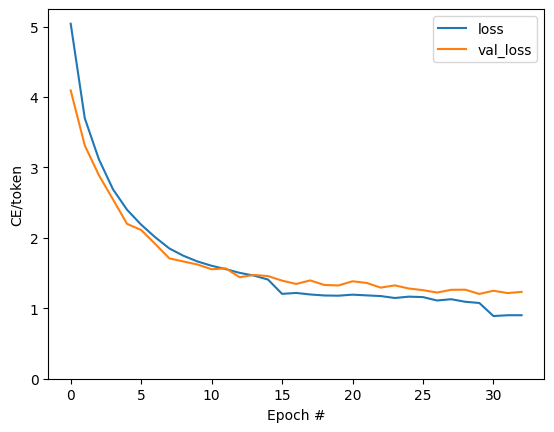

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

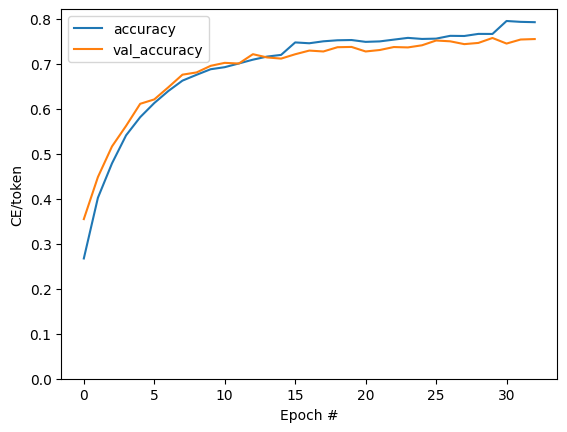

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Translate

Now that the model is trained, implement a function to execute the full `text => text` translation. This code is basically identical to the [inference example](#inference) in the [decoder section](#the_decoder), but this also captures the attention weights.

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

Here are the two helper methods, used above, to convert tokens to text, and to get the next token:

In [ ]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

'is he still home ? '

Use that to generate the attention plot:

In [ ]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

/tmpfs/tmp/ipykernel_55137/3355722706.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmpfs/tmp/ipykernel_55137/3355722706.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


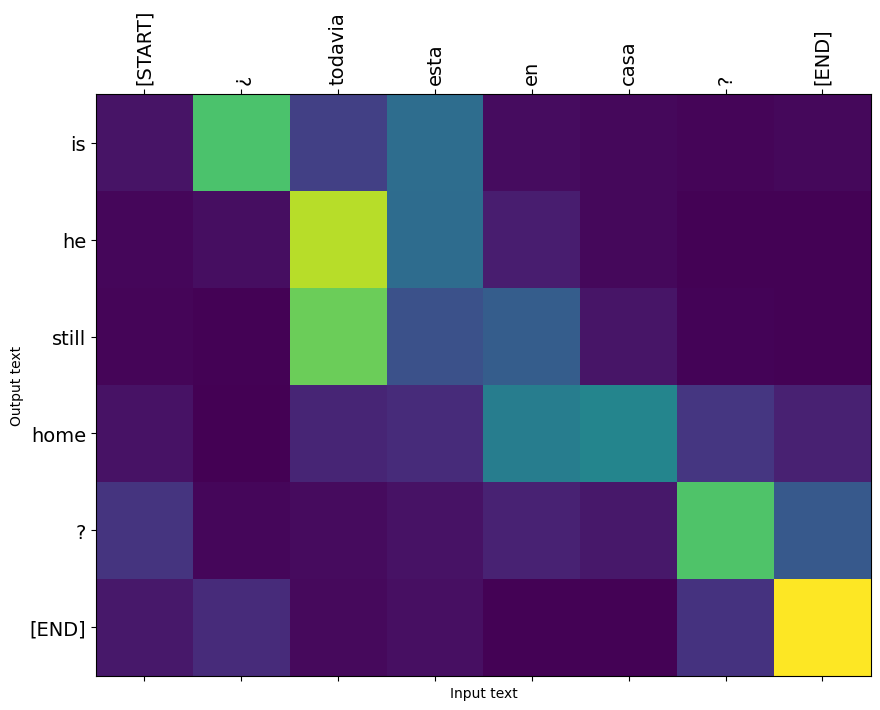

In [ ]:
model.plot_attention('¿Todavía está en casa?') # Are you still home

Translate a few more sentences and plot them:

CPU times: user 250 ms, sys: 36.6 ms, total: 286 ms
Wall time: 190 ms


/tmpfs/tmp/ipykernel_55137/3355722706.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmpfs/tmp/ipykernel_55137/3355722706.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


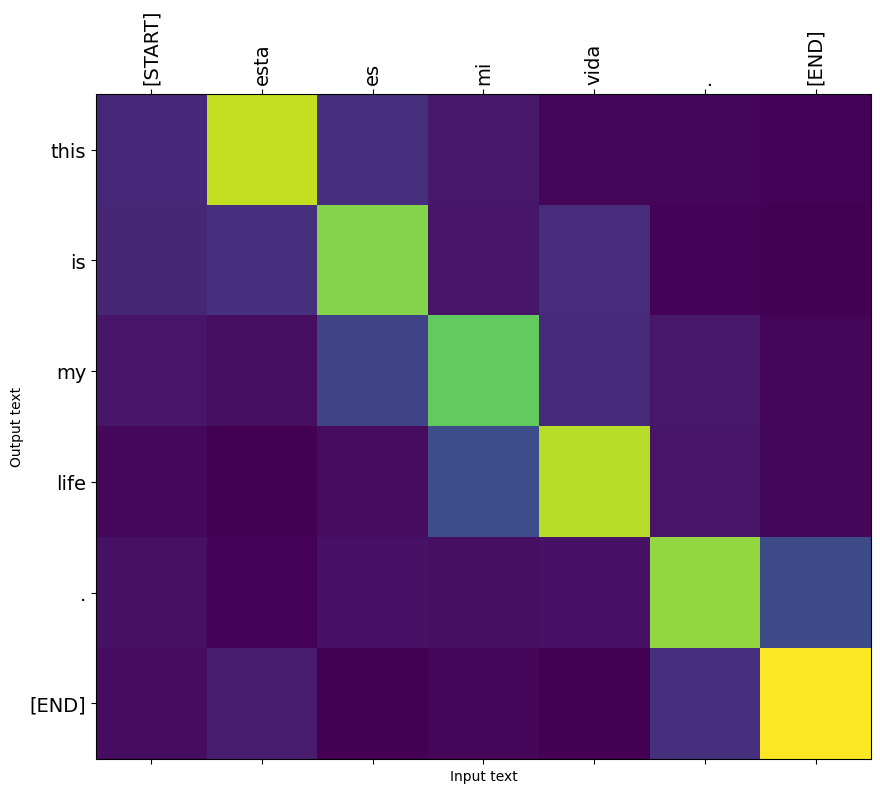

In [ ]:
%%time
# This is my life.
model.plot_attention('Esta es mi vida.')

/tmpfs/tmp/ipykernel_55137/3355722706.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmpfs/tmp/ipykernel_55137/3355722706.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


CPU times: user 233 ms, sys: 37.9 ms, total: 271 ms
Wall time: 189 ms


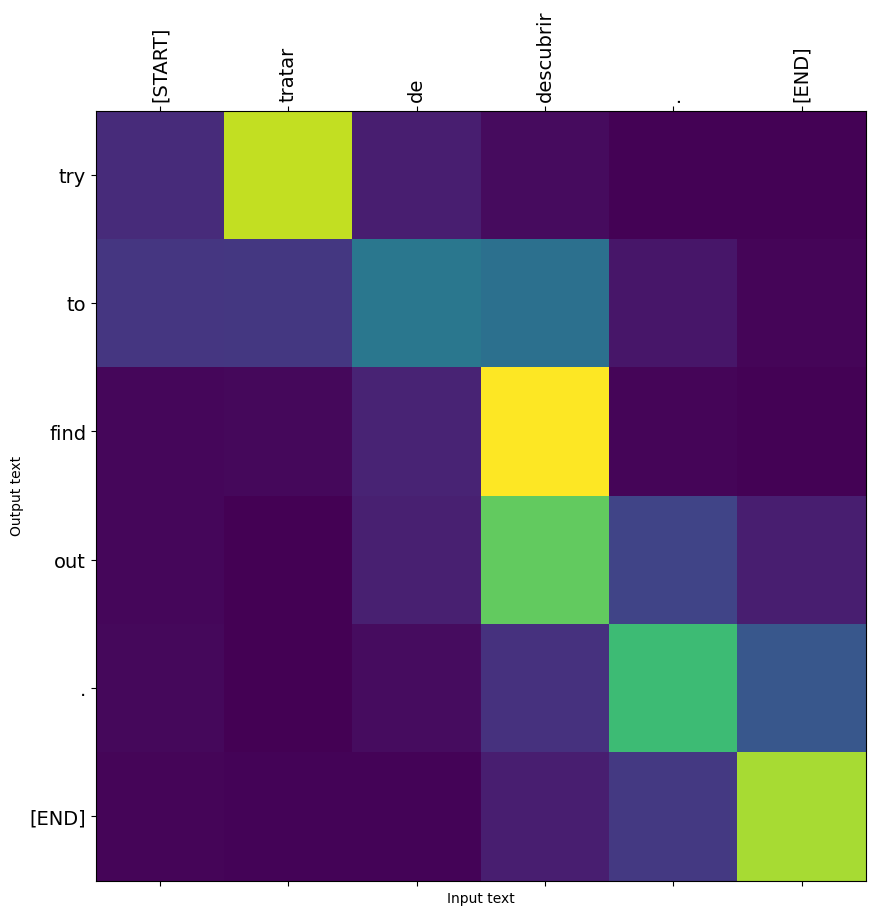

In [ ]:
%%time
 # Try to find out.'
model.plot_attention('Tratar de descubrir.')

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state looses track of where it was in the context sequence there's no way for the model to recover. [Transformers](transformer.ipynb) improve on this by letting the decoder look at what it has output so far.

The raw data is sorted by length, so try translating the longest sequence:

In [ ]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


/tmpfs/tmp/ipykernel_55137/3355722706.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmpfs/tmp/ipykernel_55137/3355722706.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


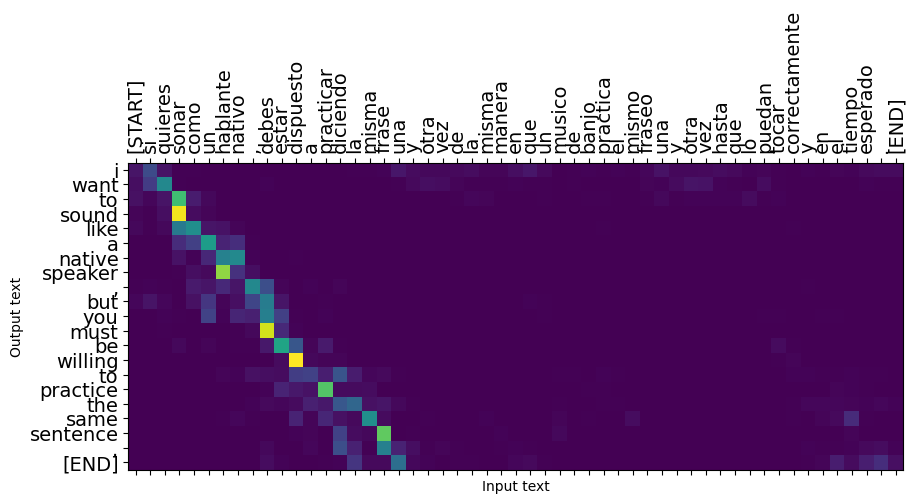

In [ ]:
model.plot_attention(long_text)

The `translate` function works on batches, so if you have multiple texts to translate you can pass them all at once, which is much more efficient than translating them one at a time:

In [ ]:
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]

In [ ]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

its very cold here . 
this is my life . 


his room is a mess . 

CPU times: user 545 ms, sys: 0 ns, total: 545 ms
Wall time: 503 ms


In [ ]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a mess . 

CPU times: user 215 ms, sys: 0 ns, total: 215 ms
Wall time: 198 ms


So overall this text generation function mostly gets the job done, but so you've only used it here in python with eager execution. Let's try to export it next:

### Export

If you want to export this model you'll need to wrap the `translate` method in a `tf.function`. That implementation will get the job done:


In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [ ]:
export = Export(model)

Run the `tf.function` once to compile it:

In [ ]:
%%time
_ = export.translate(tf.constant(inputs))

2022-12-14 13:56:47.581258: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16025321472 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-12-14 13:56:47.582271: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" fr

CPU times: user 1min, sys: 359 ms, total: 1min 1s
Wall time: 1min


In [ ]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
his room is a mess .                                            

CPU times: user 130 ms, sys: 15.5 ms, total: 145 ms
Wall time: 94.2 ms


Now that the function has been traced it can be exported using `saved_model.save`:

In [ ]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


CPU times: user 1min 21s, sys: 904 ms, total: 1min 22s
Wall time: 1min 22s


In [ ]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

2022-12-14 13:58:24.911951: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:25.473192: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:25.949052: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:25.961934: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:26.273340: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:26.633482: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:26.645126: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:29.364540: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:29.484419: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:29.495919: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:29.580131: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:29.591950: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:29.842507: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:30.030477: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:30.042582: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:30.609377: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:31.118607: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:31.604365: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:31.616649: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:31.885643: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:33.314824: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:33.558419: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:33.846072: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:33.857689: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:33.979710: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:34.205632: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:34.218329: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:34.244011: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:34.255197: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:34.530578: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:34.542130: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:34.624061: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:34.635159: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:34.781324: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:34.824486: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:34.836485: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:35.240006: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:35.251916: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:35.272050: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:35.722237: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:35.734816: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:35.879929: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:35.891979: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:36.035880: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:36.274517: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:36.286141: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:36.454068: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:36.465495: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:36.509612: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:36.521330: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:36.540070: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:36.551489: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:37.277701: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:37.437271: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:37.449235: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:37.461977: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:37.690988: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:37.799215: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:37.845924: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:37.857221: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:37.869892: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_sh

2022-12-14 13:58:37.951433: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:38.233487: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:38.549583: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:38.561354: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:38.580805: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:38.592302: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:38.865404: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:38.987245: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:38.999046: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:39.188961: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:39.208443: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:39.429200: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:39.441779: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:39.511347: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:39.522864: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:39.812196: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:41.266444: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:41.388590: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:41.400016: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:41.438897: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:41.460741: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_sh

2022-12-14 13:58:41.473943: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:41.554688: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:41.565886: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:41.665590: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:41.677455: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:41.691709: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:41.703982: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:41.725440: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:41.840018: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes at

2022-12-14 13:58:41.887275: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:41.907636: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:42.497965: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:42.537286: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:42.548574: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:42.567957: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:42.660877: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute

2022-12-14 13:58:42.757821: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:42.769803: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:42.937100: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:43.083468: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:43.095436: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:43.274486: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:43.285987: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:43.302435: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:43.314220: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:43.386263: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:43.397700: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:43.486989: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes at

2022-12-14 13:58:43.513439: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:44.123458: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:44.328738: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:44.340904: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:44.517346: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:44.528668: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:44.595836: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:44.607658: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:44.626519: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:45.217193: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:45.229503: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:45.248240: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:45.536788: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:45.548919: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:45.649904: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:45.661238: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:45.774373: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:46.003054: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:46.015260: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:46.237725: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:46.249797: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:46.340684: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:46.352022: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:46.371060: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_sh

2022-12-14 13:58:46.715569: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:46.728052: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:46.905779: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:46.917179: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:47.251718: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:58:47.263682: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:58:48.601216: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 13:59:00.555150: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16025321472 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-12-14 13:59:00.556041: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" fr

CPU times: user 55.3 s, sys: 786 ms, total: 56 s
Wall time: 54.8 s


In [ ]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
his room is a mess .                                            

CPU times: user 132 ms, sys: 9.63 ms, total: 142 ms
Wall time: 92 ms


#### [Optional] Use a dynamic loop

It's worth noting that this initial implementation is not optimal. It uses a python loop:

```
for _ in range(max_length):
  ...
  if tf.executing_eagerly() and tf.reduce_all(done):
    break
```

The python loop is relatively simple but when `tf.function` converts this to a graph, it **statically unrolls** that loop. Unrolling the loop has two disadvantages:

1. It makes `max_length` copies of the loop body. So the generated graphs take longer to build, save and load.
1. You have to choose a fixed value for the `max_length`. 
1. You can't `break` from a statically unrolled loop. The `tf.function`
  version will run the full `max_length` iterations on every call.
  That's why the `break` only works with eager execution. This is
  still marginally faster than eager execution, but not as fast as it could be.


To fix these shortcomings, the `translate_dynamic` method, below, uses a tensorflow loop:

```
for t in tf.range(max_length):
  ...
  if tf.reduce_all(done):
      break
```

It looks like a python loop, but when you use a tensor as the input to a `for` loop (or the condition of a `while` loop) `tf.function` converts it to a dynamic loop using operations like `tf.while_loop`. 

There's no need for a `max_length` here it's just in case the model gets stuck generating a loop like: `the united states of the united states of the united states...`.

On the down side, to accumulate tokens from this dynamic loop you can't just append them to a python `list`, you need to use a `tf.TensorArray`:

```
tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
...
for t in tf.range(max_length):
    ...
    tokens = tokens.write(t, next_token) # next_token shape is (batch, 1)
  ...
  tokens = tokens.stack()
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
```

This version of the code can be quite a bit more efficient:

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts,
              *,
              max_length=500,
              temperature=tf.constant(0.0)):
  shape_checker = ShapeChecker()
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(context)[0]
  shape_checker(context, 'batch s units')

  next_token, done, state = self.decoder.get_initial_state(context)

  # initialize the accumulator
  tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)

  for t in tf.range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done, state, temperature)
    shape_checker(next_token, 'batch t1')

    # Collect the generated tokens
    tokens = tokens.write(t, next_token)

    # if all the sequences are done, break
    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  tokens = tokens.stack()
  shape_checker(tokens, 't batch t1')
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
  shape_checker(tokens, 'batch t')

  text = self.decoder.tokens_to_text(tokens)
  shape_checker(text, 'batch')

  return text

With eager execution this implementation performs on par with the original:

In [ ]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a mess . 

CPU times: user 217 ms, sys: 12.9 ms, total: 229 ms
Wall time: 210 ms


But when you wrap it in a `tf.function` you'll notice two differences.

In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [ ]:
export = Export(model)

First, it's much quicker to trace, since it only creates one copy of the loop body:

In [ ]:
%%time
_ = export.translate(inputs)

2022-12-14 13:59:20.086095: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16025321472 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


CPU times: user 4.18 s, sys: 0 ns, total: 4.18 s
Wall time: 4.11 s


The `tf.function` is much faster than running with eager execution, and on small inputs it's often several times faster than the unrolled version, because it can break out of the loop.

In [ ]:
%%time
result = export.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a mess . 

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 24.8 ms


So save this version as well:

In [ ]:
%%time
tf.saved_model.save(export, 'dynamic_translator',
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: dynamic_translator/assets


INFO:tensorflow:Assets written to: dynamic_translator/assets


CPU times: user 33.2 s, sys: 0 ns, total: 33.2 s
Wall time: 33.1 s


In [ ]:
%%time
reloaded = tf.saved_model.load('dynamic_translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

2022-12-14 13:59:55.424881: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:59:55.437792: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 13:59:56.651240: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:59:56.799047: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:59:56.810356: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 13:59:57.352380: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:59:57.365444: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:59:57.516939: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:59:57.528773: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 13:59:57.865797: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:59:58.227727: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:59:58.480103: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:59:58.491636: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 13:59:59.380516: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 13:59:59.392889: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 13:59:59.671655: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:59:59.683849: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 13:59:59.798472: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 14:00:00.233894: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:00.282491: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:00.294064: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:00.362799: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 14:00:00.448605: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:00.460573: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 14:00:00.701856: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:00.714765: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:00.844588: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:00.855846: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 14:00:00.970931: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 14:00:01.236008: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:01.427677: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


2022-12-14 14:00:01.890681: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:01.902483: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:02.075993: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:02.088427: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 14:00:04.834595: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:04.849295: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:04.905721: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:04.921166: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:04.933552: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes at

2022-12-14 14:00:05.322547: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:05.334504: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:05.412308: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-12-14 14:00:05.423506: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.


2022-12-14 14:00:06.933245: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16025321472 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


CPU times: user 14.1 s, sys: 0 ns, total: 14.1 s
Wall time: 14 s


In [ ]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a mess . 

CPU times: user 40.3 ms, sys: 0 ns, total: 40.3 ms
Wall time: 20.2 ms


## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs.
* Try the [transformer tutorial](transformer.ipynb) which implements a similar translation task but uses transformer layers instead of RNNs. This version also uses a `text.BertTokenizer` to implement word-piece tokenization.
* Visit the [`tensorflow_addons.seq2seq` tutorial](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt), which demonstrates a higher-level functionality for implementing this sort of sequence-to-sequence model, such as `seq2seq.BeamSearchDecoder`.